In [1]:
with open("/home/mambauser/.cdsapirc", "w") as f:
    f.write("url: https://cds.climate.copernicus.eu/api\n")
    f.write("key: 76e66c20-0296-4f8c-a97c-f48fab0d9ba4\n")

In [2]:
# Imports
!pip install cdsapi
import numpy as np
import xarray as xr
import dask
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xclim
import xclim.indices as xci
from xarray.coding.calendar_ops import convert_calendar
import gcsfs
import zarr
from siphon.catalog import TDSCatalog
import os
import cdsapi
from tqdm.auto import tqdm

# For plotting map later
spkws = dict(projection=ccrs.PlateCarree(), transform=ccrs.PlateCarree())

jeddah_bbox = [21.8, 38.9, 21.2, 39.5]
riyadh_bbox = [25.1, 46.2, 24.3, 47.1]

years = [x for x in range(1985, 2015)] # for 1985 - 2014



# Only essential variables for CDD and wet-bulb temperature
variables = [
    '2m_temperature',           # For CDD calculation
    '2m_dewpoint_temperature',  # For wet-bulb temperature calculation
    'surface_pressure'          # For accurate wet-bulb calculation (optional but recommended)
]

def download_era5_data(city, bbox, output_dir):
    """Download ERA5-Land data for specified city"""
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize CDS client
    c = cdsapi.Client()
    
    print(f"Downloading ERA5-Land data for {city}...")
    
    for year in tqdm(years, desc=f"Downloading {city} data"):
        out_file = os.path.join(output_dir, f'era5_land_{city}_{year}.nc')
        
        # Skip if file exists
        if os.path.exists(out_file):
            print(f"File {out_file} already exists. Skipping...")
            continue
            
        c.retrieve(
            'reanalysis-era5-land',
            {
                'product_type': 'reanalysis',
                'variable': variables,
                'year': str(year),
                'month': [f"{m:02d}" for m in range(1, 13)],
                'day': [f"{d:02d}" for d in range(1, 32)],
                'time': ['00:00'],  # Daily data at midnight UTC
                'format': 'netcdf',
                'area': bbox,
            }, 
            out_file
        )

def combine_and_process_data(city, output_dir):
    """Combine annual files and add derived variables"""
    
    print(f"Combining and processing {city} data...")
    
    # Load and combine files
    ds_list = []
    for year in years:
        path = os.path.join(output_dir, f'{city}_{year}.nc')
        if os.path.exists(path):
            print(f'Processing file {path}')
            ds = xr.open_dataset(path, engine='netcdf4')
            
            # Standardize time dimension name
            if 'valid_time' in ds.dims:
                ds = ds.rename({'valid_time': 'time'})
            
            ds_list.append(ds)
    
    # Combine datasets
    ds_combined = xr.concat(ds_list, dim='time')
    
    # Convert temperature from Kelvin to Celsius
    ds_combined['t2m'] = ds_combined['t2m'] - 273.15
    ds_combined['d2m'] = ds_combined['d2m'] - 273.15
    
    # Add required attributes for xclim
    ds_combined['d2m'].attrs.update({
        'units': 'degC',
        'standard_name': 'dew_point_temperature'
    })
    ds_combined['t2m'].attrs.update({
        'units': 'degC', 
        'standard_name': 'air_temperature'
    })
    
    # Calculate relative humidity
    ds_combined['rhum'] = xclim.atmos.relative_humidity_from_dewpoint(
        tdps=ds_combined['d2m'], 
        tas=ds_combined['t2m']
    )
    ds_combined['rhum'].attrs.update({
        'units': '%', 
        'long_name': 'Relative Humidity'
    })
    
    # Save combined dataset
    output_file = f'era5_{city}_1990_2020_optimized.nc'
    ds_combined.to_netcdf(output_file)
    print(f"Combined dataset saved as: {output_file}")
    
    return ds_combined

# Download data for both cities
"""Main function to download and process data for both cities"""
    
cities = {
         'jeddah': jeddah_bbox,
        'riyadh': riyadh_bbox
    }
    
for city, bbox in cities.items():
    print(f"\n=== Processing {city.upper()} ===")
        
    # Set output directory
    output_dir = f"{city}_land_optimized"
    
    # Download data
    download_era5_data(city, bbox, output_dir)
        
    # Combine and process
    #ds = combine_and_process_data(city, output_dir)
        
    print(f"{city.upper()} dataset shape: {ds.dims}")
    print(f"Variables: {list(ds.data_vars.keys())}")




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [cdsapi]

=== Processing JEDDAH ===
Combining and processing jeddah data...
Processing file jeddah_land_optimized/jeddah_1990.nc
Processing file jeddah_land_optimized/jeddah_1991.nc
Processing file jeddah_land_optimized/jeddah_1992.nc
Processing file jeddah_land_optimized/jeddah_1993.nc
Processing file jeddah_land_optimized/jeddah_1994.nc
Processing file jeddah_land_optimized/jeddah_1995.nc
Processing file jeddah_land_optimized/jeddah_1996.nc
Processing file jeddah_land_optimized/jeddah_1997.nc
Processing file jeddah_land_optimized/jeddah_1998.nc
Processing file jeddah_land_optimized/jeddah_1999.nc
Processing file jeddah_land_optimized/jeddah_2000.nc
Processing file jeddah_land_optimized/jeddah_2001.nc
Processing file jeddah_land_optimized/jeddah_2002.nc
Processing file jeddah_land_optimized/jeddah_2003.nc
Processing file jeddah_land_optimized/jeddah_2004.nc
Processing file jeddah_land_optimized/jeddah_2005.nc
Processing file jeddah_land_

In [4]:
ds_jeddah = xr.open_dataset(f'era5_land_jeddah_1985_2014_noleap.nc')
ds_riyadh = xr.open_dataset(f'era5_land_riyadh_1985_2014_noleap.nc')

In [14]:
# 1. Annual Mean Temperature Trends (1990-2020)
def plot_annual_trends(ds, city_name):
    """Plot annual mean temperature trends"""
    
    # Calculate annual means (spatial average)
    annual_temp = ds['t2m'].groupby('time.year').mean().mean(['latitude', 'longitude'])
    
    plt.figure(figsize=(10, 6))
    plt.plot(annual_temp.year, annual_temp, 'o-', linewidth=2, markersize=6)
    
    # Add trend line
    z = np.polyfit(annual_temp.year, annual_temp, 1)
    trend_line = np.poly1d(z)
    plt.plot(annual_temp.year, trend_line(annual_temp.year), 'r--', alpha=0.7)
    
    plt.title(f'{city_name} - Annual Mean Temperature Trends (1990-2020)')
    plt.xlabel('Year')
    plt.ylabel('Temperature (°C)')
    plt.grid(True, alpha=0.3)
    
    # Calculate trend
    trend = z[0] * 10  # Per decade
    plt.text(0.02, 0.98, f'Trend: {trend:.2f}°C/decade', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return annual_temp

# 2. Coldest/Hottest Days Identification
def find_extreme_days(ds, city_name):
    """Find and plot extreme temperature days"""
    
    # Calculate daily spatial means
    daily_temp = ds['t2m'].mean(['latitude', 'longitude'])
    
    # Find extremes
    hottest_day = daily_temp.where(daily_temp == daily_temp.max(), drop=True)
    coldest_day = daily_temp.where(daily_temp == daily_temp.min(), drop=True)
    
    print(f"\n{city_name} Temperature Extremes:")
    print(f"Hottest day: {hottest_day.time.values[0]} - {hottest_day.values[0]:.1f}°C")
    print(f"Coldest day: {coldest_day.time.values[0]} - {coldest_day.values[0]:.1f}°C")
    
    # Plot annual extremes
    annual_max = daily_temp.groupby('time.year').max()
    annual_min = daily_temp.groupby('time.year').min()
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(annual_max.year, annual_max, 'ro-', label='Annual Maximum')
    plt.title(f'{city_name} - Annual Maximum Temperatures')
    plt.xlabel('Year')
    plt.ylabel('Temperature (°C)')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(annual_min.year, annual_min, 'bo-', label='Annual Minimum')
    plt.title(f'{city_name} - Annual Minimum Temperatures')
    plt.xlabel('Year')
    plt.ylabel('Temperature (°C)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return hottest_day, coldest_day



=== Temperature EDA Analysis ===

1. Annual Temperature Trends


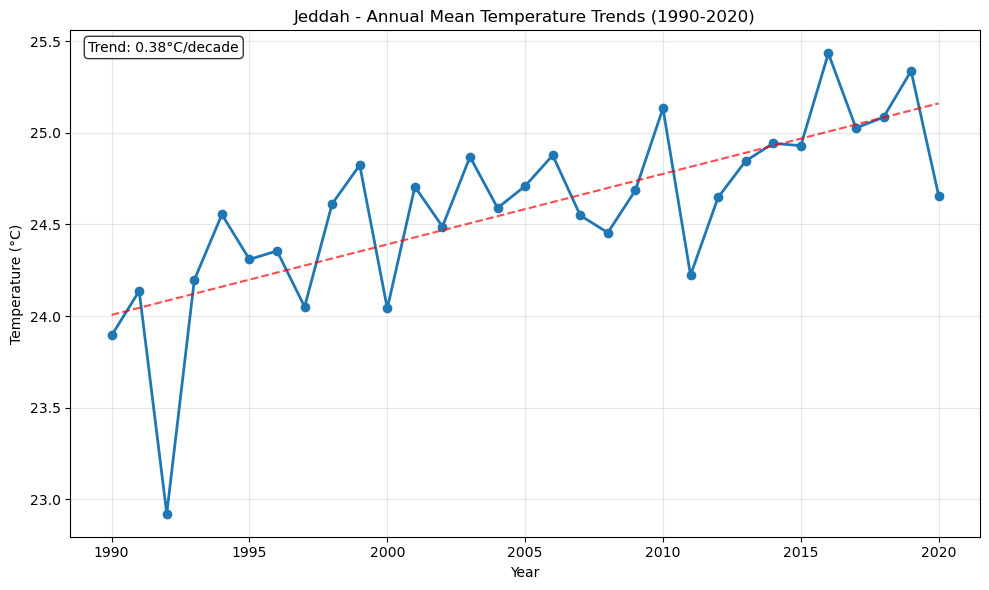

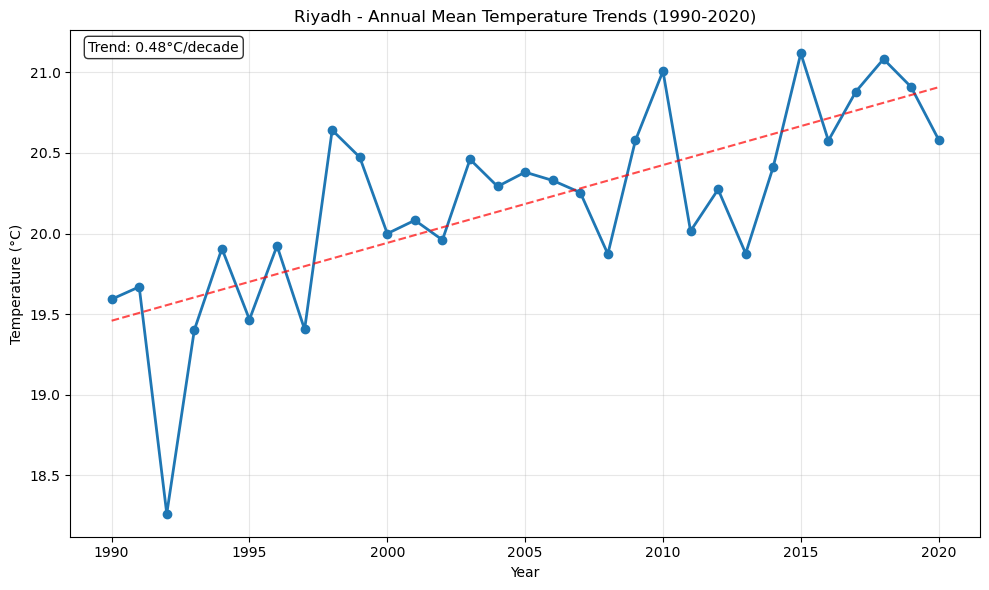

In [15]:
print("=== Temperature EDA Analysis ===\n")
    
# 1. Annual trends
print("1. Annual Temperature Trends")
jeddah_annual = plot_annual_trends(ds_jeddah, "Jeddah")
riyadh_annual = plot_annual_trends(ds_riyadh, "Riyadh")
    



2. Extreme Temperature Days

Jeddah Temperature Extremes:
Hottest day: 2003-06-09T00:00:00.000000000 - 32.9°C
Coldest day: 1993-02-06T00:00:00.000000000 - 12.3°C


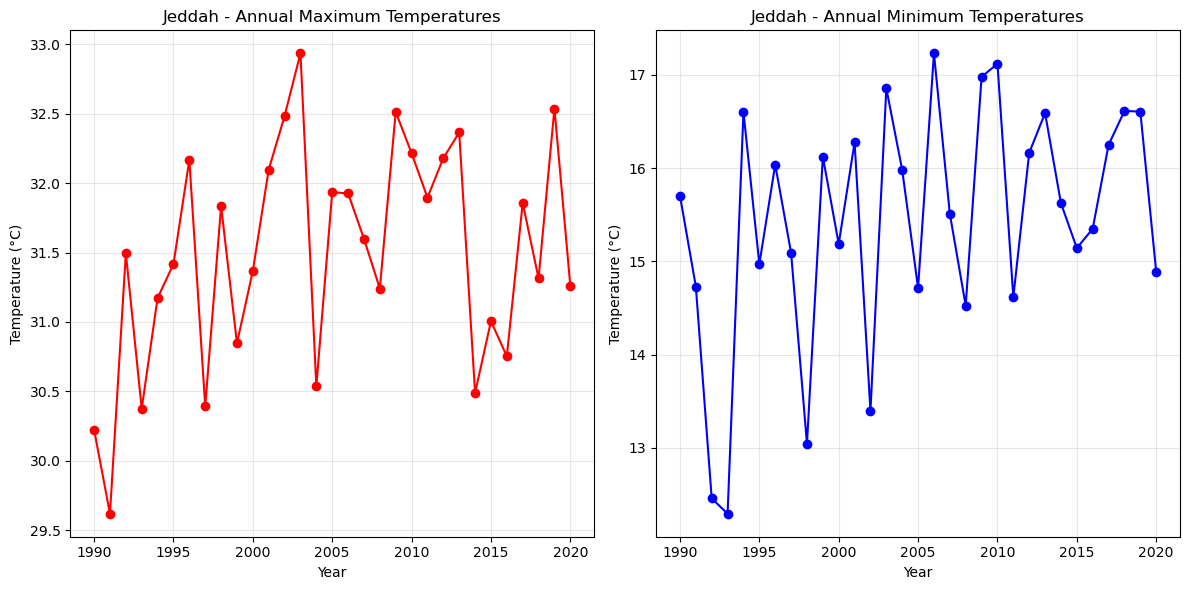


Riyadh Temperature Extremes:
Hottest day: 2020-07-31T00:00:00.000000000 - 34.5°C
Coldest day: 2008-01-17T00:00:00.000000000 - -3.0°C


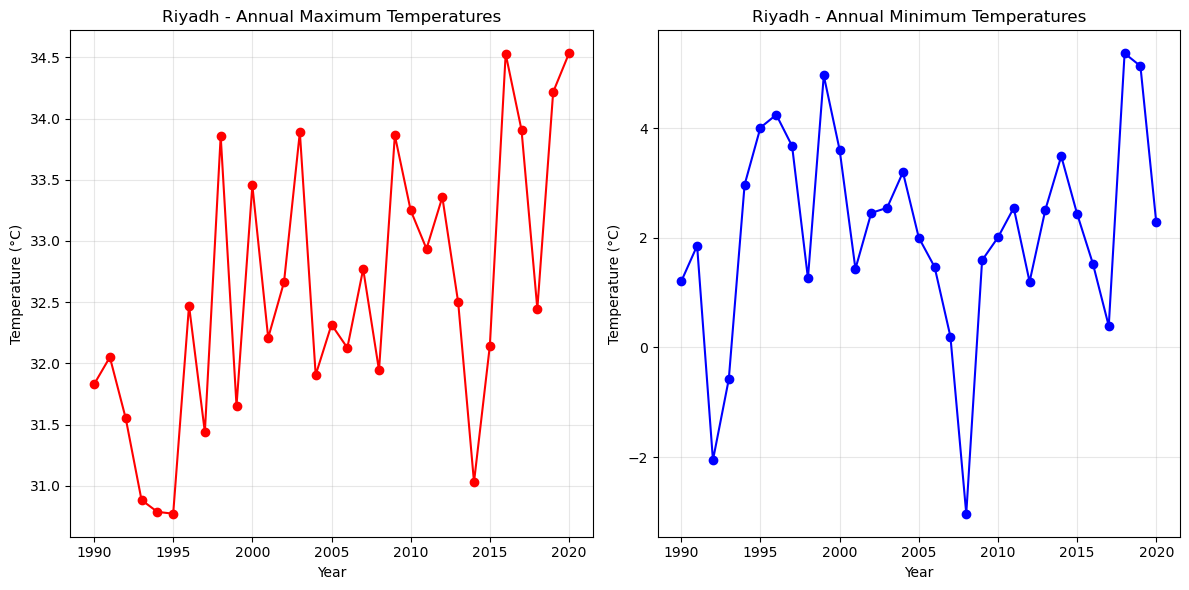

In [16]:
# 2. Extreme days
print("\n2. Extreme Temperature Days")
jeddah_extremes = find_extreme_days(ds_jeddah_clean, "Jeddah")
riyadh_extremes = find_extreme_days(ds_riyadh, "Riyadh")
    


In [26]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# Sample Data (replace with your actual data loading)
# This creates a dummy xarray Dataset for demonstration purposes
times = pd.date_range("1990-01-01", "2020-12-31", freq="D")
lats = np.arange(20, 30, 1)
lons = np.arange(40, 50, 1)
temp_data = np.random.rand(len(times), len(lats), len(lons)) * 20 + 20 # Random temperatures
ds = xr.Dataset(
    {
        "t2m": (("time", "latitude", "longitude"), temp_data)
    },
    coords={
        "time": times,
        "latitude": lats,
        "longitude": lons,
    },
)


# Define the decades
section_1 = list(range(1985, 1996)) # Years 1985 to 1995
section_2 = list(range(1996, 2006)) # Years 1996 to 2005
section_3 = list(range(2006, 2015)) # Years 2006 to 2014

# Method 1: Plot annual averages for each decade
def plot_annual_averages(ds, name='Riyadh'):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Calculate annual means for each decade
    for decade, color, label in zip([section_1, section_2, section_3],
                                    ['blue', 'green', 'red'],
                                    ['1985-1995', '1996-2005', '2006-2014']):
        decade_data = ds.t2m.sel(time=ds.t2m.time.dt.year.isin(decade))
        # Average over spatial dimensions first, then group by year
        spatial_avg = decade_data.mean(dim=['latitude', 'longitude'])
        annual_means = spatial_avg.groupby('time.year').mean()

        ax.plot(annual_means.year, annual_means.values,
                color=color, marker='o', linewidth=2, markersize=4, label=label)

    ax.set_xlabel('Year')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title(f'{name} Annual Average Temperature by Decade')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Method 2: Plot seasonal patterns for each decade
def plot_seasonal_comparison(ds, name='Riyadh'):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    seasons = {
        'Winter (DJF)': [12, 1, 2],
        'Spring (MAM)': [3, 4, 5],
        'Summer (JJA)': [6, 7, 8],
        'Autumn (SON)': [9, 10, 11]
    }

    for i, (season_name, months) in enumerate(seasons.items()):
        ax = axes.flat[i]

        for decade, color, label in zip([section_1, section_2, section_3],
                                        ['blue', 'green', 'red'],
                                        ['1985-1995', '1996-2005', '2006-2014']):

            decade_data = ds.t2m.sel(time=ds.t2m.time.dt.year.isin(decade))
            seasonal_data = decade_data.sel(time=decade_data.time.dt.month.isin(months))
            # Average over spatial dimensions first
            spatial_avg = seasonal_data.mean(dim=['latitude', 'longitude'])
            monthly_means = spatial_avg.groupby('time.month').mean()

            ax.plot(monthly_means.month, monthly_means.values,
                    color=color, marker='o', linewidth=2, label=label)

        ax.set_title(season_name)
        ax.set_xlabel('Month')
        ax.set_ylabel('Temperature (°C)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle(f'{name} Seasonal Temperature Trends by Decade', fontsize=16)
    plt.tight_layout()
    plt.show()

# Method 3: Decadal average comparison (bar plot)
def plot_decadal_averages(ds, name='Riyadh'):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Calculate overall average for each decade
    decade_averages = []
    decade_labels = ['1985-1995', '1996-2005', '2006-2014']

    for decade in [section_1, section_2, section_3]:
        decade_data = ds.t2m.sel(time=ds.t2m.time.dt.year.isin(decade))
        # Average over all dimensions (time, lat, lon)
        avg_temp = decade_data.mean().item()
        decade_averages.append(avg_temp)

    colors = ['blue', 'green', 'red']
    bars = ax.bar(decade_labels, decade_averages, color=colors, alpha=0.7, edgecolor='black')

    # Add value labels on bars
    for bar, avg in zip(bars, decade_averages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{avg:.1f}°C', ha='center', va='bottom', fontweight='bold')

    ax.set_ylabel('Average Temperature (°C)')
    ax.set_title(f'{name} Decadal Average Temperature Comparison')
    ax.grid(True, alpha=0.3, axis='y')

    # Show temperature increase
    temp_increase = decade_averages[-1] - decade_averages[0]
    ax.text(0.02, 0.98, f'30-year increase: +{temp_increase:.1f}°C',
            transform=ax.transAxes, fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

    plt.tight_layout()
    plt.show()

    return decade_averages

# Method 4: Monthly climatology comparison
def plot_monthly_climatology(ds, name='Riyadh'):
    fig, ax = plt.subplots(figsize=(12, 6))

    for decade, color, label in zip([section_1, section_2, section_3],
                                    ['blue', 'green', 'red'],
                                    ['1985-1995', '1996-2005', '2006-2014']):

        decade_data = ds.t2m.sel(time=ds.t2m.time.dt.year.isin(decade))
        # Average over spatial dimensions first
        spatial_avg = decade_data.mean(dim=['latitude', 'longitude'])
        monthly_clim = spatial_avg.groupby('time.month').mean()

        ax.plot(monthly_clim.month, monthly_clim.values,
                color=color, marker='o', linewidth=3, markersize=6, label=label)

    ax.set_xlabel('Month')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title(f'{name} Monthly Temperature Climatology by Decade')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



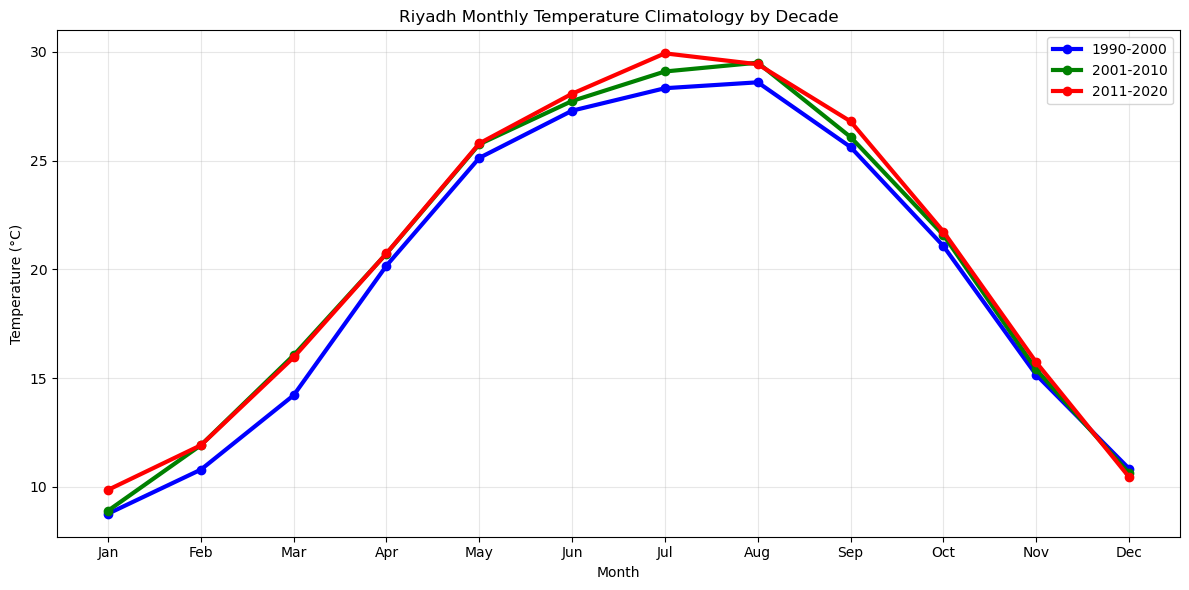

In [27]:
plot_monthly_climatology(ds_riyadh)

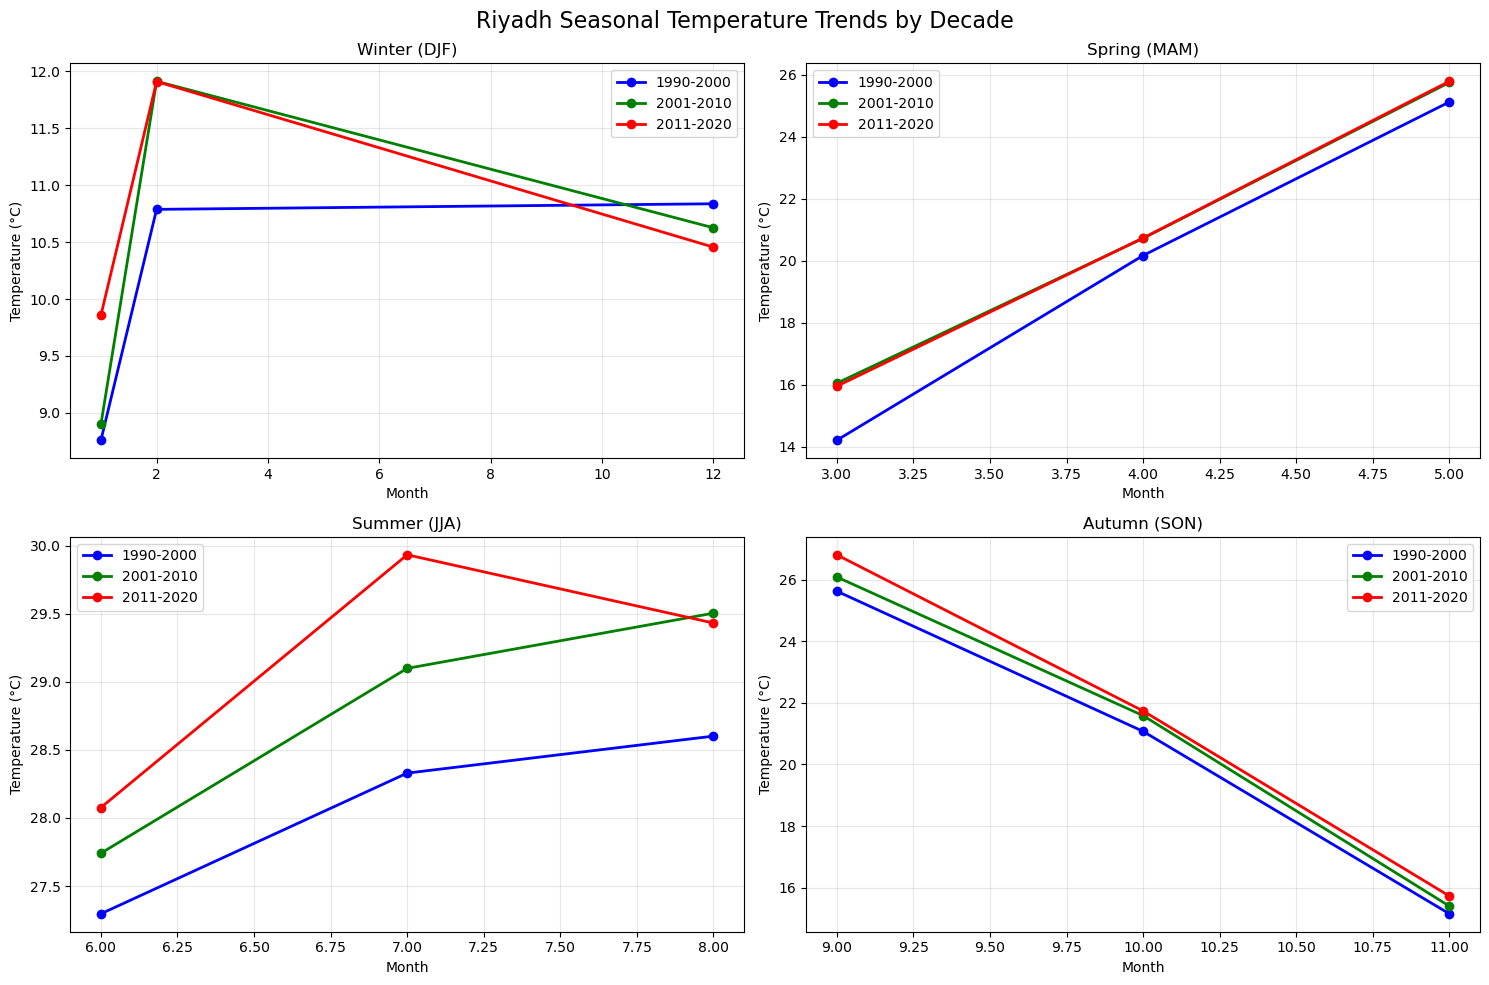

In [28]:
plot_seasonal_comparison(ds_riyadh)

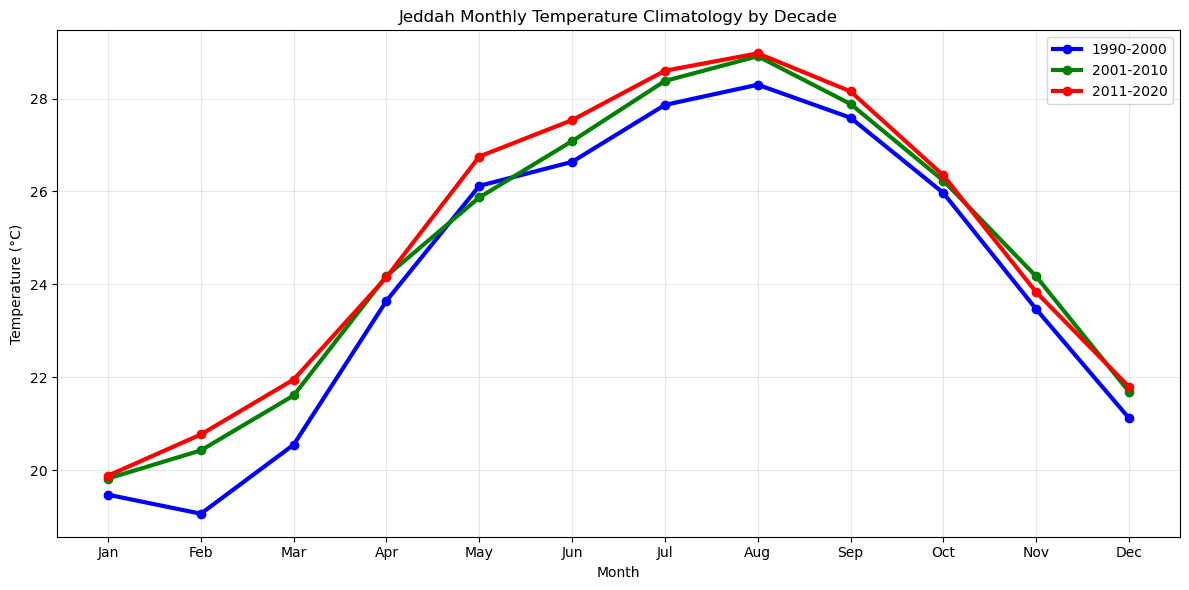

In [33]:
plot_monthly_climatology(ds_jeddah, 'Jeddah')

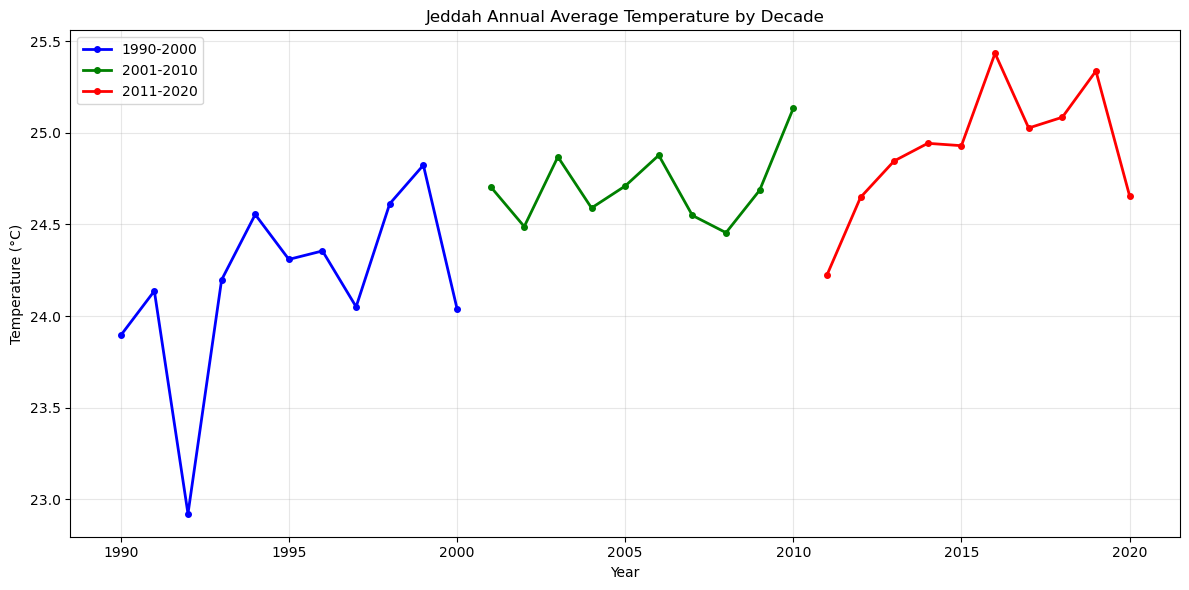

In [34]:
plot_annual_averages(ds_jeddah, 'Jeddah')

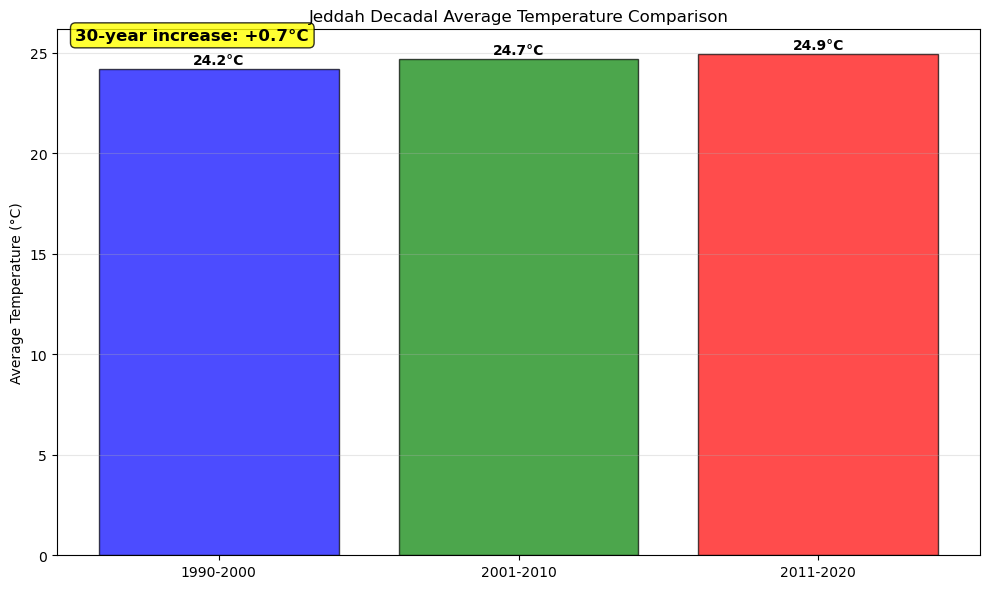

In [35]:
decade_temps = plot_decadal_averages(ds_jeddah, 'Jeddah')

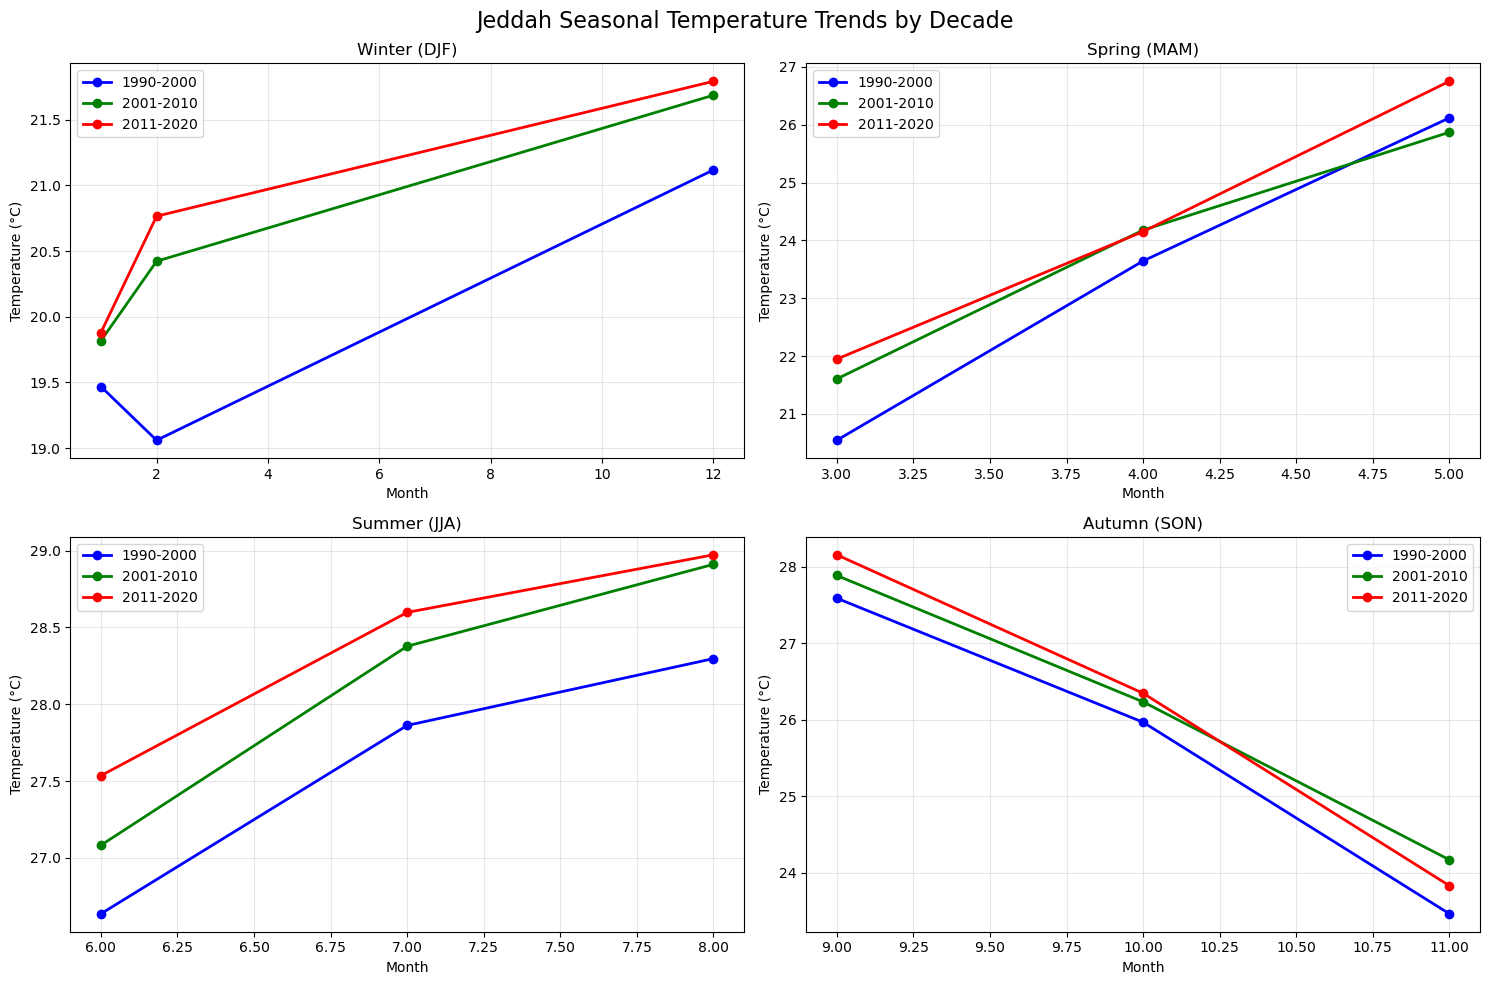

In [36]:
plot_seasonal_comparison(ds_jeddah, 'Jeddah')

=== Statistical Analysis ===


--- Jeddah Statistical Analysis ---
1. Distribution Changes by Decade


/tmp/ipykernel_35/2928212497.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['1990s', '2000s', '2010s'])


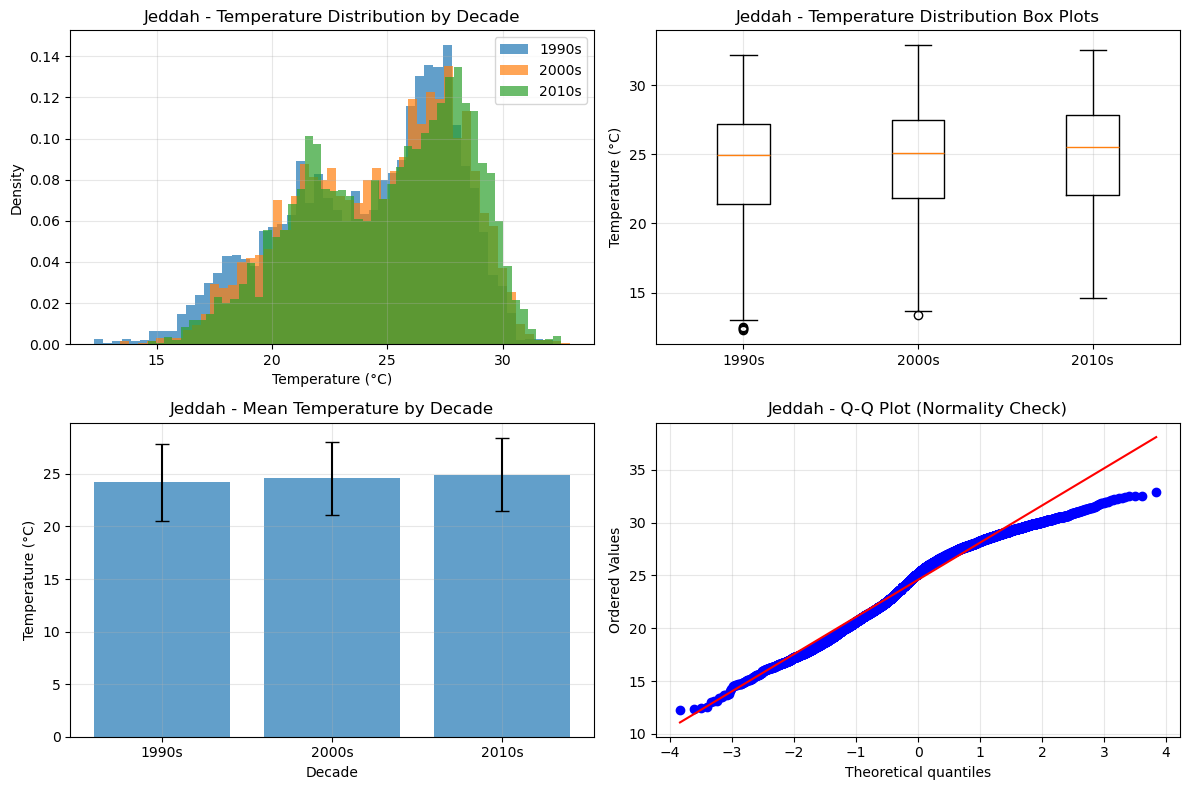


Jeddah Decade Statistics:
1990s: Mean=24.19°C, Std=3.68°C
2000s: Mean=24.60°C, Std=3.49°C
2010s: Mean=24.93°C, Std=3.51°C

2. Percentile Trends
Jeddah 95th percentile trend: 0.42°C/decade
Jeddah 99th percentile trend: 0.36°C/decade


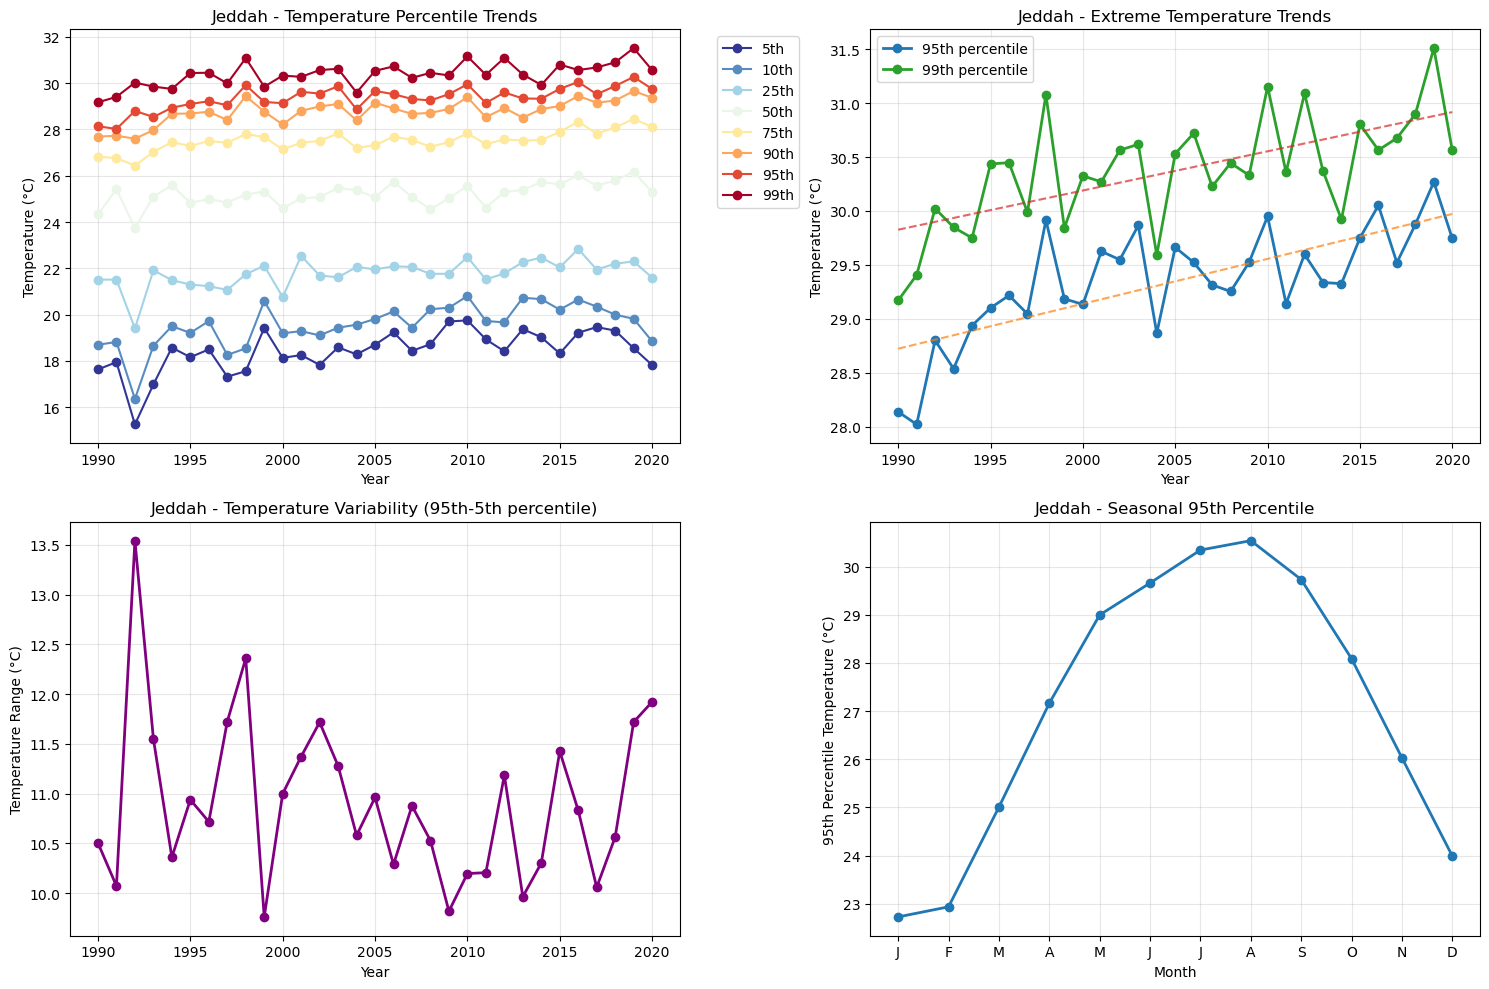


3. Temperature-Dewpoint Correlation


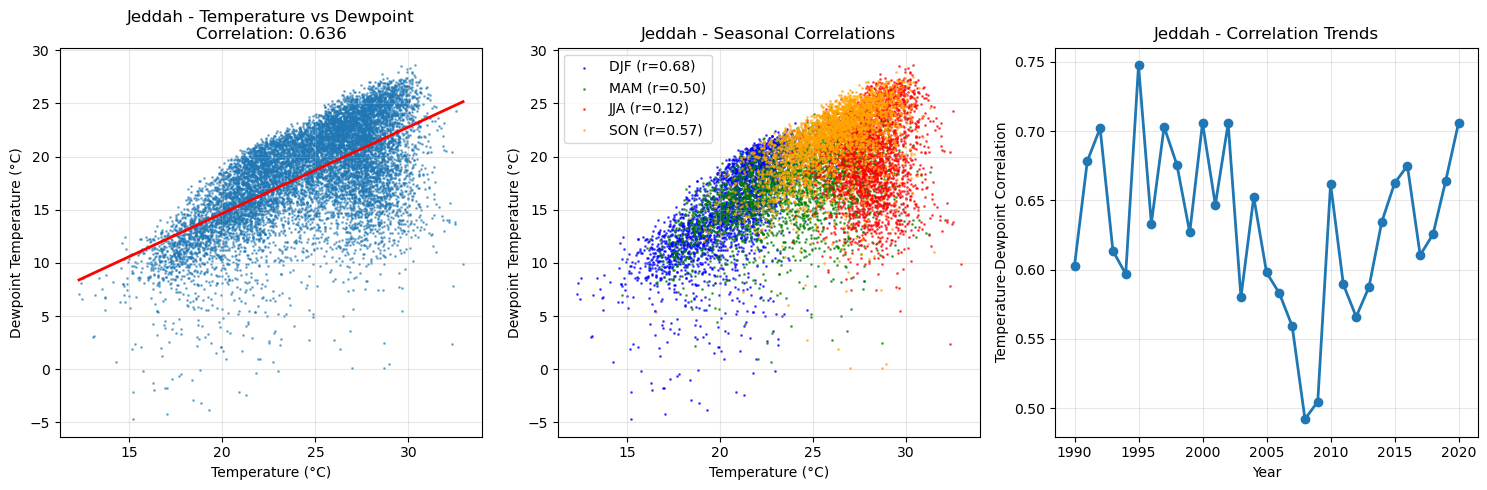


Jeddah Temperature-Dewpoint Analysis:
Overall correlation: 0.636
Mean annual correlation: 0.632

4. Trend Analysis with Statistical Significance


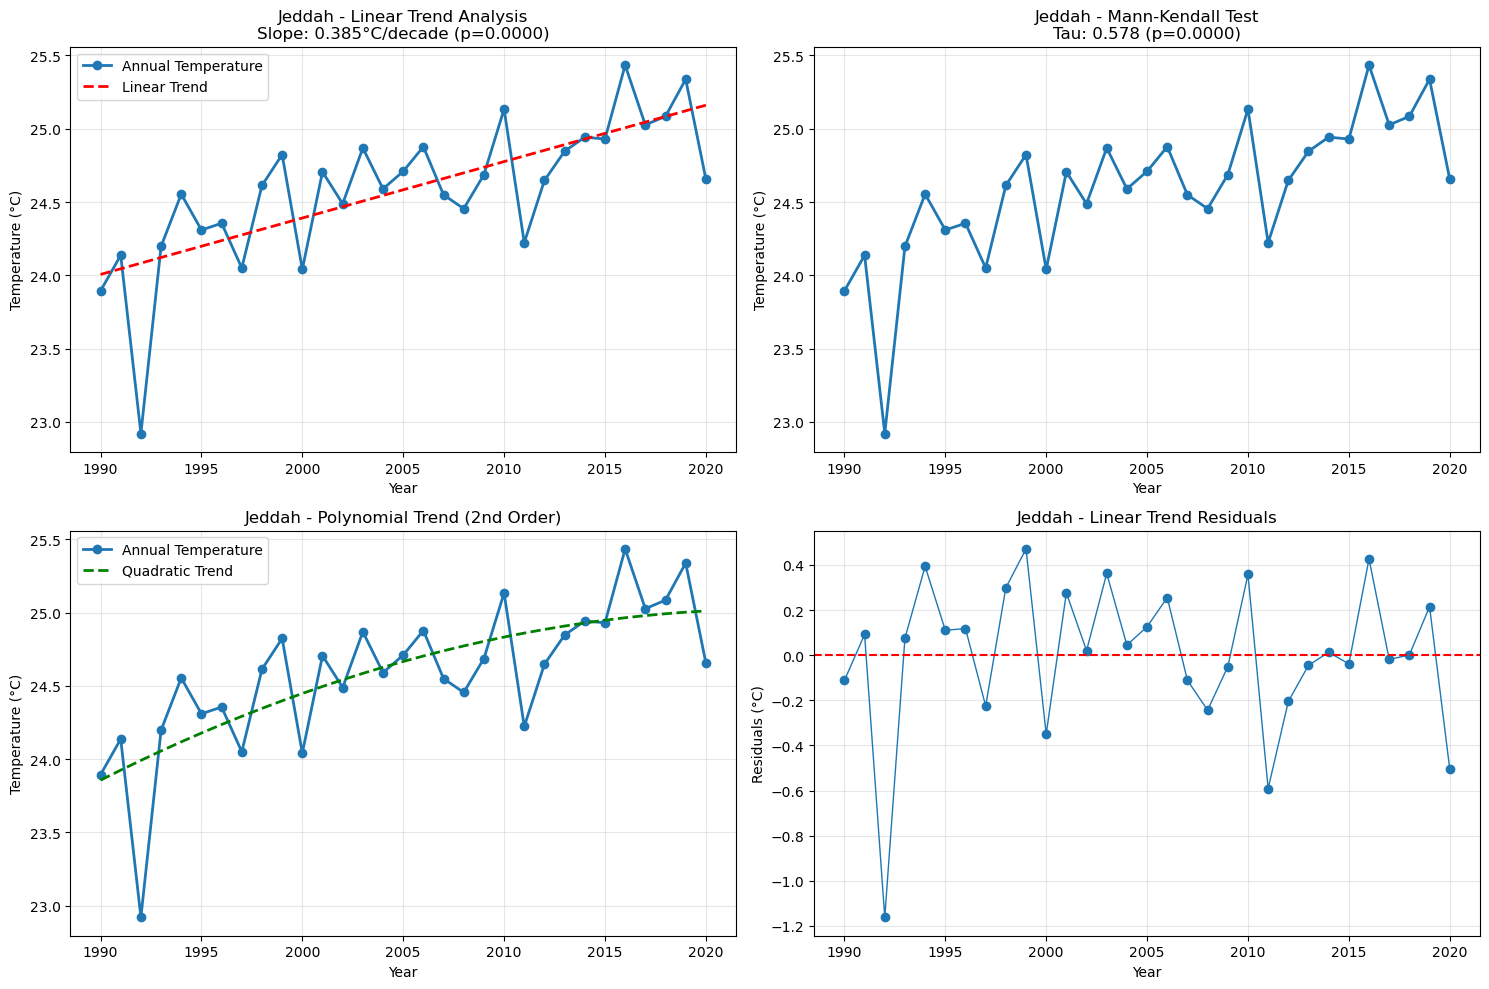


Jeddah Trend Analysis Results:
Linear trend: 0.385°C/decade
R-squared: 0.518
P-value (linear): 0.0000
Standard error: 0.069°C/decade
✓ Linear trend is statistically significant (p < 0.05)
✓ Mann-Kendall trend is statistically significant (p < 0.05)

--- Riyadh Statistical Analysis ---
1. Distribution Changes by Decade


/tmp/ipykernel_35/2928212497.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['1990s', '2000s', '2010s'])


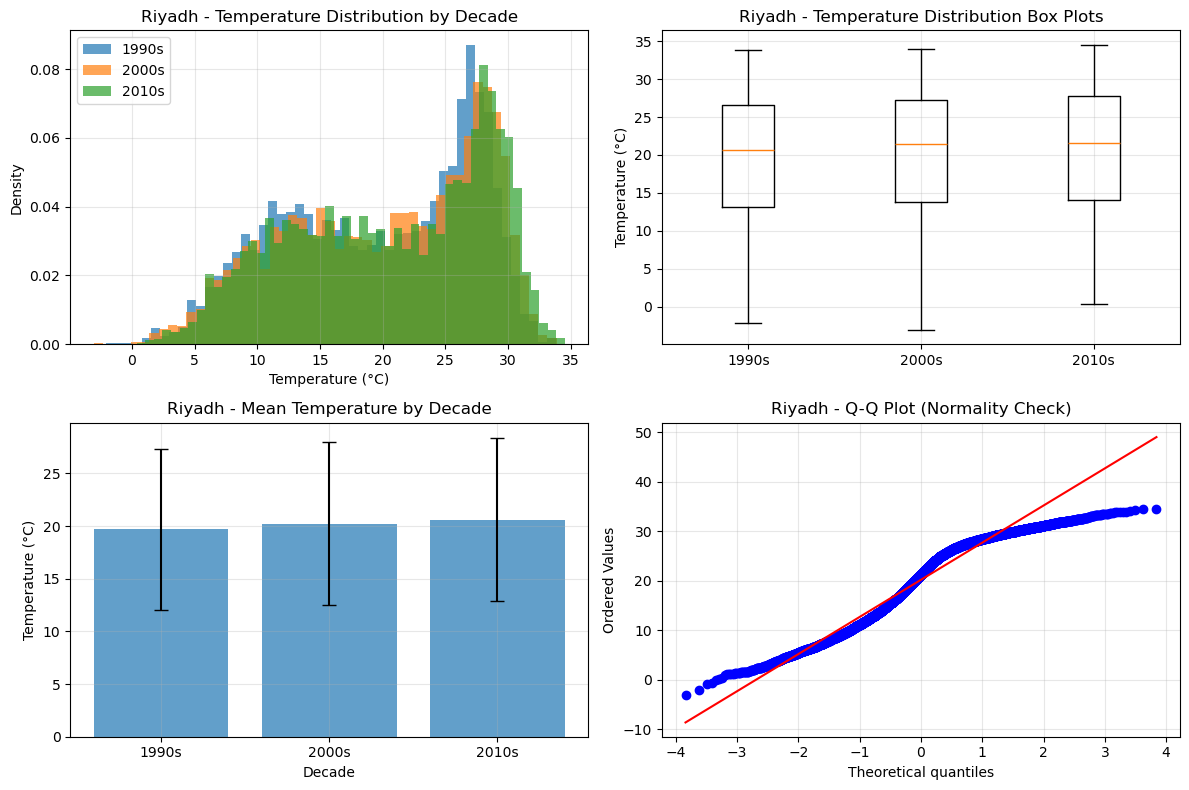


Riyadh Decade Statistics:
1990s: Mean=19.67°C, Std=7.60°C
2000s: Mean=20.22°C, Std=7.72°C
2010s: Mean=20.61°C, Std=7.77°C

2. Percentile Trends
Riyadh 95th percentile trend: 0.62°C/decade
Riyadh 99th percentile trend: 0.71°C/decade


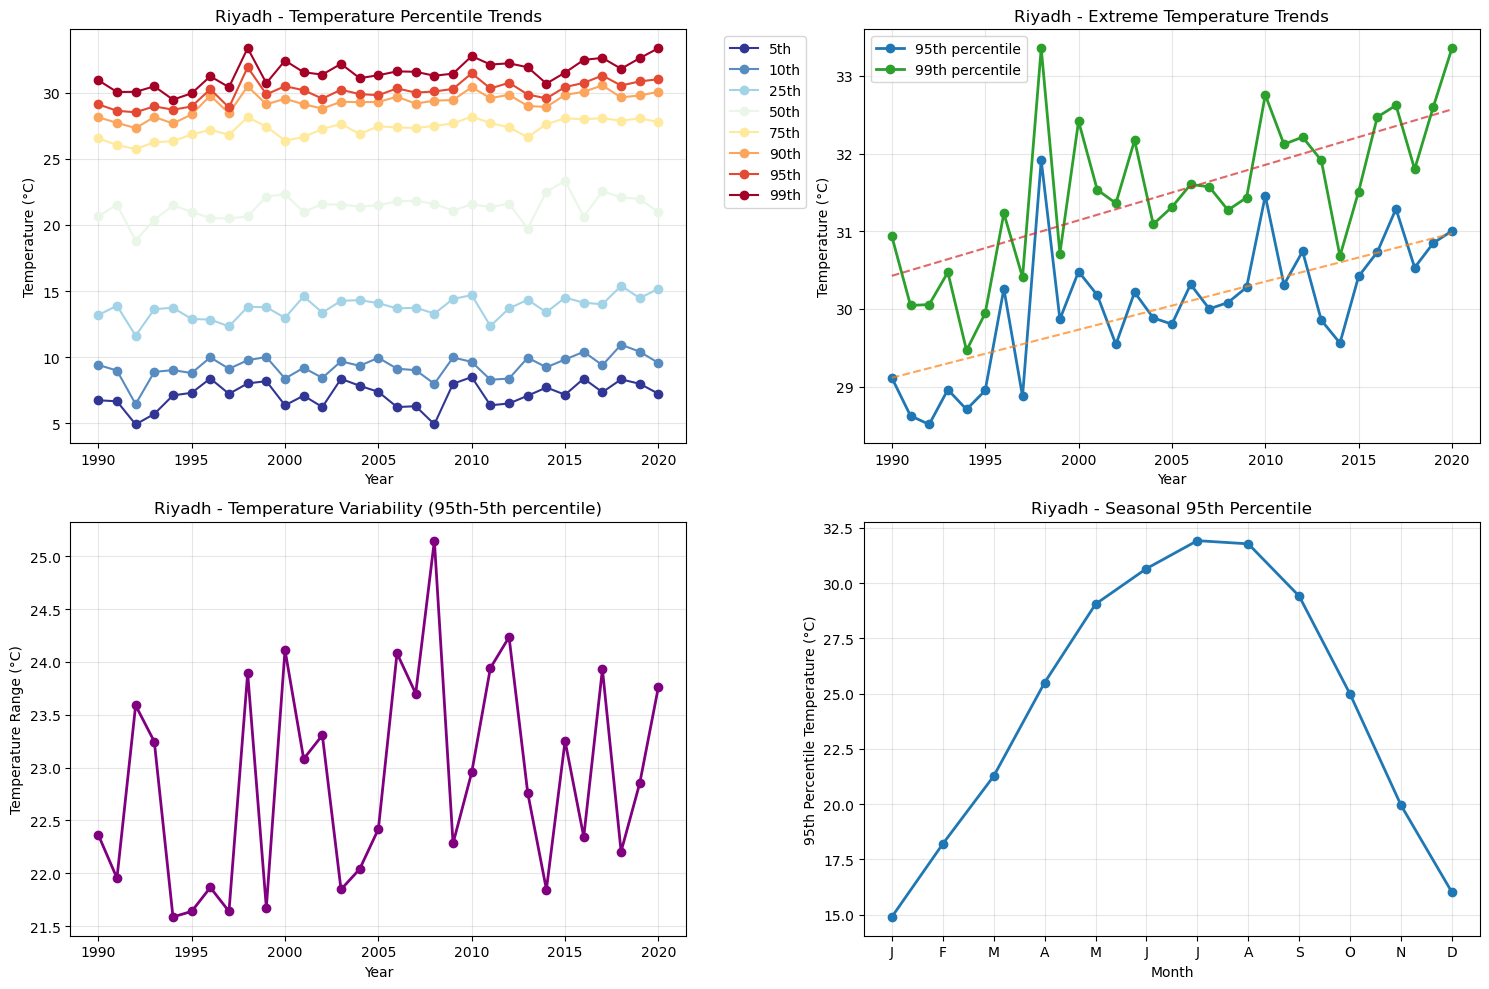


3. Temperature-Dewpoint Correlation


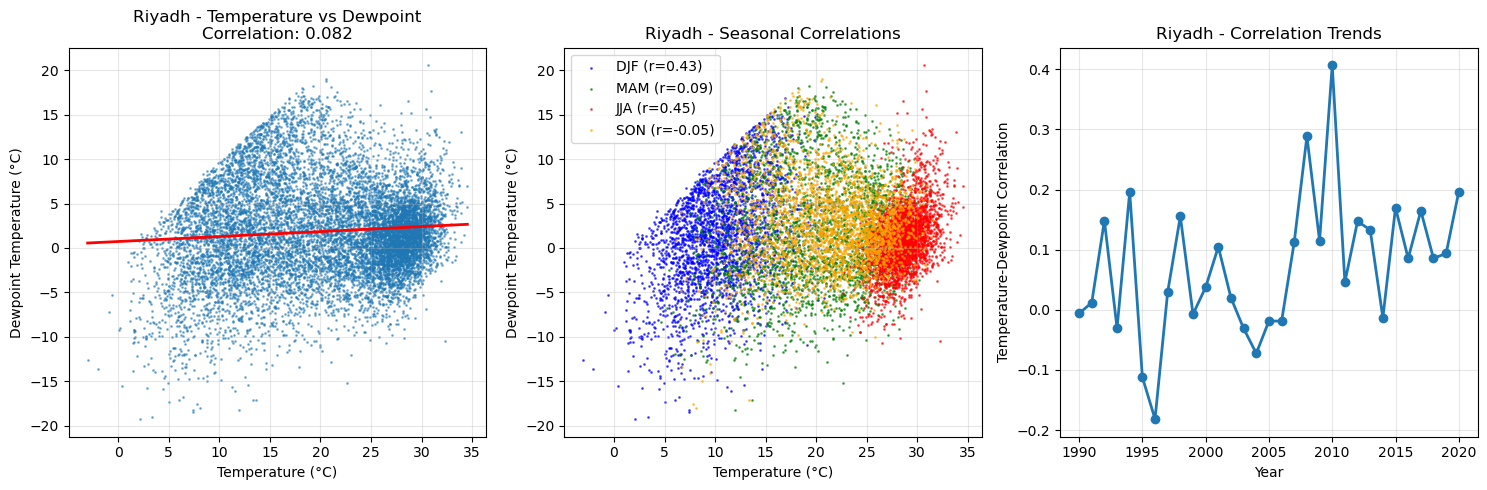


Riyadh Temperature-Dewpoint Analysis:
Overall correlation: 0.082
Mean annual correlation: 0.073

4. Trend Analysis with Statistical Significance


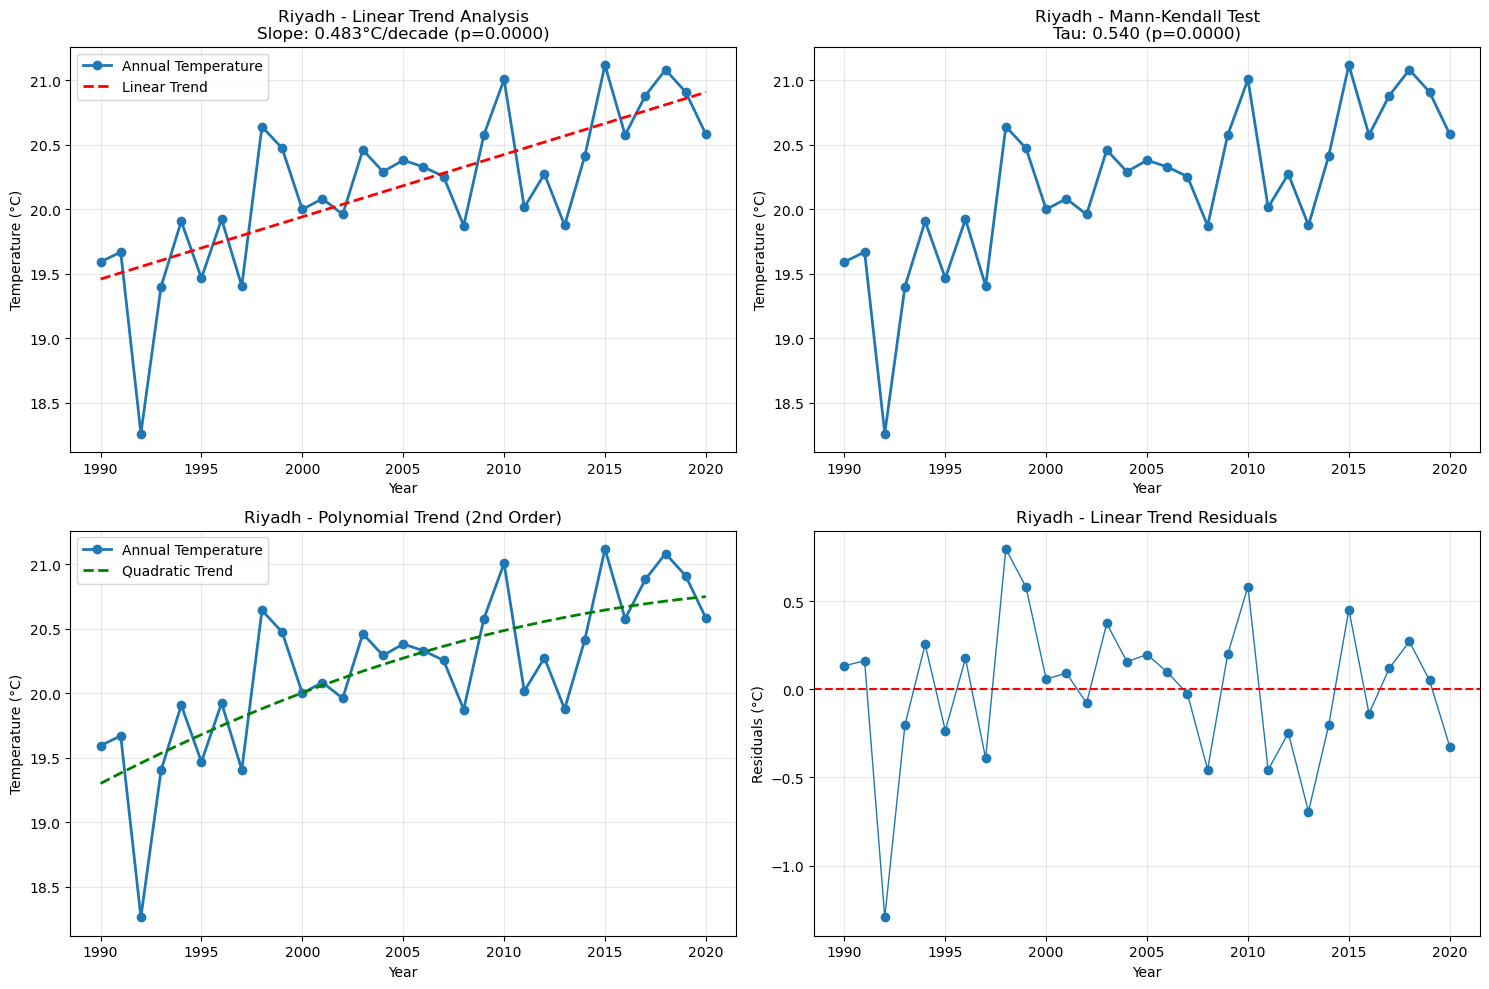


Riyadh Trend Analysis Results:
Linear trend: 0.483°C/decade
R-squared: 0.533
P-value (linear): 0.0000
Standard error: 0.084°C/decade
✓ Linear trend is statistically significant (p < 0.05)
✓ Mann-Kendall trend is statistically significant (p < 0.05)


In [44]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats


# 1. Distribution Changes by Decade
def plot_distribution_changes(ds, city_name):
    """Compare temperature distributions between decades"""
    
    # Calculate daily spatial means
    daily_temp = ds['t2m'].mean(['latitude', 'longitude'])
    
    # Split by decades
    temp_1990s = daily_temp.sel(time=slice('1990', '1999'))
    temp_2000s = daily_temp.sel(time=slice('2000', '2009'))
    temp_2010s = daily_temp.sel(time=slice('2010', '2020'))
    
    plt.figure(figsize=(12, 8))
    
    # Histograms
    plt.subplot(2, 2, 1)
    plt.hist(temp_1990s, bins=50, alpha=0.7, label='1990s', density=True)
    plt.hist(temp_2000s, bins=50, alpha=0.7, label='2000s', density=True)
    plt.hist(temp_2010s, bins=50, alpha=0.7, label='2010s', density=True)
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Density')
    plt.title(f'{city_name} - Temperature Distribution by Decade')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Box plots
    plt.subplot(2, 2, 2)
    data = [temp_1990s.values, temp_2000s.values, temp_2010s.values]
    plt.boxplot(data, labels=['1990s', '2000s', '2010s'])
    plt.ylabel('Temperature (°C)')
    plt.title(f'{city_name} - Temperature Distribution Box Plots')
    plt.grid(True, alpha=0.3)
    
    # Statistics comparison
    plt.subplot(2, 2, 3)
    decades = ['1990s', '2000s', '2010s']
    means = [temp_1990s.mean().values, temp_2000s.mean().values, temp_2010s.mean().values]
    stds = [temp_1990s.std().values, temp_2000s.std().values, temp_2010s.std().values]
    
    x_pos = np.arange(len(decades))
    plt.bar(x_pos, means, yerr=stds, alpha=0.7, capsize=5)
    plt.xlabel('Decade')
    plt.ylabel('Temperature (°C)')
    plt.title(f'{city_name} - Mean Temperature by Decade')
    plt.xticks(x_pos, decades)
    plt.grid(True, alpha=0.3)
    
    # Q-Q plot for normality check
    plt.subplot(2, 2, 4)
    stats.probplot(daily_temp.values, dist="norm", plot=plt)
    plt.title(f'{city_name} - Q-Q Plot (Normality Check)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{city_name} Decade Statistics:")
    print(f"1990s: Mean={temp_1990s.mean().values:.2f}°C, Std={temp_1990s.std().values:.2f}°C")
    print(f"2000s: Mean={temp_2000s.mean().values:.2f}°C, Std={temp_2000s.std().values:.2f}°C")
    print(f"2010s: Mean={temp_2010s.mean().values:.2f}°C, Std={temp_2010s.std().values:.2f}°C")
    
    return temp_1990s, temp_2000s, temp_2010s

# 2. Percentile Trends
def plot_percentile_trends(ds, city_name):
    """Plot how extreme percentiles change over time"""
    
    # Calculate daily spatial means
    daily_temp = ds['t2m'].mean(['latitude', 'longitude'])
    
    # Calculate annual percentiles
    percentiles = [5, 10, 25, 50, 75, 90, 95, 99]
    annual_percentiles = {}
    
    for p in percentiles:
        annual_percentiles[p] = daily_temp.groupby('time.year').quantile(p/100)
    
    plt.figure(figsize=(15, 10))
    
    # Plot all percentiles
    plt.subplot(2, 2, 1)
    colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(percentiles)))
    
    for i, p in enumerate(percentiles):
        plt.plot(annual_percentiles[p].year, annual_percentiles[p], 
                'o-', color=colors[i], label=f'{p}th', linewidth=1.5)
    
    plt.xlabel('Year')
    plt.ylabel('Temperature (°C)')
    plt.title(f'{city_name} - Temperature Percentile Trends')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Focus on extreme percentiles
    plt.subplot(2, 2, 2)
    extreme_percentiles = [95, 99]
    for p in extreme_percentiles:
        plt.plot(annual_percentiles[p].year, annual_percentiles[p], 
                'o-', label=f'{p}th percentile', linewidth=2)
        
        # Add trend line
        z = np.polyfit(annual_percentiles[p].year.values, annual_percentiles[p].values, 1)
        trend_line = np.poly1d(z)
        plt.plot(annual_percentiles[p].year, trend_line(annual_percentiles[p].year), 
                '--', alpha=0.7)
        
        trend_per_decade = z[0] * 10
        print(f"{city_name} {p}th percentile trend: {trend_per_decade:.2f}°C/decade")
    
    plt.xlabel('Year')
    plt.ylabel('Temperature (°C)')
    plt.title(f'{city_name} - Extreme Temperature Trends')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Percentile range (spread)
    plt.subplot(2, 2, 3)
    temp_range = annual_percentiles[95] - annual_percentiles[5]
    plt.plot(temp_range.year, temp_range, 'o-', linewidth=2, color='purple')
    plt.xlabel('Year')
    plt.ylabel('Temperature Range (°C)')
    plt.title(f'{city_name} - Temperature Variability (95th-5th percentile)')
    plt.grid(True, alpha=0.3)
    
    # Monthly percentile trends
    plt.subplot(2, 2, 4)
    monthly_95th = daily_temp.groupby('time.month').quantile(0.95)
    
    months = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
    plt.plot(range(1, 13), monthly_95th, 'o-', linewidth=2)
    plt.xlabel('Month')
    plt.ylabel('95th Percentile Temperature (°C)')
    plt.title(f'{city_name} - Seasonal 95th Percentile')
    plt.xticks(range(1, 13), months)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return annual_percentiles

# 3. Correlation Analysis
def plot_temperature_dewpoint_correlation(ds, city_name):
    """Analyze temperature vs dewpoint relationships"""
    
    # Calculate daily spatial means
    daily_temp = ds['t2m'].mean(['latitude', 'longitude'])
    daily_dewpoint = ds['d2m'].mean(['latitude', 'longitude'])
    
    plt.figure(figsize=(15, 5))
    
    # Overall correlation
    plt.subplot(1, 3, 1)
    plt.scatter(daily_temp, daily_dewpoint, alpha=0.5, s=1)
    
    # Calculate correlation
    correlation = np.corrcoef(daily_temp.values, daily_dewpoint.values)[0, 1]
    
    # Add trend line
    z = np.polyfit(daily_temp.values, daily_dewpoint.values, 1)
    trend_line = np.poly1d(z)
    temp_range = np.linspace(daily_temp.min().values, daily_temp.max().values, 100)
    plt.plot(temp_range, trend_line(temp_range), 'r-', linewidth=2)
    
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Dewpoint Temperature (°C)')
    plt.title(f'{city_name} - Temperature vs Dewpoint\nCorrelation: {correlation:.3f}')
    plt.grid(True, alpha=0.3)
    
    # Seasonal correlation
    plt.subplot(1, 3, 2)
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    season_months = [[12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]
    colors = ['blue', 'green', 'red', 'orange']
    
    for i, (season, months) in enumerate(zip(seasons, season_months)):
        season_mask = daily_temp.time.dt.month.isin(months)
        season_temp = daily_temp.where(season_mask, drop=True)
        season_dewpoint = daily_dewpoint.where(season_mask, drop=True)
        
        season_corr = np.corrcoef(season_temp.values, season_dewpoint.values)[0, 1]
        plt.scatter(season_temp, season_dewpoint, alpha=0.6, s=1, 
                   color=colors[i], label=f'{season} (r={season_corr:.2f})')
    
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Dewpoint Temperature (°C)')
    plt.title(f'{city_name} - Seasonal Correlations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Correlation over time
    plt.subplot(1, 3, 3)
    annual_corr = []
    years = []
    
    for year in range(1990, 2021):
        year_temp = daily_temp.sel(time=str(year))
        year_dewpoint = daily_dewpoint.sel(time=str(year))
        
        if len(year_temp) > 0:
            corr = np.corrcoef(year_temp.values, year_dewpoint.values)[0, 1]
            annual_corr.append(corr)
            years.append(year)
    
    plt.plot(years, annual_corr, 'o-', linewidth=2)
    plt.xlabel('Year')
    plt.ylabel('Temperature-Dewpoint Correlation')
    plt.title(f'{city_name} - Correlation Trends')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{city_name} Temperature-Dewpoint Analysis:")
    print(f"Overall correlation: {correlation:.3f}")
    print(f"Mean annual correlation: {np.mean(annual_corr):.3f}")
    
    return correlation

# 4. Trend Analysis with Statistical Significance
def analyze_trends_with_significance(ds, city_name):
    """Perform comprehensive trend analysis"""
    
    # Calculate daily spatial means
    daily_temp = ds['t2m'].mean(['latitude', 'longitude'])
    annual_temp = daily_temp.groupby('time.year').mean()
    
    plt.figure(figsize=(15, 10))
    
    # Linear trend
    plt.subplot(2, 2, 1)
    x = annual_temp.year.values
    y = annual_temp.values
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    trend_line = slope * x + intercept
    
    plt.plot(x, y, 'o-', linewidth=2, label='Annual Temperature')
    plt.plot(x, trend_line, 'r--', linewidth=2, label=f'Linear Trend')
    
    plt.xlabel('Year')
    plt.ylabel('Temperature (°C)')
    plt.title(f'{city_name} - Linear Trend Analysis\nSlope: {slope*10:.3f}°C/decade (p={p_value:.4f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Mann-Kendall trend test
    plt.subplot(2, 2, 2)
    from scipy.stats import kendalltau
    tau, mk_p_value = kendalltau(x, y)
    
    plt.plot(x, y, 'o-', linewidth=2)
    plt.xlabel('Year')
    plt.ylabel('Temperature (°C)')
    plt.title(f'{city_name} - Mann-Kendall Test\nTau: {tau:.3f} (p={mk_p_value:.4f})')
    plt.grid(True, alpha=0.3)
    
    # Polynomial trend (2nd order)
    plt.subplot(2, 2, 3)
    poly_coeffs = np.polyfit(x, y, 2)
    poly_trend = np.polyval(poly_coeffs, x)
    
    plt.plot(x, y, 'o-', linewidth=2, label='Annual Temperature')
    plt.plot(x, poly_trend, 'g--', linewidth=2, label='Quadratic Trend')
    
    plt.xlabel('Year')
    plt.ylabel('Temperature (°C)')
    plt.title(f'{city_name} - Polynomial Trend (2nd Order)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Residuals analysis
    plt.subplot(2, 2, 4)
    residuals = y - trend_line
    plt.plot(x, residuals, 'o-', linewidth=1)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel('Residuals (°C)')
    plt.title(f'{city_name} - Linear Trend Residuals')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistical results
    print(f"\n{city_name} Trend Analysis Results:")
    print(f"Linear trend: {slope*10:.3f}°C/decade")
    print(f"R-squared: {r_value**2:.3f}")
    print(f"P-value (linear): {p_value:.4f}")
    print(f"Standard error: {std_err*10:.3f}°C/decade")
    
    if p_value < 0.05:
        print("✓ Linear trend is statistically significant (p < 0.05)")
    else:
        print("✗ Linear trend is not statistically significant (p >= 0.05)")
        
    if mk_p_value < 0.05:
        print("✓ Mann-Kendall trend is statistically significant (p < 0.05)")
    else:
        print("✗ Mann-Kendall trend is not statistically significant (p >= 0.05)")
    
    return slope, p_value, mk_p_value

# Run all statistical analyses
if __name__ == "__main__":
    
    print("=== Statistical Analysis ===\n")
    
    for ds, city in [(ds_jeddah, "Jeddah"), (ds_riyadh, "Riyadh")]:
        
        print(f"\n--- {city} Statistical Analysis ---")
        
        # 1. Distribution changes
        print("1. Distribution Changes by Decade")
        decades = plot_distribution_changes(ds, city)
        
        # 2. Percentile trends
        print("\n2. Percentile Trends")
        percentiles = plot_percentile_trends(ds, city)
        
        # 3. Correlation analysis
        print("\n3. Temperature-Dewpoint Correlation")
        correlation = plot_temperature_dewpoint_correlation(ds, city)
        
        # 4. Trend analysis
        print("\n4. Trend Analysis with Statistical Significance")
        trends = analyze_trends_with_significance(ds, city)

## Downloading model data

We will download model data for the historical period `1985-2015` and future period `2070-2100`  
uisng three different future scenarios: 
- SSP 1_2_6
- SSP 2_4_5
- SSP 5_8_5




In [49]:
import pandas as pd
import xarray as xr
import gcsfs
import os
import glob

# Configuration
models = ['ACCESS-CM2', 'EC-Earth3', 'MPI-ESM1-2-HR']
variables = ['tas', 'hurs']
scenarios = ['historical']  # Only historical for now

# Extended time period
years_hist = list(range(1985, 2016))  # 1985-2015 (31 years)

# Saudi Arabia boundaries
lat_bnds = [16.0, 32.0]  # [South, North]
lon_bnds = [34.0, 55.0]  # [West, East]

# City coordinates
cities = {
    'jeddah': {'lat': 21.5, 'lon': 39.2},
    'riyadh': {'lat': 24.7, 'lon': 46.7}
}

def delete_historical_files():
    """Delete all existing historical files"""
    
    print("=== Deleting Existing Historical Files ===\n")
    
    # Delete regional files
    regional_files = glob.glob('cmip6_google_cloud/*_historical_*.nc')
    print(f"Found {len(regional_files)} regional historical files to delete:")
    
    for file in regional_files:
        print(f"Deleting: {file}")
        os.remove(file)
    
    # Delete city-specific files
    city_files = glob.glob('cmip6_cities/*_historical_*.nc')
    print(f"\nFound {len(city_files)} city historical files to delete:")
    
    for file in city_files:
        print(f"Deleting: {file}")
        os.remove(file)
    
    print(f"\n✓ Deleted {len(regional_files) + len(city_files)} historical files")

def download_cmip6_historical_extended():
    """Download CMIP6 historical data for 1985-2015"""
    
    print("\n=== Downloading CMIP6 Historical Data (1985-2015) ===\n")
    
    # Load catalog
    url_catalog = 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv'
    df_catalog = pd.read_csv(url_catalog)
    
    # Authenticate to Google Cloud
    gcs = gcsfs.GCSFileSystem(token='anon')
    
    # Create output directory
    os.makedirs('cmip6_google_cloud', exist_ok=True)
    
    downloaded_files = []
    
    for model in models:
        print(f"\n--- Processing {model} ---")
        
        for variable in variables:
            print(f"\nVariable: {variable}")
            
            # Search for this model and variable
            search_string = f"table_id == 'day' & source_id == '{model}' & variable_id == '{variable}'"
            search_string += f" & experiment_id == 'historical'"
            
            try:
                df_search = df_catalog.query(search_string)
                
                if df_search.empty:
                    print(f"  ⚠️  No data found for {model} - {variable}")
                    continue
                
                # Get available ensemble members
                available_members = df_search.member_id.unique()
                print(f"  Available ensemble members: {list(available_members)}")
                
                # Use first available ensemble member
                member = available_members[0]
                df_member = df_search.query(f"member_id == '{member}'")
                
                print(f"  Using ensemble member: {member}")
                
                # Get historical data
                hist_data = df_member[df_member.experiment_id == 'historical']
                
                if hist_data.empty:
                    print(f"    ⚠️  No historical data for {model} - {variable}")
                    continue
                
                print(f"    Downloading historical (1985-2015)...")
                
                try:
                    # Get the zarr store URL
                    url_zarr = hist_data.zstore.values[0]
                    mapper = gcs.get_mapper(url_zarr)
                    
                    # Open dataset with proper time handling
                    ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)
                    
                    # Select our variable and region
                    var_data = ds_raw[variable].sel(
                        lat=slice(*lat_bnds), 
                        lon=slice(*lon_bnds)
                    )
                    
                    # Select extended time period (1985-2015)
                    time_mask = (var_data.time.dt.year >= 1985) & (var_data.time.dt.year <= 2015)
                    var_data = var_data.where(time_mask, drop=True)
                    
                    # Check if we have any data after time filtering
                    if len(var_data.time) == 0:
                        print(f"    ⚠️  No data in 1985-2015 range for {model} - {variable}")
                        continue
                    
                    # Convert temperature to Celsius if needed
                    if variable == 'tas' and hasattr(var_data, 'attrs') and var_data.attrs.get('units') == 'K':
                        var_data = var_data - 273.15
                        var_data.attrs['units'] = 'degC'
                    
                    # Save to netCDF
                    output_file = f'cmip6_google_cloud/{model}_{variable}_historical_1985_2015.nc'
                    var_data.to_netcdf(output_file)
                    downloaded_files.append(output_file)
                    
                    print(f"    ✓ Saved: {output_file}")
                    print(f"      Shape: {var_data.shape}")
                    
                    if len(var_data.time) > 0:
                        print(f"      Years covered: {var_data.time.dt.year.min().values} to {var_data.time.dt.year.max().values}")
                        print(f"      Total years: {len(var_data.groupby('time.year'))}")
                    
                except Exception as e:
                    print(f"    ✗ Error downloading historical: {e}")
                
            except Exception as e:
                print(f"  ✗ Error processing {model} - {variable}: {e}")
    
    return downloaded_files

def create_city_specific_data_extended(downloaded_files):
    """Create city-specific datasets from the new downloads"""
    
    print("\n=== Creating City-Specific Datasets (1985-2015) ===")
    
    os.makedirs('cmip6_cities', exist_ok=True)
    
    for file_path in downloaded_files:
        filename = os.path.basename(file_path)
        print(f"\nProcessing: {filename}")
        
        try:
            # Load the regional data
            ds = xr.open_dataset(file_path)
            
            # Extract city data (nearest grid point)
            for city, coords in cities.items():
                city_data = ds.sel(lat=coords['lat'], lon=coords['lon'], method='nearest')
                
                # Save city-specific file
                city_file = f'cmip6_cities/{filename.replace(".nc", f"_{city}.nc")}'
                city_data.to_netcdf(city_file)
                
                print(f"  ✓ {city}: {city_file}")
                print(f"    Coordinates: lat={city_data.lat.values:.2f}, lon={city_data.lon.values:.2f}")
                print(f"    Time span: {city_data.time.dt.year.min().values} to {city_data.time.dt.year.max().values}")
            
            ds.close()
            
        except Exception as e:
            print(f"  ✗ Error processing {filename}: {e}")

def check_new_data_coverage():
    """Check the coverage of newly downloaded data"""
    
    print("\n=== Data Coverage Check ===")
    
    # Check what files we have
    regional_files = glob.glob('cmip6_google_cloud/*_historical_1985_2015.nc')
    city_files = glob.glob('cmip6_cities/*_historical_1985_2015_*.nc')
    
    print(f"Regional files: {len(regional_files)}")
    print(f"City files: {len(city_files)}")
    
    # Expected files
    expected_regional = len(models) * len(variables)  # 3 models × 2 variables = 6
    expected_city = expected_regional * len(cities)   # 6 × 2 cities = 12
    
    print(f"\nExpected vs Actual:")
    print(f"Regional files: {len(regional_files)}/{expected_regional}")
    print(f"City files: {len(city_files)}/{expected_city}")
    
    # List downloaded files
    print(f"\nDownloaded regional files:")
    for file in sorted(regional_files):
        print(f"  - {os.path.basename(file)}")
    
    return len(regional_files) == expected_regional

def main():
    """Main function to delete and re-download historical data"""
    
    print("=== CMIP6 Historical Data Re-download (1985-2015) ===")
    print(f"Models: {models}")
    print(f"Variables: {variables}")
    print(f"New time period: 1985-2015 ({len(years_hist)} years)")
    print(f"Target cities: {list(cities.keys())}")
    
    # Step 1: Delete existing historical files
    delete_historical_files()
    
    # Step 2: Download new historical data (1985-2015)
    downloaded_files = download_cmip6_historical_extended()
    
    # Step 3: Create city-specific files
    if downloaded_files:
        create_city_specific_data_extended(downloaded_files)
    
    # Step 4: Check coverage
    success = check_new_data_coverage()
    
    print(f"\n=== Summary ===")
    if success:
        print("✅ Successfully re-downloaded all historical data for 1985-2015!")
        print("✅ Historical data now spans 31 years instead of 25 years")
        print("✅ Better temporal alignment with extended ERA5-Land data")
    else:
        print("⚠️  Some files may be missing - check the output above")
    
    print(f"\nNext steps:")
    print("1. Download ERA5-Land data for 1985-2015")
    print("2. Use common period 1985-2014 for training")
    print("3. Use 2015 for validation (if available)")
    print("4. Proceed with downscaling analysis")

if __name__ == "__main__":
    main()

=== CMIP6 Historical Data Re-download (1985-2015) ===
Models: ['ACCESS-CM2', 'EC-Earth3', 'MPI-ESM1-2-HR']
Variables: ['tas', 'hurs']
New time period: 1985-2015 (31 years)
Target cities: ['jeddah', 'riyadh']
=== Deleting Existing Historical Files ===

Found 6 regional historical files to delete:
Deleting: cmip6_google_cloud/ACCESS-CM2_hurs_historical_1990_2020.nc
Deleting: cmip6_google_cloud/ACCESS-CM2_tas_historical_1990_2020.nc
Deleting: cmip6_google_cloud/EC-Earth3_hurs_historical_1990_2020.nc
Deleting: cmip6_google_cloud/EC-Earth3_tas_historical_1990_2020.nc
Deleting: cmip6_google_cloud/MPI-ESM1-2-HR_hurs_historical_1990_2020.nc
Deleting: cmip6_google_cloud/MPI-ESM1-2-HR_tas_historical_1990_2020.nc

Found 12 city historical files to delete:
Deleting: cmip6_cities/ACCESS-CM2_hurs_historical_1990_2020_jeddah.nc
Deleting: cmip6_cities/ACCESS-CM2_hurs_historical_1990_2020_riyadh.nc
Deleting: cmip6_cities/ACCESS-CM2_tas_historical_1990_2020_jeddah.nc
Deleting: cmip6_cities/ACCESS-CM2_ta

/tmp/ipykernel_35/3258762247.py:107: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


    ✓ Saved: cmip6_google_cloud/ACCESS-CM2_tas_historical_1985_2015.nc
      Shape: (10957, 13, 11)
      Years covered: 1985 to 2014
      Total years: 30

Variable: hurs
  Available ensemble members: ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1']
  Using ensemble member: r1i1p1f1


/tmp/ipykernel_35/3258762247.py:107: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


    ✓ Saved: cmip6_google_cloud/ACCESS-CM2_hurs_historical_1985_2015.nc
      Shape: (10957, 13, 11)
      Years covered: 1985 to 2014
      Total years: 30

--- Processing EC-Earth3 ---

Variable: tas
  Available ensemble members: ['r9i1p1f1', 'r6i1p1f1', 'r11i1p1f1', 'r15i1p1f1', 'r13i1p1f1', 'r22i1p1f1', 'r25i1p1f1', 'r23i1p1f1', 'r1i1p1f1', 'r2i1p1f1', 'r12i1p1f1', 'r24i1p1f1', 'r117i1p1f1', 'r118i1p1f1', 'r119i1p1f1', 'r121i1p1f1', 'r125i1p1f1', 'r126i1p1f1', 'r120i1p1f1', 'r106i1p1f1', 'r104i1p1f1', 'r148i1p1f1', 'r105i1p1f1', 'r150i1p1f1', 'r101i1p1f1', 'r149i1p1f1', 'r102i1p1f1', 'r103i1p1f1', 'r135i1p1f1', 'r136i1p1f1', 'r129i1p1f1', 'r133i1p1f1', 'r137i1p1f1', 'r144i1p1f1', 'r143i1p1f1', 'r145i1p1f1', 'r128i1p1f1', 'r131i1p1f1', 'r130i1p1f1', 'r132i1p1f1', 'r134i1p1f1', 'r108i1p1f1', 'r107i1p1f1', 'r112i1p1f1', 'r116i1p1f1', 'r115i1p1f1', 'r114i1p1f1', 'r124i1p1f1', 'r122i1p1f1', 'r123i1p1f1', 'r111i1p1f1', 'r109i1p1f1', 'r110i1p1f1', 'r139i1p1f1', 'r146i1p1f1', 'r138i1p1f1',

/tmp/ipykernel_35/3258762247.py:107: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


    ✓ Saved: cmip6_google_cloud/EC-Earth3_tas_historical_1985_2015.nc
      Shape: (10957, 23, 30)
      Years covered: 1985 to 2014
      Total years: 30

Variable: hurs
  Available ensemble members: ['r9i1p1f1', 'r6i1p1f1', 'r11i1p1f1', 'r15i1p1f1', 'r13i1p1f1', 'r22i1p1f1', 'r25i1p1f1', 'r23i1p1f1', 'r1i1p1f1', 'r12i1p1f1', 'r19i1p1f1', 'r21i1p1f1', 'r24i1p1f1', 'r119i1p1f1', 'r118i1p1f1', 'r117i1p1f1', 'r127i1p1f1', 'r126i1p1f1', 'r122i1p1f1', 'r125i1p1f1', 'r121i1p1f1', 'r120i1p1f1', 'r148i1p1f1', 'r106i1p1f1', 'r105i1p1f1', 'r149i1p1f1', 'r101i1p1f1', 'r150i1p1f1', 'r103i1p1f1', 'r104i1p1f1', 'r102i1p1f1', 'r129i1p1f1', 'r136i1p1f1', 'r135i1p1f1', 'r137i1p1f1', 'r131i1p1f1', 'r144i1p1f1', 'r143i1p1f1', 'r145i1p1f1', 'r128i1p1f1', 'r130i1p1f1', 'r132i1p1f1', 'r133i1p1f1', 'r134i1p1f1', 'r108i1p1f1', 'r107i1p1f1', 'r116i1p1f1', 'r114i1p1f1', 'r115i1p1f1', 'r124i1p1f1', 'r123i1p1f1', 'r111i1p1f1', 'r110i1p1f1', 'r109i1p1f1', 'r139i1p1f1', 'r146i1p1f1', 'r138i1p1f1', 'r140i1p1f1', 'r

/tmp/ipykernel_35/3258762247.py:107: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


    ✓ Saved: cmip6_google_cloud/EC-Earth3_hurs_historical_1985_2015.nc
      Shape: (10957, 23, 30)
      Years covered: 1985 to 2014
      Total years: 30

--- Processing MPI-ESM1-2-HR ---

Variable: tas
  Available ensemble members: ['r3i1p1f1', 'r2i1p1f1', 'r8i1p1f1', 'r10i1p1f1', 'r1i1p1f1', 'r9i1p1f1', 'r6i1p1f1', 'r7i1p1f1', 'r4i1p1f1', 'r5i1p1f1']
  Using ensemble member: r3i1p1f1


/tmp/ipykernel_35/3258762247.py:107: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


    ✓ Saved: cmip6_google_cloud/MPI-ESM1-2-HR_tas_historical_1985_2015.nc
      Shape: (10957, 17, 22)
      Years covered: 1985 to 2014
      Total years: 30

Variable: hurs
  Available ensemble members: ['r3i1p1f1', 'r2i1p1f1', 'r10i1p1f1', 'r1i1p1f1', 'r8i1p1f1', 'r9i1p1f1', 'r4i1p1f1', 'r6i1p1f1', 'r5i1p1f1', 'r7i1p1f1']
  Using ensemble member: r3i1p1f1


/tmp/ipykernel_35/3258762247.py:107: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


    ✓ Saved: cmip6_google_cloud/MPI-ESM1-2-HR_hurs_historical_1985_2015.nc
      Shape: (10957, 17, 22)
      Years covered: 1985 to 2014
      Total years: 30

=== Creating City-Specific Datasets (1985-2015) ===

Processing: ACCESS-CM2_tas_historical_1985_2015.nc
  ✓ jeddah: cmip6_cities/ACCESS-CM2_tas_historical_1985_2015_jeddah.nc
    Coordinates: lat=21.88, lon=38.44
    Time span: 1985 to 2014
  ✓ riyadh: cmip6_cities/ACCESS-CM2_tas_historical_1985_2015_riyadh.nc
    Coordinates: lat=24.38, lon=45.94
    Time span: 1985 to 2014

Processing: ACCESS-CM2_hurs_historical_1985_2015.nc
  ✓ jeddah: cmip6_cities/ACCESS-CM2_hurs_historical_1985_2015_jeddah.nc
    Coordinates: lat=21.88, lon=38.44
    Time span: 1985 to 2014
  ✓ riyadh: cmip6_cities/ACCESS-CM2_hurs_historical_1985_2015_riyadh.nc
    Coordinates: lat=24.38, lon=45.94
    Time span: 1985 to 2014

Processing: EC-Earth3_tas_historical_1985_2015.nc
  ✓ jeddah: cmip6_cities/EC-Earth3_tas_historical_1985_2015_jeddah.nc
    Coordin

## CDDs and wet-bulb heat studies on Jeddah and Riyadh

### Downloading tasmin data for CMIP6 Models 

Here we will download tasmin data (daily minimum temprature) for CMIP6 models to better align the ERA5 reanalysis
data collectd at 3 am local time in Saudi Arabia

In [83]:
import pandas as pd
import gcsfs

def check_model_data_availability():
    """Check which models have complete data for our needs"""
    
    print("=== Checking CMIP6 Model Data Availability ===\n")
    
    # Load catalog
    url_catalog = 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv'
    df_catalog = pd.read_csv(url_catalog)
    
    # Our requirements
    required_variables = ['tas', 'tasmin', 'hurs']
    required_experiments = ['historical', 'ssp126', 'ssp245', 'ssp585']
    
    # Filter for daily data
    df_daily = df_catalog[df_catalog.table_id == 'day']
    
    # Get all available models
    all_models = df_daily.source_id.unique()
    print(f"Total models available: {len(all_models)}")
    
    # Check each model
    good_models = []
    
    for model in sorted(all_models):
        print(f"\nChecking {model}...")
        
        model_data = df_daily[df_daily.source_id == model]
        
        # Check variables
        available_vars = set(model_data.variable_id.unique())
        missing_vars = set(required_variables) - available_vars
        
        # Check experiments
        available_exps = set(model_data.experiment_id.unique())
        missing_exps = set(required_experiments) - available_exps
        
        # Print status
        print(f"  Variables: {sorted(list(available_vars & set(required_variables)))}")
        if missing_vars:
            print(f"  Missing vars: {sorted(list(missing_vars))}")
        
        print(f"  Experiments: {sorted(list(available_exps & set(required_experiments)))}")
        if missing_exps:
            print(f"  Missing exps: {sorted(list(missing_exps))}")
        
        # Check if model has everything we need
        if not missing_vars and not missing_exps:
            good_models.append(model)
            print(f"  ✅ COMPLETE - Has all required data")
        else:
            print(f"  ❌ INCOMPLETE")
    
    print(f"\n{'='*60}")
    print(f"MODELS WITH COMPLETE DATA ({len(good_models)} found):")
    print(f"{'='*60}")
    
    for i, model in enumerate(good_models[:15], 1):  # Show first 15
        print(f"{i:2d}. {model}")
    
    if len(good_models) > 15:
        print(f"    ... and {len(good_models)-15} more")
    
    return good_models

def recommend_models(good_models):
    """Recommend 3 best models from the complete list"""
    
    # Prioritized list of high-quality models
    preferred_models = [
        'GFDL-ESM4',     # Excellent US model
        'MIROC6',        # Good Japanese model  
        'CanESM5',       # Reliable Canadian model
        'CNRM-CM6-1',    # Good European model
        'IPSL-CM6A-LR',  # French model
        'UKESM1-0-LL',   # UK Earth System Model
        'CESM2',         # US Community model
        'NorESM2-LM',    # Norwegian model
        'MPI-ESM1-2-HR', # Already working for you
        'EC-Earth3',     # Already working for you
        'ACCESS-ESM1-5', # Alternative to ACCESS-CM2
    ]
    
    # Find intersection of preferred and available
    available_preferred = [m for m in preferred_models if m in good_models]
    
    print(f"\n{'='*60}")
    print("RECOMMENDED MODELS (Top 3):")
    print(f"{'='*60}")
    
    recommendations = available_preferred[:3]
    for i, model in enumerate(recommendations, 1):
        print(f"{i}. {model}")
    
    print(f"\nCurrent working models: EC-Earth3, MPI-ESM1-2-HR")
    print(f"Recommended replacement for ACCESS-CM2: {recommendations[0] if recommendations else 'See full list above'}")
    
    return recommendations

if __name__ == "__main__":
    print("Checking data availability for variables: tas, tasmin, hurs")
    print("Checking experiments: historical, ssp126, ssp245, ssp585")
    print("This may take a minute...\n")
    
    good_models = check_model_data_availability()
    recommendations = recommend_models(good_models)
    
    print(f"\n{'='*60}")
    print("SUMMARY:")
    print(f"{'='*60}")
    print(f"✅ Found {len(good_models)} models with complete data")
    print(f"🎯 Top recommendation: {recommendations[0] if recommendations else 'Check list above'}")
    print(f"📋 Use this model instead of ACCESS-CM2 in your scripts")

Checking data availability for variables: tas, tasmin, hurs
Checking experiments: historical, ssp126, ssp245, ssp585
This may take a minute...

=== Checking CMIP6 Model Data Availability ===

Total models available: 66

Checking ACCESS-CM2...
  Variables: ['hurs', 'tas', 'tasmin']
  Experiments: ['historical', 'ssp126', 'ssp245', 'ssp585']
  ✅ COMPLETE - Has all required data

Checking ACCESS-ESM1-5...
  Variables: ['hurs', 'tas', 'tasmin']
  Experiments: ['historical', 'ssp126', 'ssp585']
  Missing exps: ['ssp245']
  ❌ INCOMPLETE

Checking AWI-CM-1-1-MR...
  Variables: ['hurs', 'tas', 'tasmin']
  Experiments: ['historical', 'ssp126', 'ssp245', 'ssp585']
  ✅ COMPLETE - Has all required data

Checking AWI-ESM-1-1-LR...
  Variables: ['hurs', 'tas', 'tasmin']
  Experiments: ['historical']
  Missing exps: ['ssp126', 'ssp245', 'ssp585']
  ❌ INCOMPLETE

Checking BCC-CSM2-MR...
  Variables: ['hurs', 'tas', 'tasmin']
  Experiments: ['historical', 'ssp126', 'ssp245', 'ssp585']
  ✅ COMPLETE - Ha

In [84]:
import pandas as pd
import xarray as xr
import gcsfs
import os

# Configuration
models = ['GFDL-ESM4', 'EC-Earth3', 'MPI-ESM1-2-HR']  # Using top recommended model
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']
variable = 'tasmin'  # Daily minimum temperature

# Time periods
years_hist = list(range(1985, 2015))  # 1985-2014
years_future = list(range(2070, 2101))  # 2070-2100

# Saudi Arabia boundaries
lat_bnds = [16.0, 32.0]
lon_bnds = [34.0, 55.0]

# City coordinates
cities = {
    'jeddah': {'lat': 21.5, 'lon': 39.2},
    'riyadh': {'lat': 24.7, 'lon': 46.7}
}

def download_cmip6_tasmin():
    """Download CMIP6 tasmin data"""
    
    print("=== Downloading CMIP6 Daily Minimum Temperature (tasmin) ===\n")
    
    # Load catalog
    url_catalog = 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv'
    df_catalog = pd.read_csv(url_catalog)
    gcs = gcsfs.GCSFileSystem(token='anon')
    
    os.makedirs('cmip6_tasmin', exist_ok=True)
    
    for model in models:
        print(f"\n--- Processing {model} ---")
        
        # Search for tasmin data
        search_string = f"table_id == 'day' & source_id == '{model}' & variable_id == '{variable}'"
        search_string += f" & experiment_id == {scenarios}"
        
        try:
            df_search = df_catalog.query(search_string)
            
            if df_search.empty:
                print(f"  ⚠️  No tasmin data found for {model}")
                continue
            
            # Use first available ensemble member
            member = df_search.member_id.iloc[0]
            df_member = df_search.query(f"member_id == '{member}'")
            
            print(f"  Using ensemble member: {member}")
            
            # Download each scenario
            for scenario in scenarios:
                scenario_data = df_member[df_member.experiment_id == scenario]
                
                if scenario_data.empty:
                    print(f"    ⚠️  No {scenario} tasmin data for {model}")
                    continue
                
                print(f"    Downloading {scenario}...")
                
                try:
                    # Get zarr store URL
                    url_zarr = scenario_data.zstore.values[0]
                    mapper = gcs.get_mapper(url_zarr)
                    
                    # Open dataset
                    ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)
                    
                    # Select region and variable
                    var_data = ds_raw[variable].sel(
                        lat=slice(*lat_bnds), 
                        lon=slice(*lon_bnds)
                    )
                    
                    # Select time period
                    if scenario == 'historical':
                        time_mask = (var_data.time.dt.year >= 1985) & (var_data.time.dt.year <= 2014)
                        time_suffix = "1985_2014"
                    else:
                        time_mask = (var_data.time.dt.year >= 2070) & (var_data.time.dt.year <= 2100)
                        time_suffix = "2070_2100"
                    
                    var_data = var_data.where(time_mask, drop=True)
                    
                    if len(var_data.time) == 0:
                        print(f"      ⚠️  No data in time range")
                        continue
                    
                    # Convert to Celsius if needed
                    if var_data.attrs.get('units') == 'K':
                        var_data = var_data - 273.15
                        var_data.attrs['units'] = 'degC'
                    
                    # Save to netCDF
                    output_file = f'cmip6_tasmin/{model}_{variable}_{scenario}_{time_suffix}.nc'
                    
                    # Skip if file already exists
                    if os.path.exists(output_file):
                        print(f"      ✓ File already exists: {output_file} - Skipping download")
                        continue
                    
                    var_data.to_netcdf(output_file)
                    
                    print(f"      ✓ Saved: {output_file}")
                    print(f"        Years: {var_data.time.dt.year.min().values} to {var_data.time.dt.year.max().values}")
                    
                except Exception as e:
                    print(f"      ✗ Error: {e}")
                    
        except Exception as e:
            print(f"  ✗ Error processing {model}: {e}")

def create_city_tasmin_files():
    """Extract city-specific tasmin data"""
    
    print("\n=== Creating City-Specific tasmin Files ===")
    
    os.makedirs('cmip6_tasmin_cities', exist_ok=True)
    
    # Find all downloaded tasmin files
    tasmin_files = [f for f in os.listdir('cmip6_tasmin') if f.endswith('.nc')]
    
    for file in tasmin_files:
        print(f"\nProcessing: {file}")
        
        try:
            # Load regional data
            ds = xr.open_dataset(f'cmip6_tasmin/{file}')
            
            # Extract for each city
            for city, coords in cities.items():
                city_data = ds.sel(lat=coords['lat'], lon=coords['lon'], method='nearest')
                
                # Save city file
                city_file = f'cmip6_tasmin_cities/{file.replace(".nc", f"_{city}.nc")}'
                
                # Skip if city file already exists
                if os.path.exists(city_file):
                    print(f"  ✓ City file already exists: {city_file} - Skipping")
                    continue
                
                city_data.to_netcdf(city_file)
                
                print(f"  ✓ {city}: {city_file}")
                print(f"    Coordinates: lat={city_data.lat.values:.2f}, lon={city_data.lon.values:.2f}")
            
            ds.close()
            
        except Exception as e:
            print(f"  ✗ Error processing {file}: {e}")

def main():
    """Main function"""
    
    print("=== CMIP6 tasmin Download ===")
    print("Downloading daily minimum temperature to match ERA5 3 AM timing")
    print(f"Models: {models}")
    print(f"Scenarios: {scenarios}")
    print(f"Variable: {variable}")
    print()
    
    # Download regional tasmin data
    download_cmip6_tasmin()
    
    # Create city-specific files
    create_city_tasmin_files()
    
    print("\n=== Download Complete ===")
    print("✓ tasmin data downloaded for all models and scenarios")
    print("✓ City-specific files created")
    print("✓ Ready for comparison with ERA5 3 AM temperatures")
    
    # List what we have
    tasmin_files = [f for f in os.listdir('cmip6_tasmin_cities') if f.endswith('.nc')]
    print(f"\nDownloaded {len(tasmin_files)} city-specific tasmin files")

if __name__ == "__main__":
    main()

=== CMIP6 tasmin Download ===
Models: ['GFDL-ESM4', 'EC-Earth3', 'MPI-ESM1-2-HR']
Scenarios: ['historical', 'ssp126', 'ssp245', 'ssp585']
Variable: tasmin

=== Downloading CMIP6 Daily Minimum Temperature (tasmin) ===


--- Processing GFDL-ESM4 ---
  Using ensemble member: r2i1p1f1


/tmp/ipykernel_35/1495273305.py:73: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


      ✓ Saved: cmip6_tasmin/GFDL-ESM4_tasmin_historical_1985_2014.nc
        Years: 1985 to 2014
    ⚠️  No ssp126 tasmin data for GFDL-ESM4
    ⚠️  No ssp245 tasmin data for GFDL-ESM4
    ⚠️  No ssp585 tasmin data for GFDL-ESM4

--- Processing EC-Earth3 ---
  Using ensemble member: r6i1p1f1


/tmp/ipykernel_35/1495273305.py:73: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


      ✓ File already exists: cmip6_tasmin/EC-Earth3_tasmin_historical_1985_2014.nc - Skipping download


/tmp/ipykernel_35/1495273305.py:73: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


      ✓ File already exists: cmip6_tasmin/EC-Earth3_tasmin_ssp126_2070_2100.nc - Skipping download


/tmp/ipykernel_35/1495273305.py:73: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


      ✓ File already exists: cmip6_tasmin/EC-Earth3_tasmin_ssp245_2070_2100.nc - Skipping download


/tmp/ipykernel_35/1495273305.py:73: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


      ✓ File already exists: cmip6_tasmin/EC-Earth3_tasmin_ssp585_2070_2100.nc - Skipping download

--- Processing MPI-ESM1-2-HR ---
  Using ensemble member: r1i1p1f1


/tmp/ipykernel_35/1495273305.py:73: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


      ✓ File already exists: cmip6_tasmin/MPI-ESM1-2-HR_tasmin_historical_1985_2014.nc - Skipping download


/tmp/ipykernel_35/1495273305.py:73: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


      ✓ File already exists: cmip6_tasmin/MPI-ESM1-2-HR_tasmin_ssp126_2070_2100.nc - Skipping download


/tmp/ipykernel_35/1495273305.py:73: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


      ✓ File already exists: cmip6_tasmin/MPI-ESM1-2-HR_tasmin_ssp245_2070_2100.nc - Skipping download


/tmp/ipykernel_35/1495273305.py:73: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


      ✓ File already exists: cmip6_tasmin/MPI-ESM1-2-HR_tasmin_ssp585_2070_2100.nc - Skipping download

=== Creating City-Specific tasmin Files ===

Processing: ACCESS-CM2_tasmin_historical_1985_2014.nc
  ✓ City file already exists: cmip6_tasmin_cities/ACCESS-CM2_tasmin_historical_1985_2014_jeddah.nc - Skipping
  ✓ City file already exists: cmip6_tasmin_cities/ACCESS-CM2_tasmin_historical_1985_2014_riyadh.nc - Skipping

Processing: ACCESS-CM2_tasmin_ssp245_2070_2100.nc
  ✓ City file already exists: cmip6_tasmin_cities/ACCESS-CM2_tasmin_ssp245_2070_2100_jeddah.nc - Skipping
  ✓ City file already exists: cmip6_tasmin_cities/ACCESS-CM2_tasmin_ssp245_2070_2100_riyadh.nc - Skipping

Processing: ACCESS-CM2_tasmin_ssp585_2070_2100.nc
  ✓ City file already exists: cmip6_tasmin_cities/ACCESS-CM2_tasmin_ssp585_2070_2100_jeddah.nc - Skipping
  ✓ City file already exists: cmip6_tasmin_cities/ACCESS-CM2_tasmin_ssp585_2070_2100_riyadh.nc - Skipping

Processing: CESM2_tasmin_ssp126_2070_2100.nc
  ✓ j

In [85]:
import pandas as pd
import xarray as xr
import gcsfs
import os

def redownload_access_cm2_ssp126():
    """Specifically re-download ACCESS-CM2 SSP1-2.6 tasmin data"""
    
    print("=== Re-downloading ACCESS-CM2 SSP1-2.6 tasmin Data ===\n")
    
    # Load catalog
    url_catalog = 'https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv'
    df_catalog = pd.read_csv(url_catalog)
    gcs = gcsfs.GCSFileSystem(token='anon')
    
    # Create directories
    os.makedirs('cmip6_tasmin', exist_ok=True)
    os.makedirs('cmip6_tasmin_cities', exist_ok=True)
    
    # Search for ACCESS-CM2 tasmin SSP1-2.6 data
    search_string = "table_id == 'day' & source_id == 'ACCESS-CM2' & variable_id == 'tasmin' & experiment_id == 'ssp126'"
    
    print("Searching for ACCESS-CM2 tasmin ssp126 data...")
    df_search = df_catalog.query(search_string)
    
    print(f"Found {len(df_search)} datasets")
    
    if df_search.empty:
        print("❌ No ACCESS-CM2 tasmin ssp126 data found")
        return False
    
    # Show available ensemble members
    available_members = df_search.member_id.unique()
    print(f"Available ensemble members: {list(available_members)}")
    
    # Try different ensemble members
    for member in available_members:
        print(f"\nTrying ensemble member: {member}")
        
        member_data = df_search.query(f"member_id == '{member}'")
        
        if member_data.empty:
            print(f"  No data for {member}")
            continue
        
        try:
            # Get zarr store URL
            url_zarr = member_data.zstore.values[0]
            print(f"  Zarr store URL found")
            
            mapper = gcs.get_mapper(url_zarr)
            
            # Open dataset
            print(f"  Opening dataset...")
            ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)
            
            # Check available time range
            time_years = ds_raw.time.dt.year
            print(f"  Available years: {time_years.min().values} to {time_years.max().values}")
            
            # Select region and time period
            lat_bnds = [16.0, 32.0]
            lon_bnds = [34.0, 55.0]
            
            var_data = ds_raw['tasmin'].sel(
                lat=slice(*lat_bnds), 
                lon=slice(*lon_bnds)
            )
            
            # Select 2070-2100 period
            time_mask = (var_data.time.dt.year >= 2070) & (var_data.time.dt.year <= 2100)
            var_data = var_data.where(time_mask, drop=True)
            
            print(f"  After time filtering: {len(var_data.time)} time points")
            
            if len(var_data.time) == 0:
                print(f"  ⚠️  No data in 2070-2100 range for {member}")
                continue
            
            # Convert to Celsius if needed
            if var_data.attrs.get('units') == 'K':
                var_data = var_data - 273.15
                var_data.attrs['units'] = 'degC'
            
            # Save regional file
            output_file = f'cmip6_tasmin/ACCESS-CM2_tasmin_ssp126_2070_2100.nc'
            var_data.to_netcdf(output_file)
            
            print(f"  ✅ Saved: {output_file}")
            print(f"     Shape: {var_data.shape}")
            print(f"     Years: {var_data.time.dt.year.min().values} to {var_data.time.dt.year.max().values}")
            
            # Create city-specific files
            cities = {
                'jeddah': {'lat': 21.5, 'lon': 39.2},
                'riyadh': {'lat': 24.7, 'lon': 46.7}
            }
            
            print("  Creating city-specific files...")
            for city, coords in cities.items():
                city_data = var_data.sel(lat=coords['lat'], lon=coords['lon'], method='nearest')
                
                city_file = f'cmip6_tasmin_cities/ACCESS-CM2_tasmin_ssp126_2070_2100_{city}.nc'
                city_data.to_netcdf(city_file)
                
                print(f"    ✅ {city}: {city_file}")
                print(f"       Coordinates: lat={city_data.lat.values:.2f}, lon={city_data.lon.values:.2f}")
            
            print(f"\n✅ Successfully downloaded ACCESS-CM2 SSP1-2.6 tasmin data!")
            return True
            
        except Exception as e:
            print(f"  ❌ Error with {member}: {e}")
            continue
    
    print("❌ Could not download data with any ensemble member")
    return False

def check_what_we_have():
    """Check what ACCESS-CM2 data we already have"""
    
    print("\n=== Checking Existing ACCESS-CM2 Data ===")
    
    # Check regional files
    regional_files = [f for f in os.listdir('cmip6_tasmin') if 'ACCESS-CM2' in f and f.endswith('.nc')]
    print(f"\nRegional tasmin files:")
    for file in sorted(regional_files):
        print(f"  ✅ {file}")
    
    # Check city files
    if os.path.exists('cmip6_tasmin_cities'):
        city_files = [f for f in os.listdir('cmip6_tasmin_cities') if 'ACCESS-CM2' in f and f.endswith('.nc')]
        print(f"\nCity tasmin files:")
        for file in sorted(city_files):
            print(f"  ✅ {file}")
    
    # Check what scenarios we have
    scenarios_found = set()
    for file in regional_files:
        if 'ssp126' in file:
            scenarios_found.add('ssp126')
        elif 'ssp245' in file:
            scenarios_found.add('ssp245')
        elif 'ssp585' in file:
            scenarios_found.add('ssp585')
        elif 'historical' in file:
            scenarios_found.add('historical')
    
    print(f"\nScenarios available: {sorted(scenarios_found)}")
    missing_scenarios = {'historical', 'ssp126', 'ssp245', 'ssp585'} - scenarios_found
    if missing_scenarios:
        print(f"Missing scenarios: {sorted(missing_scenarios)}")

if __name__ == "__main__":
    # First check what we have
    check_what_we_have()
    
    # Try to download missing SSP1-2.6 data
    success = redownload_access_cm2_ssp126()
    
    if success:
        print("\n🎉 Ready to use ACCESS-CM2 with complete tasmin data!")
        print("You can now update your analysis scripts to use ACCESS-CM2 instead of GFDL-ESM4")
    else:
        print("\n❌ Could not get ACCESS-CM2 ssp126 tasmin data")
        print("Consider using a different model like CanESM5 or CESM2")


=== Checking Existing ACCESS-CM2 Data ===

Regional tasmin files:
  ✅ ACCESS-CM2_tasmin_historical_1985_2014.nc
  ✅ ACCESS-CM2_tasmin_ssp245_2070_2100.nc
  ✅ ACCESS-CM2_tasmin_ssp585_2070_2100.nc

City tasmin files:
  ✅ ACCESS-CM2_tasmin_historical_1985_2014_jeddah.nc
  ✅ ACCESS-CM2_tasmin_historical_1985_2014_riyadh.nc
  ✅ ACCESS-CM2_tasmin_ssp245_2070_2100_jeddah.nc
  ✅ ACCESS-CM2_tasmin_ssp245_2070_2100_riyadh.nc
  ✅ ACCESS-CM2_tasmin_ssp585_2070_2100_jeddah.nc
  ✅ ACCESS-CM2_tasmin_ssp585_2070_2100_riyadh.nc

Scenarios available: ['historical', 'ssp245', 'ssp585']
Missing scenarios: ['ssp126']
=== Re-downloading ACCESS-CM2 SSP1-2.6 tasmin Data ===

Searching for ACCESS-CM2 tasmin ssp126 data...
Found 3 datasets
Available ensemble members: ['r2i1p1f1', 'r3i1p1f1', 'r1i1p1f1']

Trying ensemble member: r2i1p1f1
  Zarr store URL found
  Opening dataset...


/tmp/ipykernel_35/2878195193.py:55: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_raw = xr.open_zarr(mapper, consolidated=True, use_cftime=True)


  Available years: 2015 to 2100
  After time filtering: 11322 time points
  ✅ Saved: cmip6_tasmin/ACCESS-CM2_tasmin_ssp126_2070_2100.nc
     Shape: (11322, 13, 11)
     Years: 2070 to 2100
  Creating city-specific files...
    ✅ jeddah: cmip6_tasmin_cities/ACCESS-CM2_tasmin_ssp126_2070_2100_jeddah.nc
       Coordinates: lat=21.88, lon=38.44
    ✅ riyadh: cmip6_tasmin_cities/ACCESS-CM2_tasmin_ssp126_2070_2100_riyadh.nc
       Coordinates: lat=24.38, lon=45.94

✅ Successfully downloaded ACCESS-CM2 SSP1-2.6 tasmin data!

🎉 Ready to use ACCESS-CM2 with complete tasmin data!
You can now update your analysis scripts to use ACCESS-CM2 instead of GFDL-ESM4


Loading and converting ERA5 data to noleap calendar...
Saving aligned noleap data...
✓ ERA5 data converted to noleap calendar and aligned to 1985-2014
✓ Saved: era5_land_jeddah_1985_2014_noleap.nc
✓ Saved: era5_land_riyadh_1985_2014_noleap.nc
ERA5 Jeddah: 1985 to 2014
ERA5 Riyadh: 1985 to 2014
=== CDD and Wet-Bulb Temperature Analysis ===


ANALYSIS FOR JEDDAH

1. Annual Cooling Degree Days
Processing ERA5 data for jeddah...
Processing ACCESS-CM2 data for jeddah...
Processing EC-Earth3 data for jeddah...
Processing MPI-ESM1-2-HR data for jeddah...


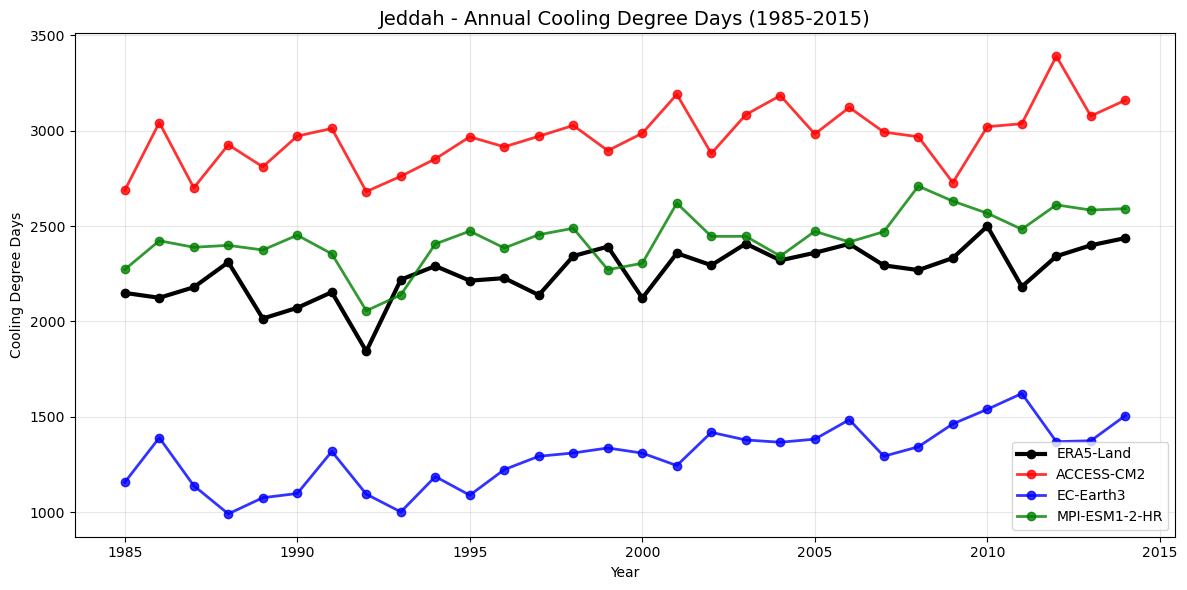


Jeddah Annual CDD Statistics:
ERA5 mean: 2256 ± 139

2. Wet-Bulb Temperature Analysis
Processing ERA5 data for jeddah...
Processing ACCESS-CM2 data for jeddah...
Processing EC-Earth3 data for jeddah...
Processing MPI-ESM1-2-HR data for jeddah...
Processing ACCESS-CM2 data for jeddah...
Processing EC-Earth3 data for jeddah...
Processing MPI-ESM1-2-HR data for jeddah...


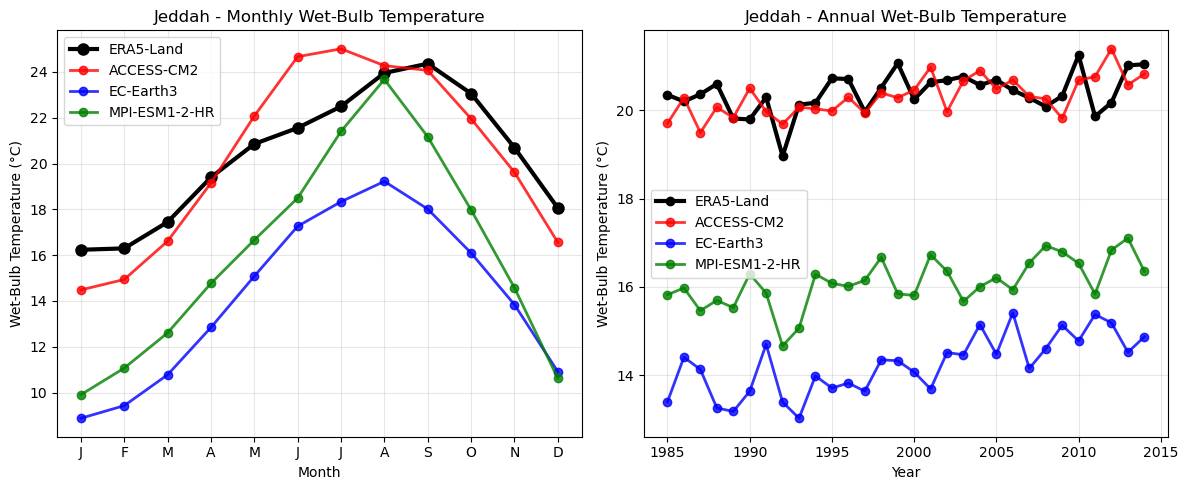


3. Dangerous Heat Analysis
Processing ERA5 data for jeddah...

Jeddah - Dangerous Heat Nights (Wet-bulb > 30°C at 3 AM):
ERA5 average: 0.0 nights/year
ERA5 maximum: 0 nights (never exceeded 30°C)
Processing ACCESS-CM2 data for jeddah...
ACCESS-CM2 average: 0.0 nights/year
Processing EC-Earth3 data for jeddah...
EC-Earth3 average: 0.0 nights/year
Processing MPI-ESM1-2-HR data for jeddah...
MPI-ESM1-2-HR average: 0.0 nights/year

ANALYSIS FOR RIYADH

1. Annual Cooling Degree Days
Processing ERA5 data for riyadh...
Processing ACCESS-CM2 data for riyadh...
Processing EC-Earth3 data for riyadh...
Processing MPI-ESM1-2-HR data for riyadh...


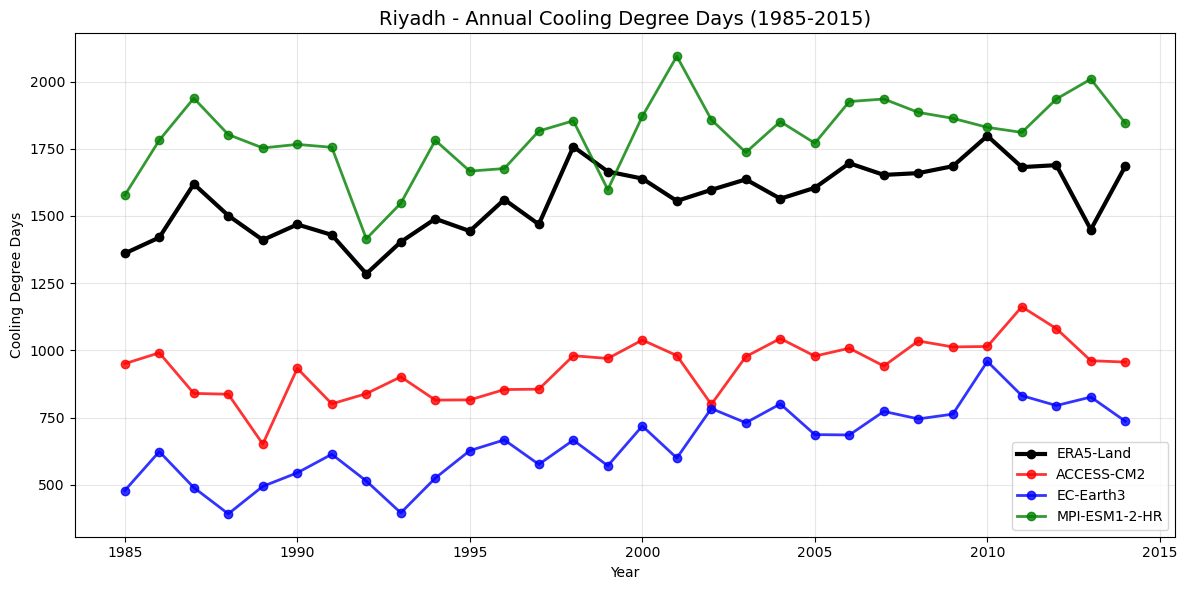


Riyadh Annual CDD Statistics:
ERA5 mean: 1563 ± 126

2. Wet-Bulb Temperature Analysis
Processing ERA5 data for riyadh...
Processing ACCESS-CM2 data for riyadh...
Processing EC-Earth3 data for riyadh...
Processing MPI-ESM1-2-HR data for riyadh...
Processing ACCESS-CM2 data for riyadh...
Processing EC-Earth3 data for riyadh...
Processing MPI-ESM1-2-HR data for riyadh...


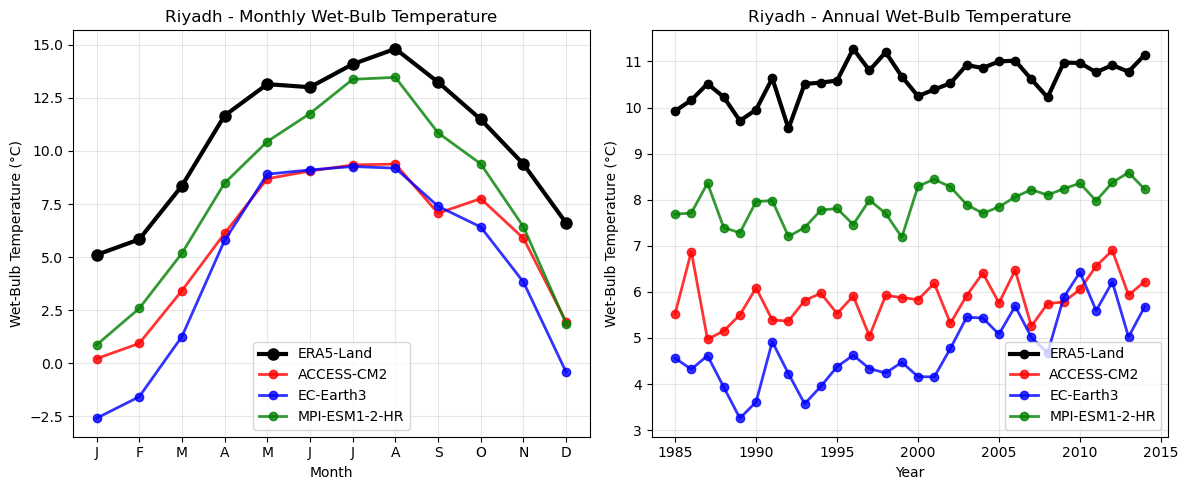


3. Dangerous Heat Analysis
Processing ERA5 data for riyadh...

Riyadh - Dangerous Heat Nights (Wet-bulb > 30°C at 3 AM):
ERA5 average: 0.0 nights/year
ERA5 maximum: 0 nights (never exceeded 30°C)
Processing ACCESS-CM2 data for riyadh...
ACCESS-CM2 average: 0.0 nights/year
Processing EC-Earth3 data for riyadh...
EC-Earth3 average: 0.0 nights/year
Processing MPI-ESM1-2-HR data for riyadh...
MPI-ESM1-2-HR average: 0.0 nights/year


In [80]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xarray.coding.calendar_ops import convert_calendar

# Load ERA5 data and convert to noleap calendar
print("Loading and converting ERA5 data to noleap calendar...")
ds_era5_jeddah_raw = xr.open_dataset('era5_land_jeddah_1985_2015.nc')
ds_era5_riyadh_raw = xr.open_dataset('era5_land_riyadh_1985_2015.nc')

# Convert to noleap calendar
ds_era5_jeddah_noleap = convert_calendar(ds_era5_jeddah_raw, 'noleap')
ds_era5_riyadh_noleap = convert_calendar(ds_era5_riyadh_raw, 'noleap')

# Align time period with CMIP6 (1985-2014)
ds_era5_jeddah = ds_era5_jeddah_noleap.sel(time=ds_era5_jeddah_noleap.time.dt.year.isin(range(1985, 2015)))
ds_era5_riyadh = ds_era5_riyadh_noleap.sel(time=ds_era5_riyadh_noleap.time.dt.year.isin(range(1985, 2015)))

# Save the converted and aligned data
print("Saving aligned noleap data...")
ds_era5_jeddah.to_netcdf('era5_land_jeddah_1985_2014_noleap.nc')
ds_era5_riyadh.to_netcdf('era5_land_riyadh_1985_2014_noleap.nc')

print("✓ ERA5 data converted to noleap calendar and aligned to 1985-2014")
print(f"✓ Saved: era5_land_jeddah_1985_2014_noleap.nc")
print(f"✓ Saved: era5_land_riyadh_1985_2014_noleap.nc")
print(f"ERA5 Jeddah: {ds_era5_jeddah.time.dt.year.min().values} to {ds_era5_jeddah.time.dt.year.max().values}")
print(f"ERA5 Riyadh: {ds_era5_riyadh.time.dt.year.min().values} to {ds_era5_riyadh.time.dt.year.max().values}")

def calculate_wet_bulb_stull(temp_c, rh_percent):
    """
    Calculate wet-bulb temperature using Stull (2011) approximation
    Good accuracy for most conditions
    
    Parameters:
    temp_c: Temperature in Celsius
    rh_percent: Relative humidity in percent (0-100)
    
    Returns:
    Wet-bulb temperature in Celsius
    """
    wb = temp_c * np.arctan(0.151977 * np.sqrt(rh_percent + 8.313659)) + \
         np.arctan(temp_c + rh_percent) - \
         np.arctan(rh_percent - 1.676331) + \
         0.00391838 * (rh_percent**1.5) * np.arctan(0.023101 * rh_percent) - \
         4.686035
    
    return wb

def calculate_cooling_degree_days_daily(temp_data, base_temp=18.3):
    """
    Calculate daily cooling degree days (simple method for daily values)
    Base temperature default: 65°F = 18.3°C
    """
    return np.maximum(0, temp_data - base_temp)

def calculate_annual_cdd_xclim(temp_data, base_temp=18.3):
    """
    Calculate annual cooling degree days using xclim method
    Base temperature default: 65°F = 18.3°C
    """
    # Add required attributes for xclim
    temp_data.attrs.update({
        'units': 'degC',
        'standard_name': 'air_temperature'
    })
    
    # Use xclim's cooling degree days calculation (returns annual values)
    cdd_annual = xclim.atmos.cooling_degree_days(
        tas=temp_data, 
        thresh=f'{base_temp} degC'
    )
    
    return cdd_annual

def process_era5_data(ds, city_name):
    """Process ERA5 data to calculate CDD and wet-bulb"""
    
    print(f"Processing ERA5 data for {city_name}...")
    
    # Get temperature and humidity (spatial mean)
    temp = ds['t2m'].mean(['latitude', 'longitude'])
    rhum = ds['rhum'].mean(['latitude', 'longitude'])
    
    # Calculate wet-bulb temperature
    wb_temp = calculate_wet_bulb_stull(temp, rhum)
    
    # Calculate daily cooling degree days (for daily data storage)
    cdd_daily = calculate_cooling_degree_days_daily(temp)
    
    # Add to dataset
    ds_processed = ds.copy()
    ds_processed['wb_temp'] = (['time'], wb_temp.values)
    ds_processed['cdd_daily'] = (['time'], cdd_daily.values)
    
    # Add attributes
    ds_processed['wb_temp'].attrs = {
        'units': 'degC',
        'long_name': 'Wet Bulb Temperature',
        'method': 'Stull (2011) approximation'
    }
    ds_processed['cdd_daily'].attrs = {
        'units': 'degree_days',
        'long_name': 'Daily Cooling Degree Days',
        'base_temperature': '18.3°C (65°F)'
    }
    
    return ds_processed

def process_model_data(model_name, city_name):
    """Process CMIP6 model data"""
    
    print(f"Processing {model_name} data for {city_name}...")
    
    try:
        # Load model data
        # using tasmin (daily minimum temperature) data instead of tas (daily average temperature) data
        tasmin_file = f'cmip6_tasmin_cities/{model_name}_tasmin_historical_1985_2014_{city_name}.nc'
        hurs_file = f'cmip6_cities/{model_name}_hurs_historical_1985_2015_{city_name}.nc'
        
        tasmin_ds = xr.open_dataset(tasmin_file)
        hurs_ds = xr.open_dataset(hurs_file)
        
        # Convert temperature to Celsius if needed
        temp = tasmin_ds.tasmin  # Changed from tas to tasmin
        if temp.max() > 100:  # Likely in Kelvin
            temp = temp - 273.15
        
        rhum = hurs_ds.hurs
        
        # Calculate wet-bulb temperature
        wb_temp = calculate_wet_bulb_stull(temp, rhum)
        
        # Calculate daily cooling degree days
        cdd_daily = calculate_cooling_degree_days_daily(temp)
        
        # Create processed dataset
        ds_processed = xr.Dataset({
            'tasmin': temp,  # Changed from tas to tasmin
            'hurs': rhum,
            'wb_temp': (['time'], wb_temp.values),
            'cdd_daily': (['time'], cdd_daily.values)
        })
        
        return ds_processed
        
    except Exception as e:
        print(f"Error processing {model_name} for {city_name}: {e}")
        return None

def plot_annual_cdd_comparison(city_name):
    """Plot annual CDD comparison between ERA5 and models"""
    
    # Process ERA5 data
    if city_name == 'jeddah':
        era5_processed = process_era5_data(ds_era5_jeddah, city_name)
    else:
        era5_processed = process_era5_data(ds_era5_riyadh, city_name)
    
    # Calculate annual CDD for ERA5
    era5_annual_cdd = era5_processed['cdd_daily'].groupby('time.year').sum()
    
    plt.figure(figsize=(12, 6))
    
    # Plot ERA5
    plt.plot(era5_annual_cdd.year, era5_annual_cdd, 'ko-', 
             linewidth=3, markersize=6, label='ERA5-Land')
    
    # Plot models
    models = ['ACCESS-CM2', 'EC-Earth3', 'MPI-ESM1-2-HR']
    colors = ['red', 'blue', 'green']
    
    for i, model in enumerate(models):
        model_data = process_model_data(model, city_name)
        if model_data is not None:
            model_annual_cdd = model_data['cdd_daily'].groupby('time.year').sum()
            plt.plot(model_annual_cdd.year, model_annual_cdd, 'o-', 
                    color=colors[i], linewidth=2, label=model, alpha=0.8)
    
    plt.title(f'{city_name.title()} - Annual Cooling Degree Days (1985-2015)', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel('Cooling Degree Days')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{city_name.title()} Annual CDD Statistics:")
    print(f"ERA5 mean: {era5_annual_cdd.mean().values:.0f} ± {era5_annual_cdd.std().values:.0f}")

def plot_wet_bulb_comparison(city_name):
    """Plot wet-bulb temperature comparison"""
    
    # Process ERA5 data
    if city_name == 'jeddah':
        era5_processed = process_era5_data(ds_era5_jeddah, city_name)
    else:
        era5_processed = process_era5_data(ds_era5_riyadh, city_name)
    
    # Calculate monthly climatology for ERA5
    era5_monthly_wb = era5_processed['wb_temp'].groupby('time.month').mean()
    
    plt.figure(figsize=(12, 5))
    
    # Monthly wet-bulb comparison
    plt.subplot(1, 2, 1)
    months = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
    plt.plot(range(1, 13), era5_monthly_wb, 'ko-', 
             linewidth=3, markersize=8, label='ERA5-Land')
    
    models = ['ACCESS-CM2', 'EC-Earth3', 'MPI-ESM1-2-HR']
    colors = ['red', 'blue', 'green']
    
    for i, model in enumerate(models):
        model_data = process_model_data(model, city_name)
        if model_data is not None:
            model_monthly_wb = model_data['wb_temp'].groupby('time.month').mean()
            plt.plot(range(1, 13), model_monthly_wb, 'o-', 
                    color=colors[i], linewidth=2, label=model, alpha=0.8)
    
    plt.title(f'{city_name.title()} - Monthly Wet-Bulb Temperature')
    plt.xlabel('Month')
    plt.ylabel('Wet-Bulb Temperature (°C)')
    plt.xticks(range(1, 13), months)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Annual wet-bulb trends
    plt.subplot(1, 2, 2)
    era5_annual_wb = era5_processed['wb_temp'].groupby('time.year').mean()
    plt.plot(era5_annual_wb.year, era5_annual_wb, 'ko-', 
             linewidth=3, markersize=6, label='ERA5-Land')
    
    for i, model in enumerate(models):
        model_data = process_model_data(model, city_name)
        if model_data is not None:
            model_annual_wb = model_data['wb_temp'].groupby('time.year').mean()
            plt.plot(model_annual_wb.year, model_annual_wb, 'o-', 
                    color=colors[i], linewidth=2, label=model, alpha=0.8)
    
    plt.title(f'{city_name.title()} - Annual Wet-Bulb Temperature')
    plt.xlabel('Year')
    plt.ylabel('Wet-Bulb Temperature (°C)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def calculate_dangerous_heat_days(city_name, wb_threshold=30):
    """Calculate number of dangerous heat days (wet-bulb > 30°C at night)"""
    
    # Process ERA5 data
    if city_name == 'jeddah':
        era5_processed = process_era5_data(ds_era5_jeddah, city_name)
    else:
        era5_processed = process_era5_data(ds_era5_riyadh, city_name)
    
    # Count dangerous days per year for ERA5
    era5_dangerous = (era5_processed['wb_temp'] > wb_threshold).groupby('time.year').sum()
    
    print(f"\n{city_name.title()} - Dangerous Heat Nights (Wet-bulb > {wb_threshold}°C at 3 AM):")
    print(f"ERA5 average: {era5_dangerous.mean().values:.1f} nights/year")
    if era5_dangerous.max().values > 0:
        print(f"ERA5 maximum: {era5_dangerous.max().values:.0f} nights in {era5_dangerous.idxmax().values}")
    else:
        print(f"ERA5 maximum: 0 nights (never exceeded {wb_threshold}°C)")
    
    # Check models
    models = ['ACCESS-CM2', 'EC-Earth3', 'MPI-ESM1-2-HR']
    for model in models:
        model_data = process_model_data(model, city_name)
        if model_data is not None:
            model_dangerous = (model_data['wb_temp'] > wb_threshold).groupby('time.year').sum()
            print(f"{model} average: {model_dangerous.mean().values:.1f} nights/year")

def run_full_analysis():
    """Run complete CDD and wet-bulb analysis"""
    
    print("=== CDD and Wet-Bulb Temperature Analysis ===\n")
    
    for city in ['jeddah', 'riyadh']:
        print(f"\n{'='*50}")
        print(f"ANALYSIS FOR {city.upper()}")
        print(f"{'='*50}")
        
        # 1. Annual CDD comparison
        print("\n1. Annual Cooling Degree Days")
        plot_annual_cdd_comparison(city)
        
        # 2. Wet-bulb temperature analysis
        print("\n2. Wet-Bulb Temperature Analysis")
        plot_wet_bulb_comparison(city)
        
        # 3. Dangerous heat days
        print("\n3. Dangerous Heat Analysis")
        calculate_dangerous_heat_days(city)

if __name__ == "__main__":
    run_full_analysis()

## Future sceraios analysis 

=== Historical vs Future Climate Analysis ===


FUTURE CLIMATE ANALYSIS FOR JEDDAH

1. Temperature Warming Analysis


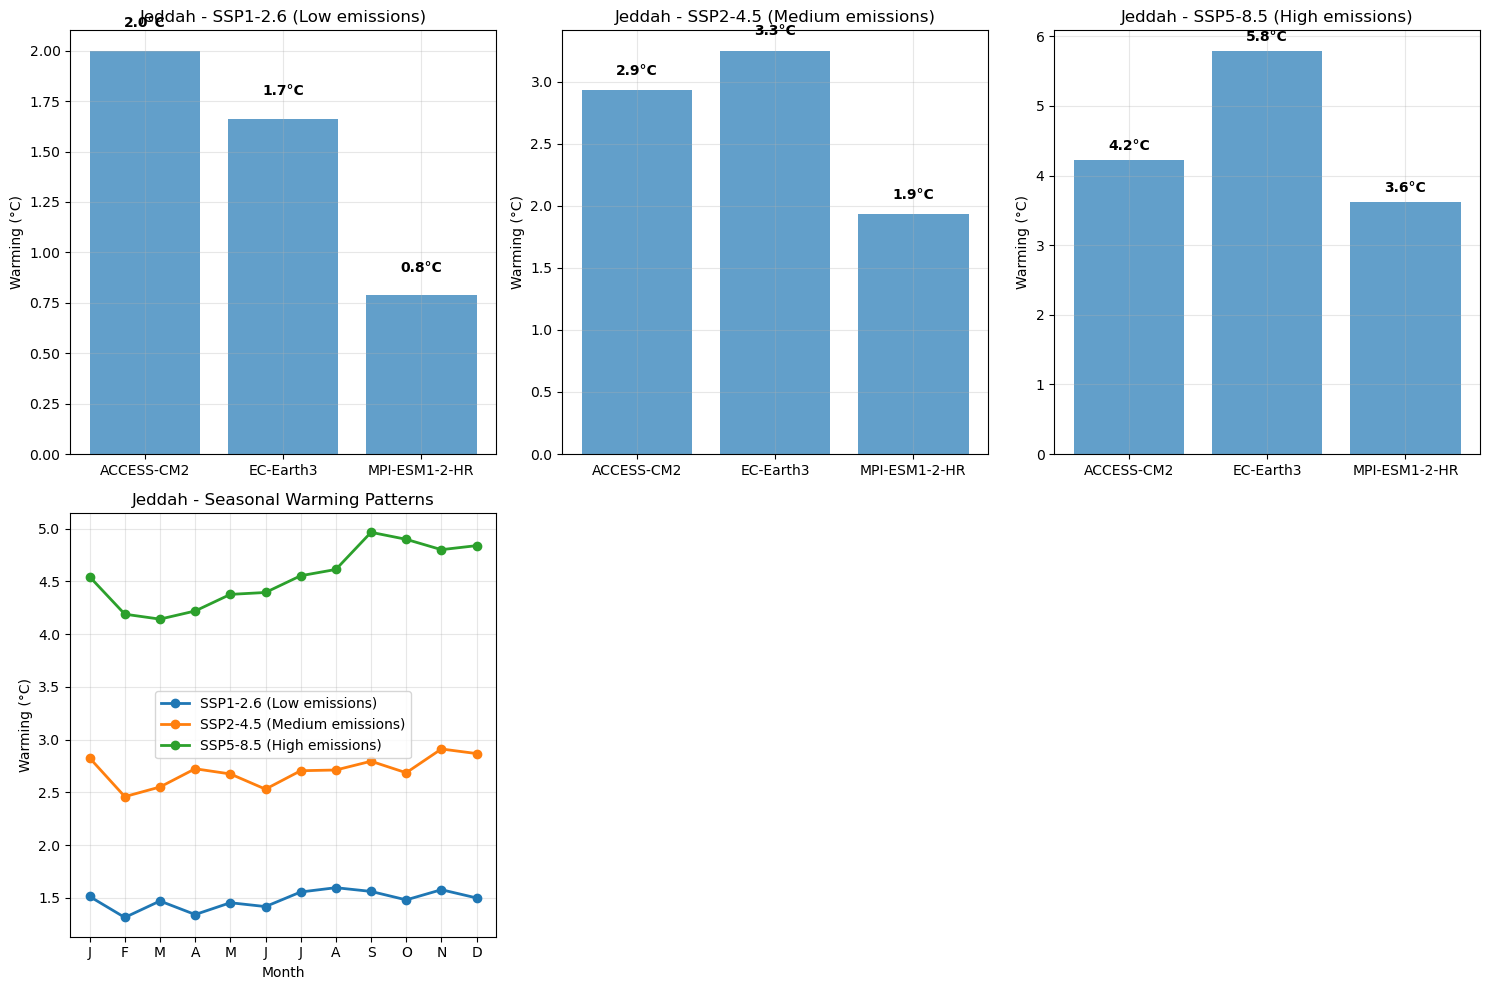


2. Cooling Degree Days Changes


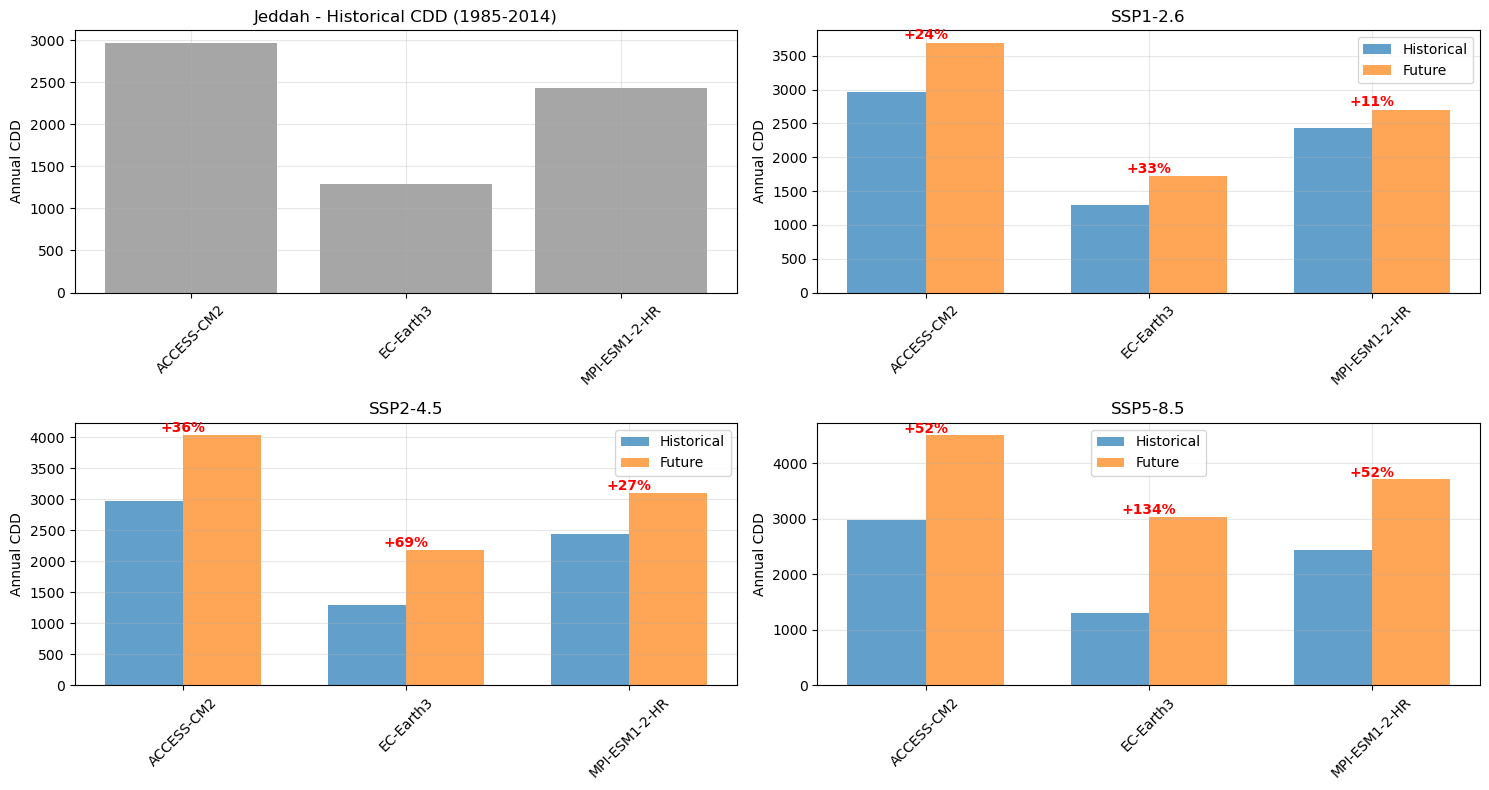


3. Wet-Bulb Temperature Projections


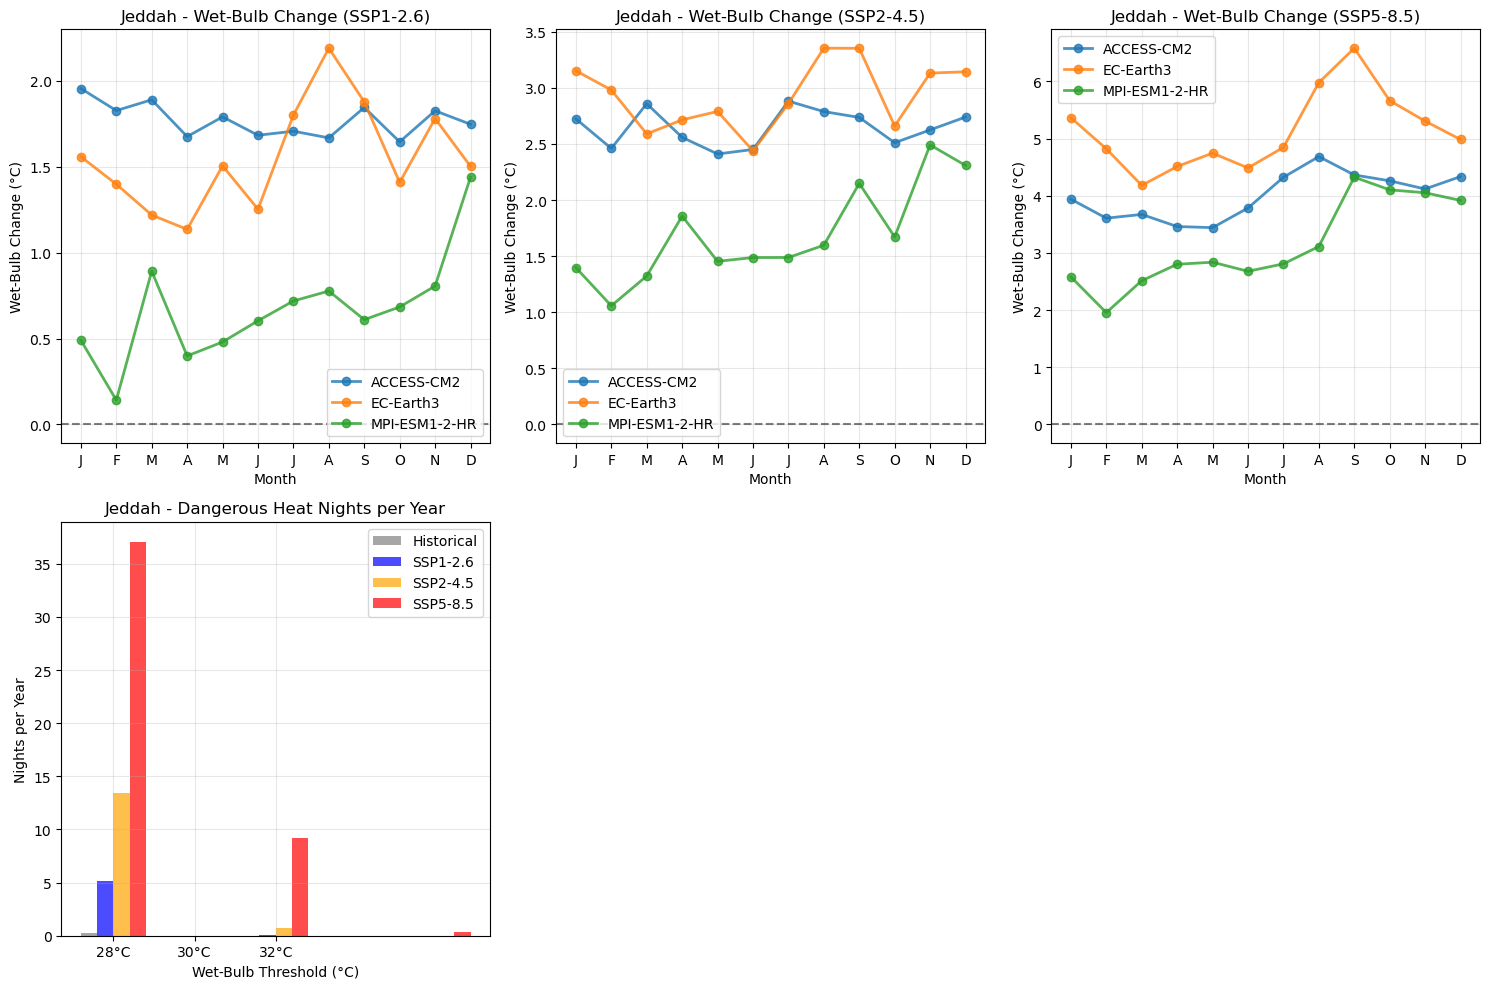


4. ERA5 vs Future Projections
✓ Loaded ERA5 data for jeddah


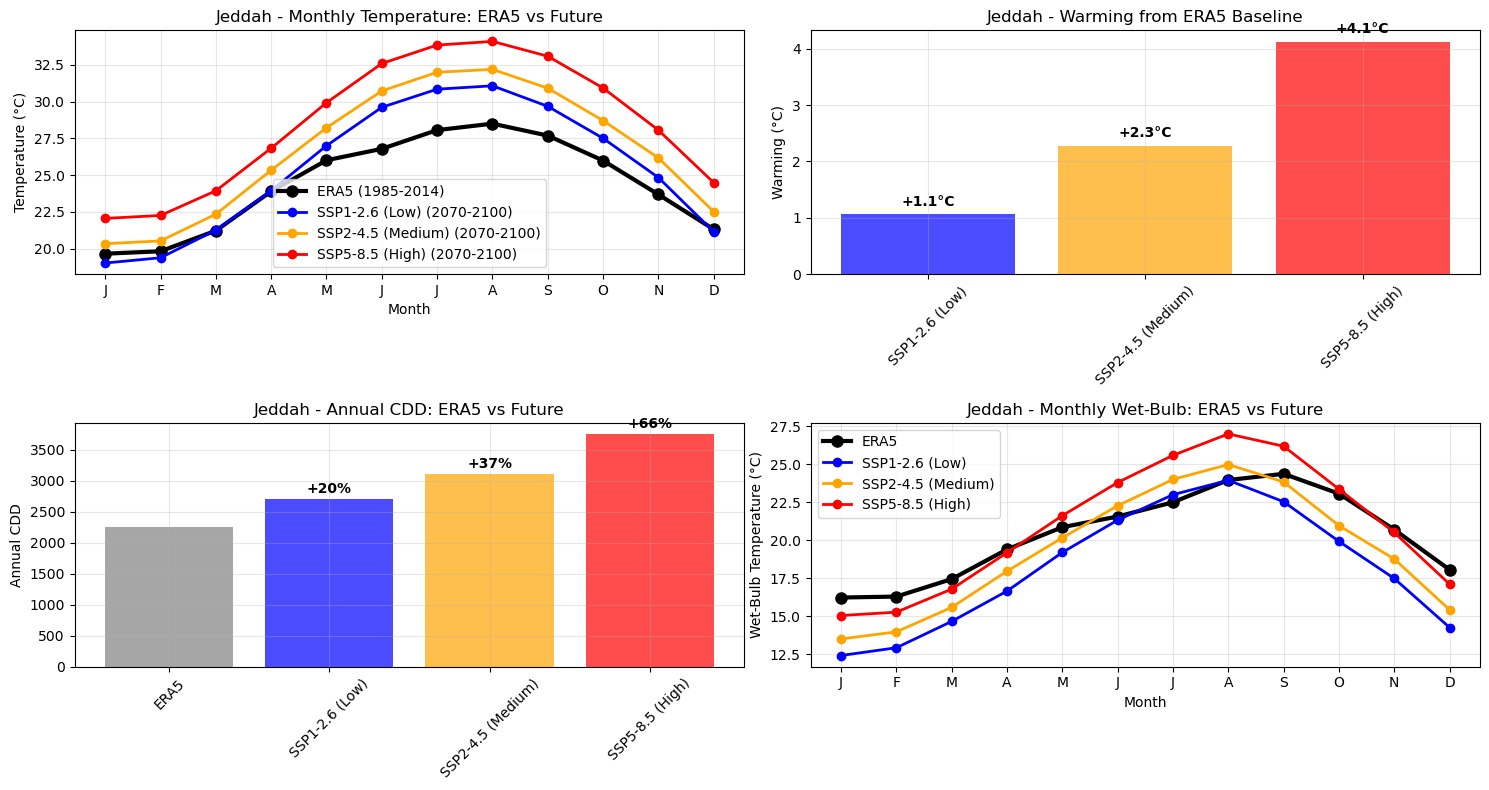

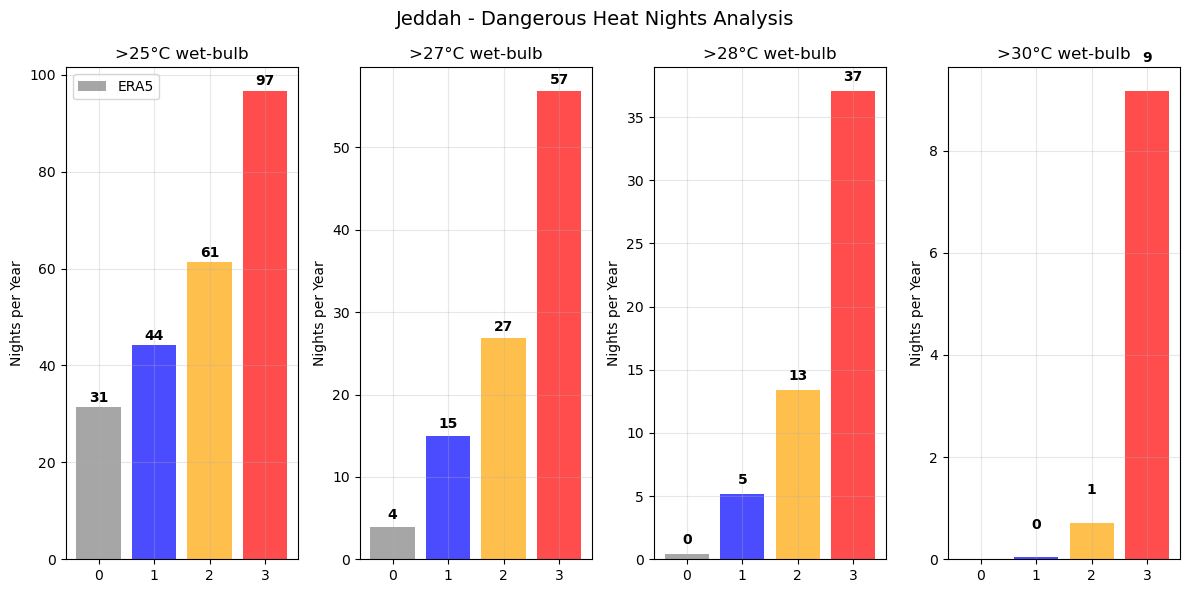


Jeddah - ERA5 vs Future Summary:
ERA5 baseline (1985-2014): 24.4°C
SSP1-2.6 (Low): +1.1°C warming
SSP2-4.5 (Medium): +2.3°C warming
SSP5-8.5 (High): +4.1°C warming
ERA5 nights >25°C wet-bulb: 31 per year
ERA5 nights >28°C wet-bulb: 0 per year
ERA5 nights >30°C wet-bulb: 0 per year


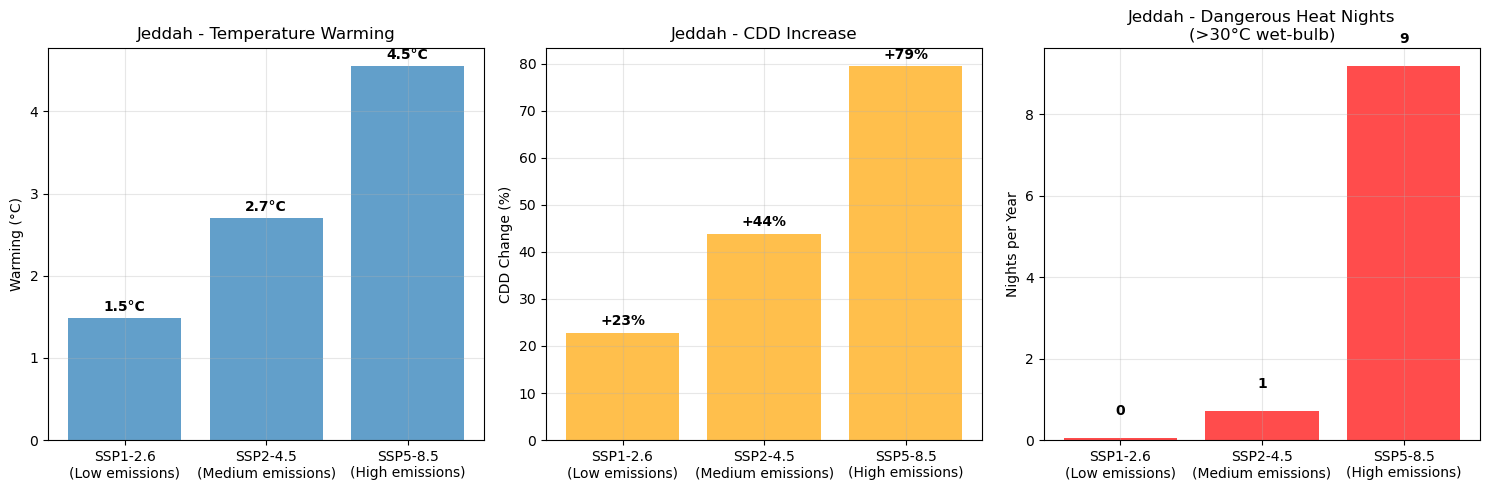


5. Scenario Comparison Summary


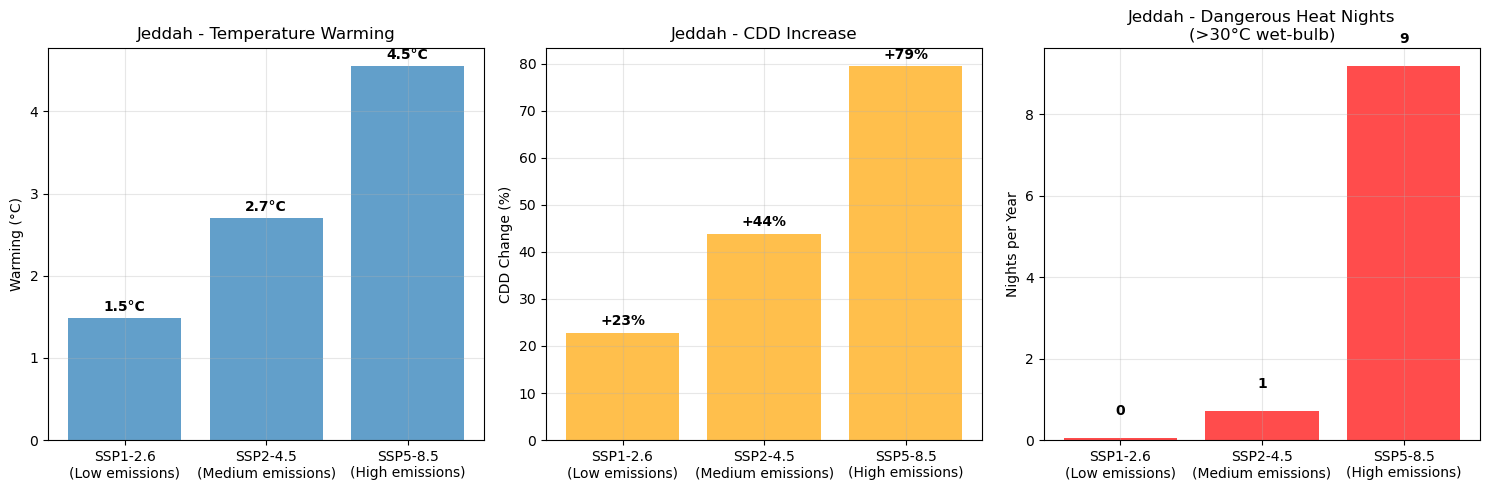


FUTURE CLIMATE ANALYSIS FOR RIYADH

1. Temperature Warming Analysis


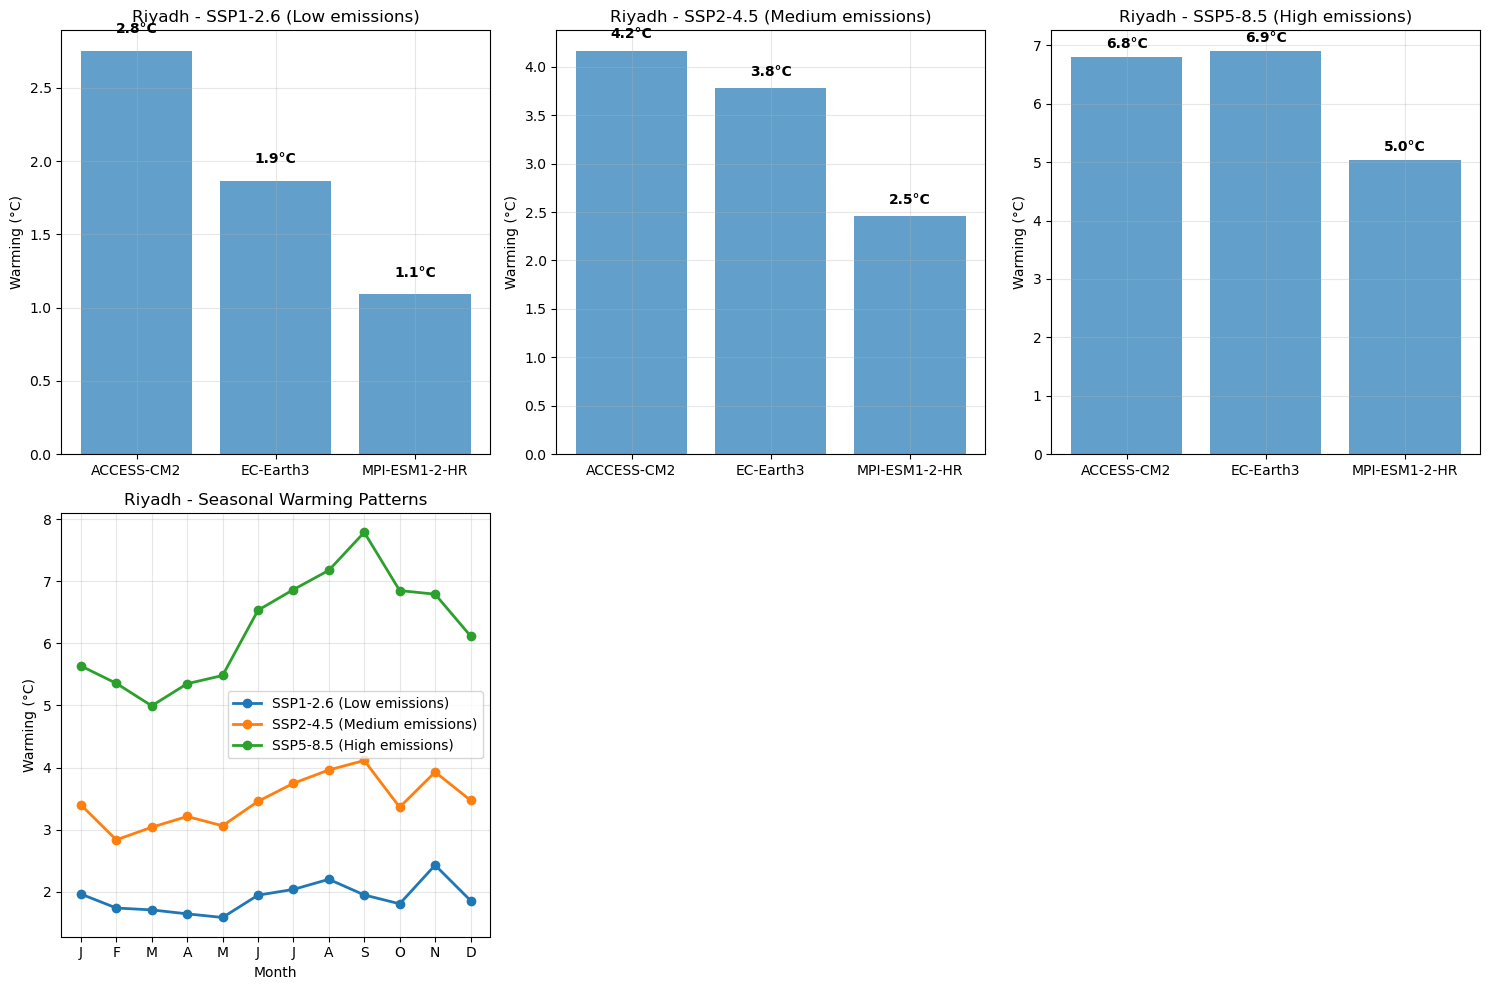


2. Cooling Degree Days Changes


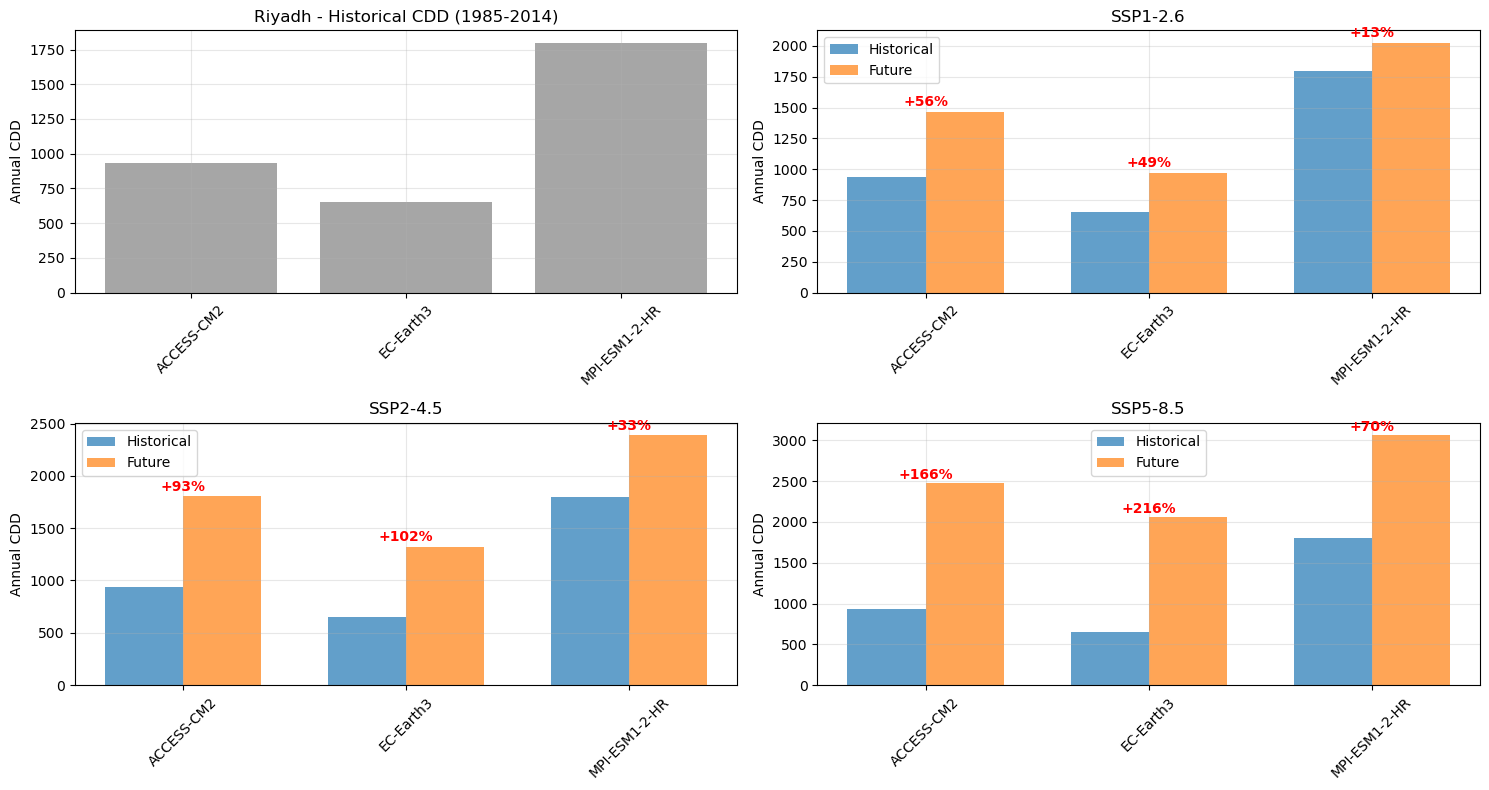


3. Wet-Bulb Temperature Projections


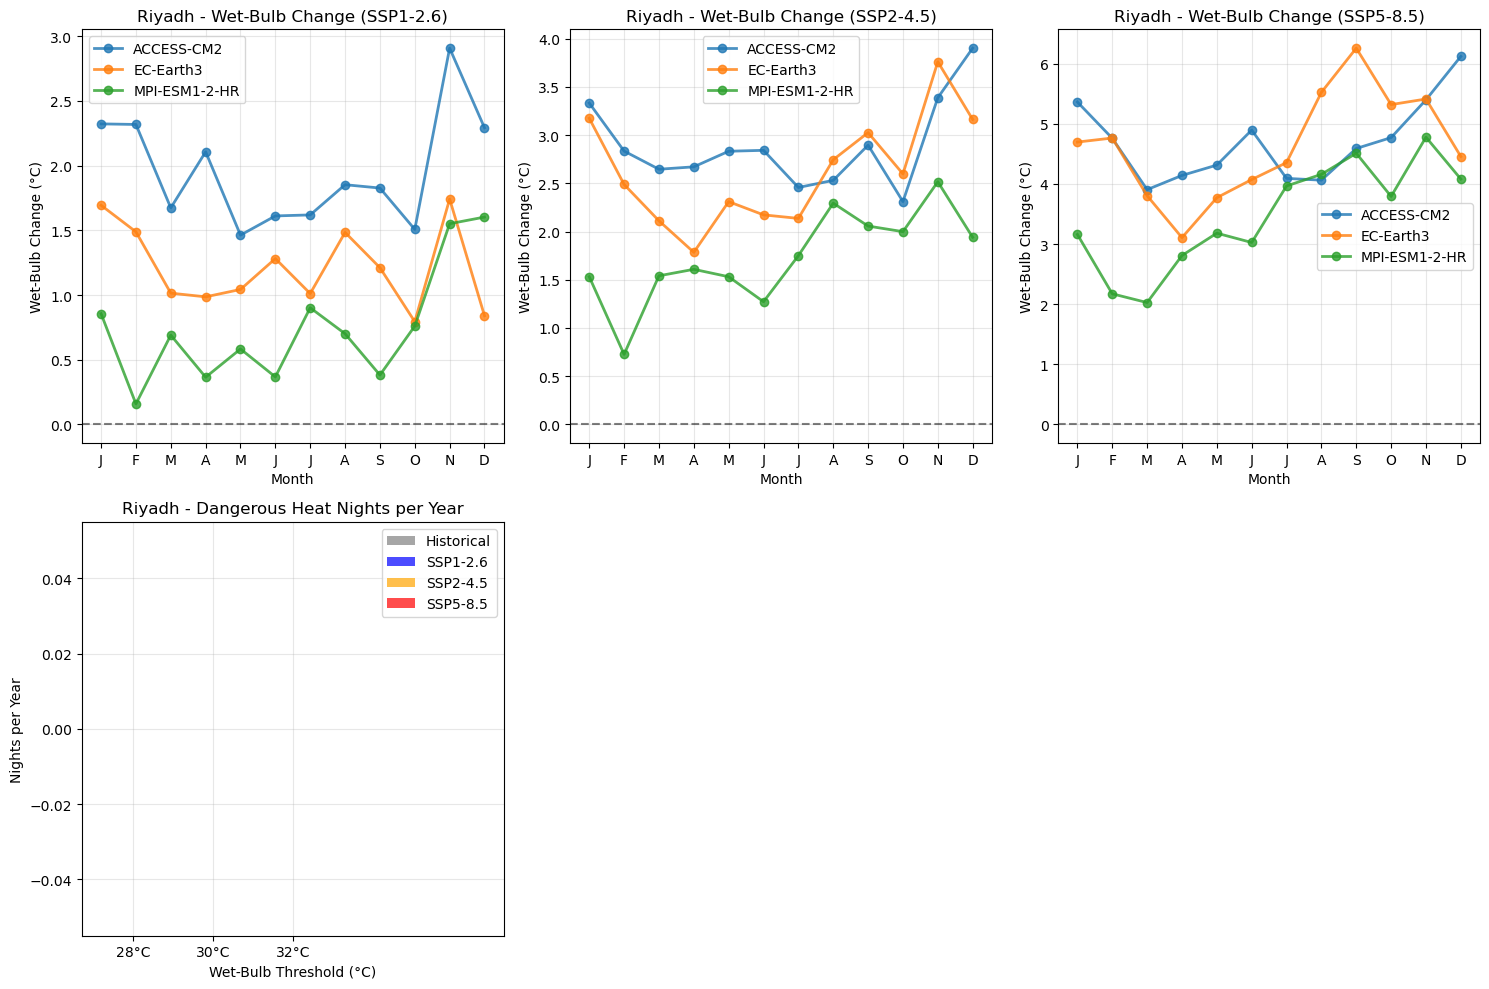


4. ERA5 vs Future Projections
✓ Loaded ERA5 data for riyadh


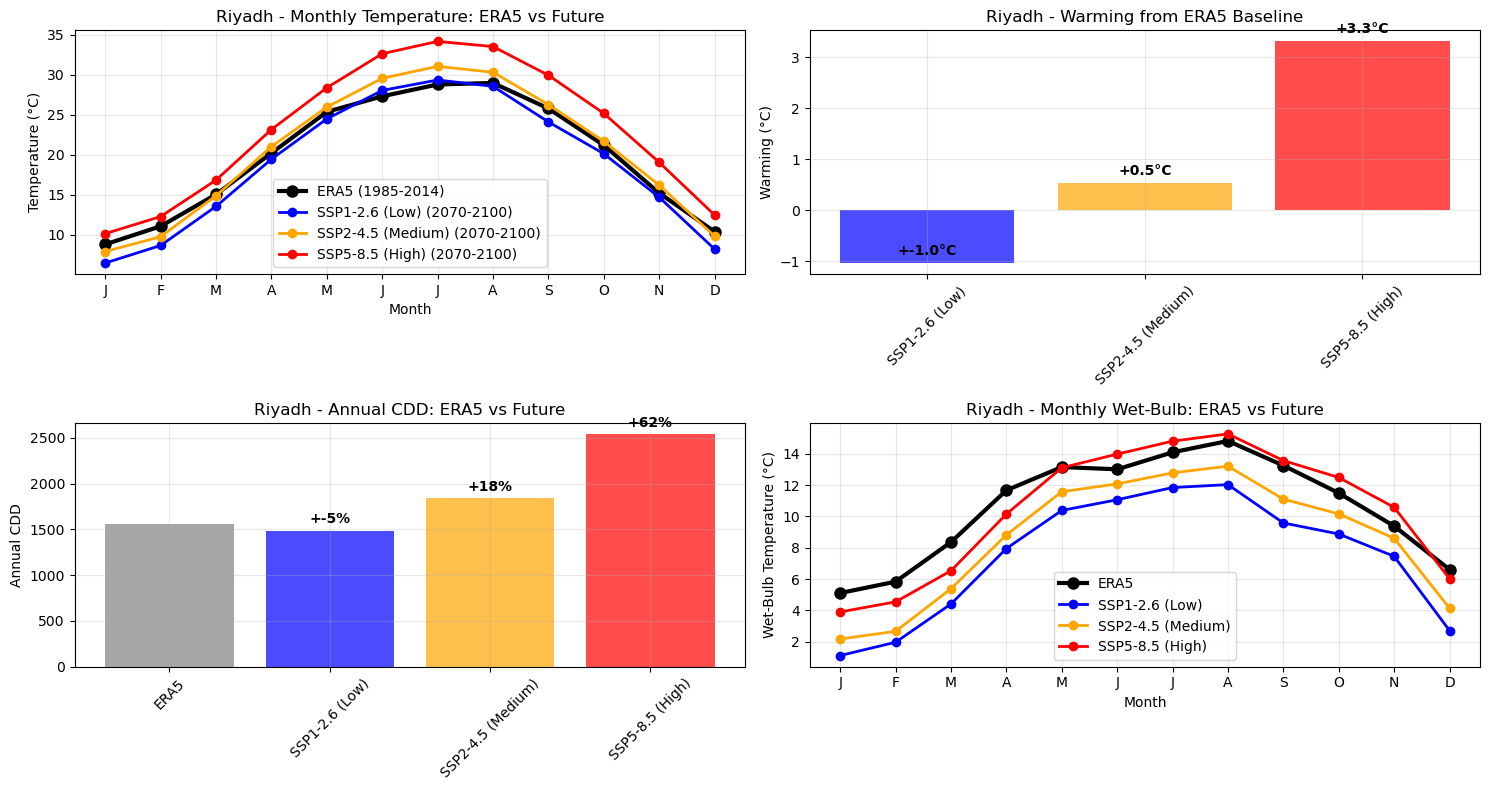

/tmp/ipykernel_35/575085336.py:521: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


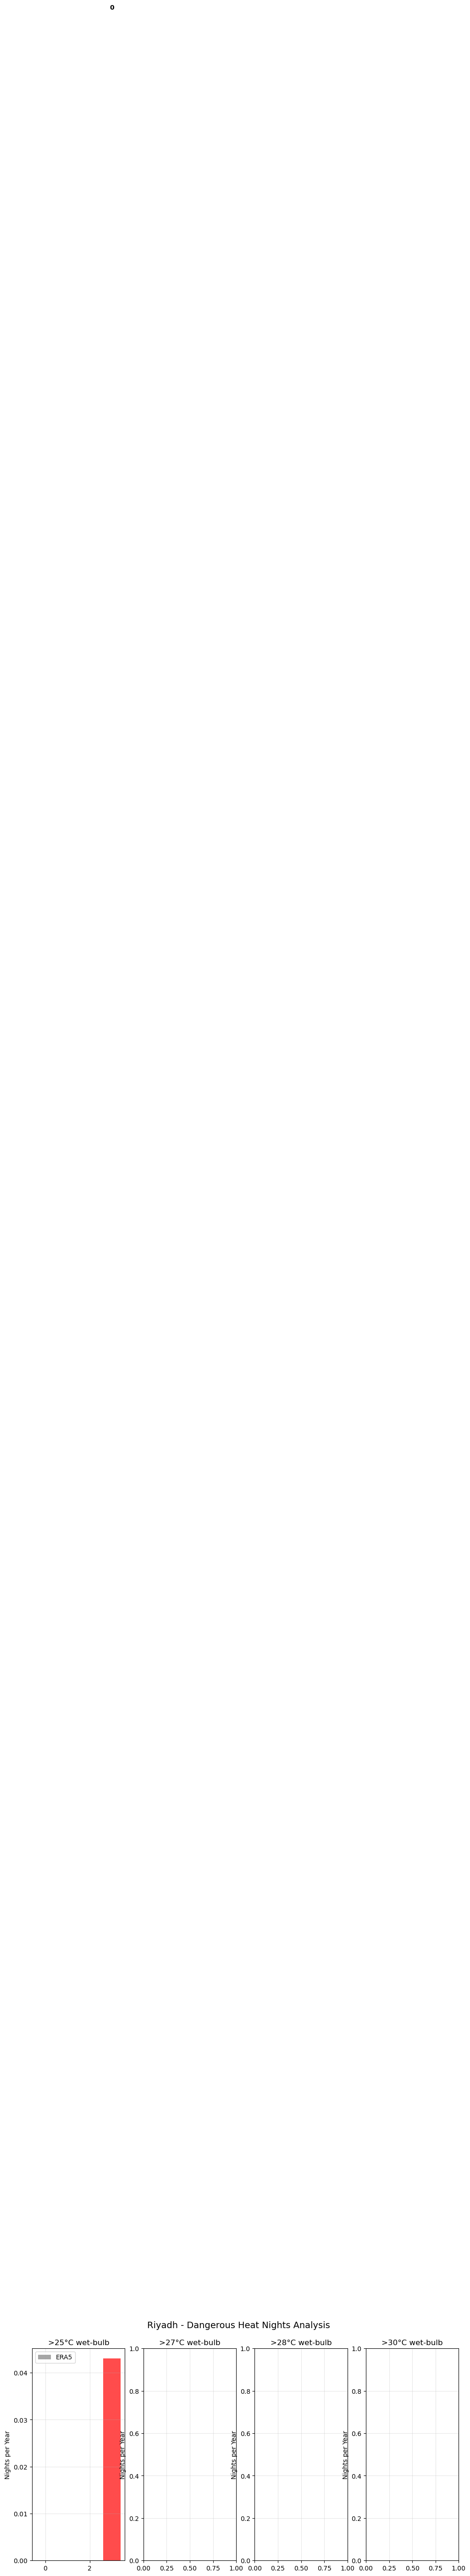


Riyadh - ERA5 vs Future Summary:
ERA5 baseline (1985-2014): 19.9°C
SSP1-2.6 (Low): +-1.0°C warming
SSP2-4.5 (Medium): +0.5°C warming
SSP5-8.5 (High): +3.3°C warming
ERA5 nights >25°C wet-bulb: 0 per year
ERA5 nights >28°C wet-bulb: 0 per year
ERA5 nights >30°C wet-bulb: 0 per year


/tmp/ipykernel_35/575085336.py:633: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


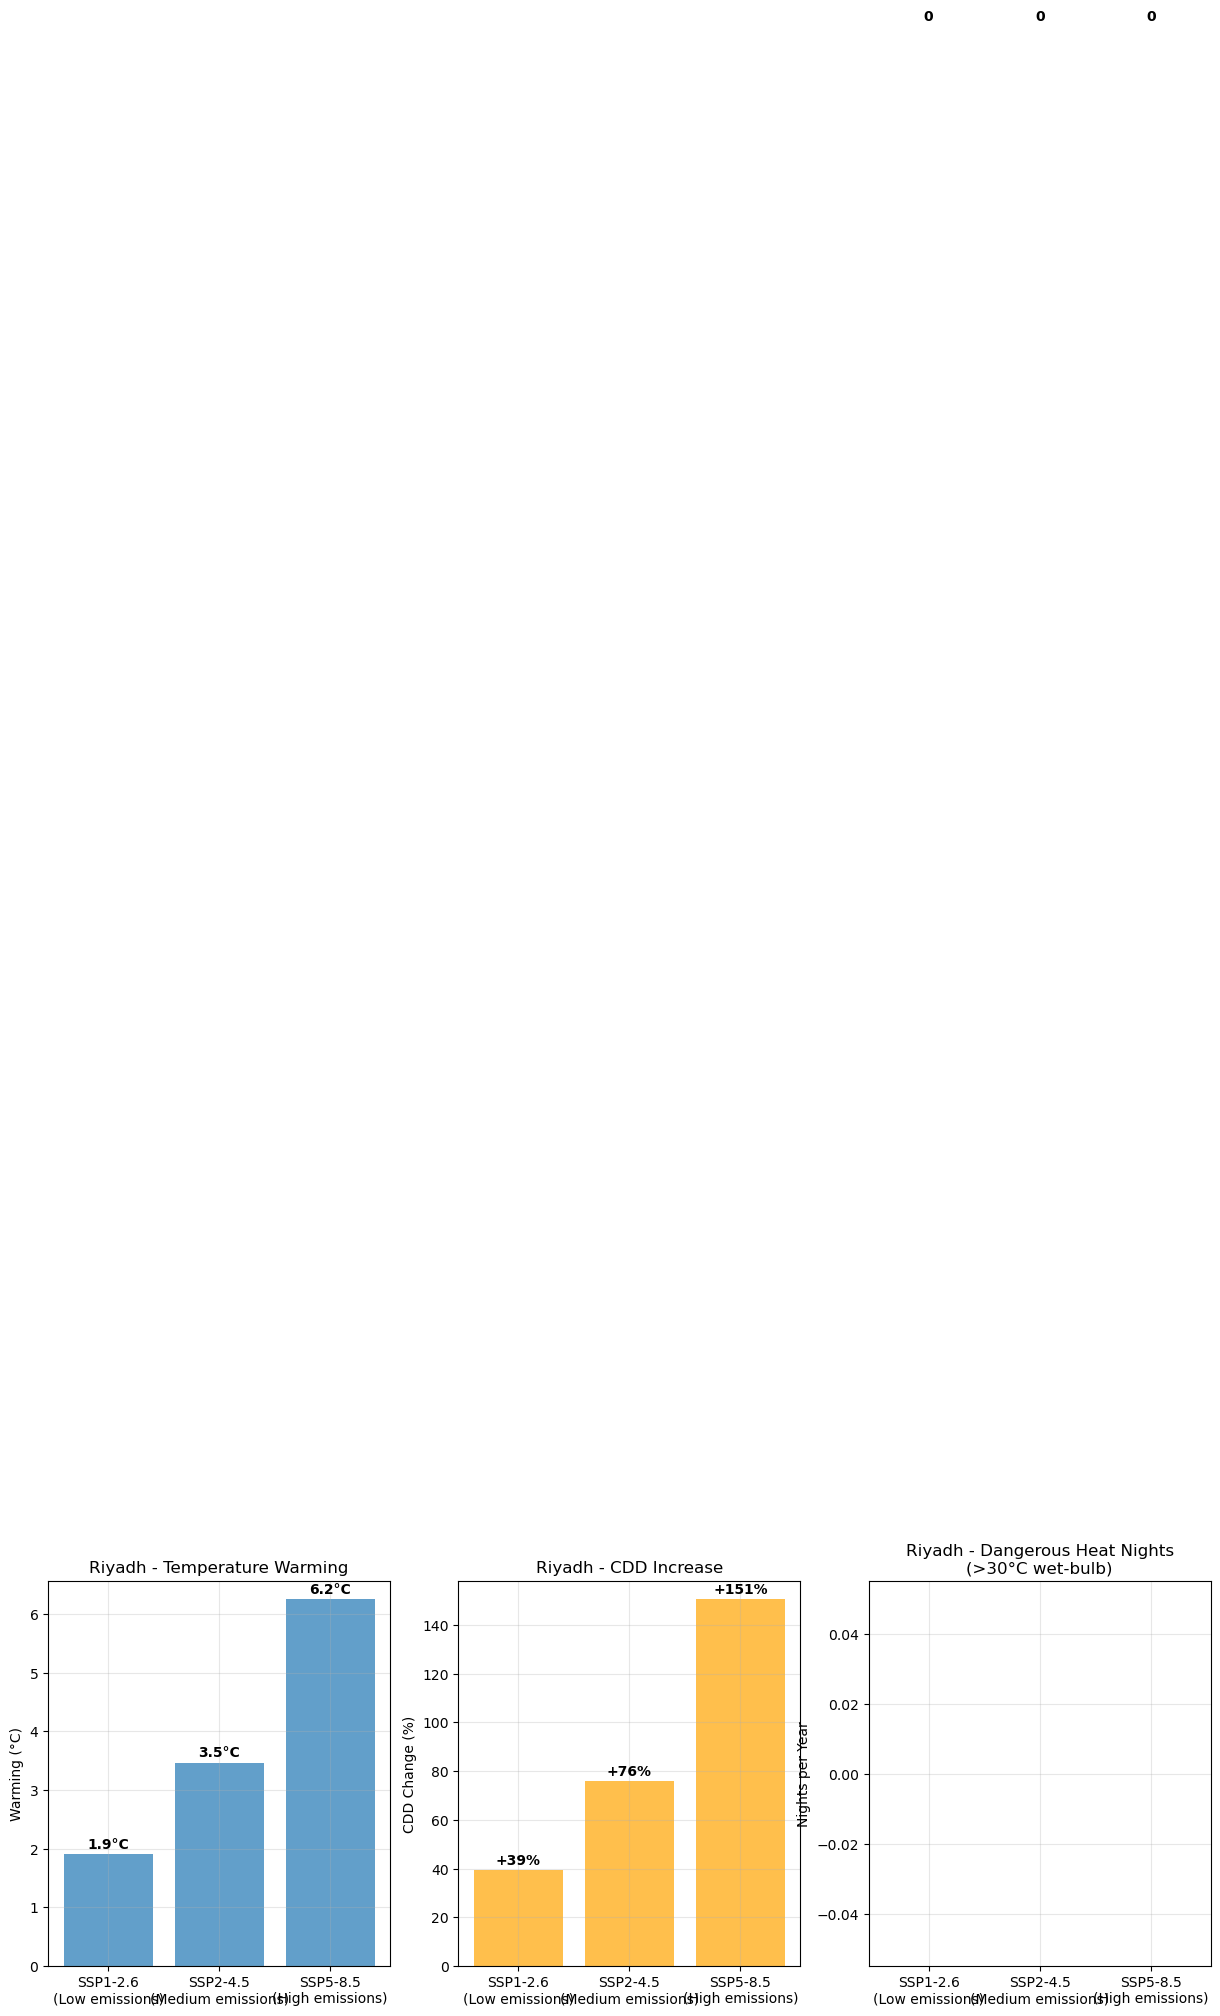


5. Scenario Comparison Summary


/tmp/ipykernel_35/2560860716.py:406: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


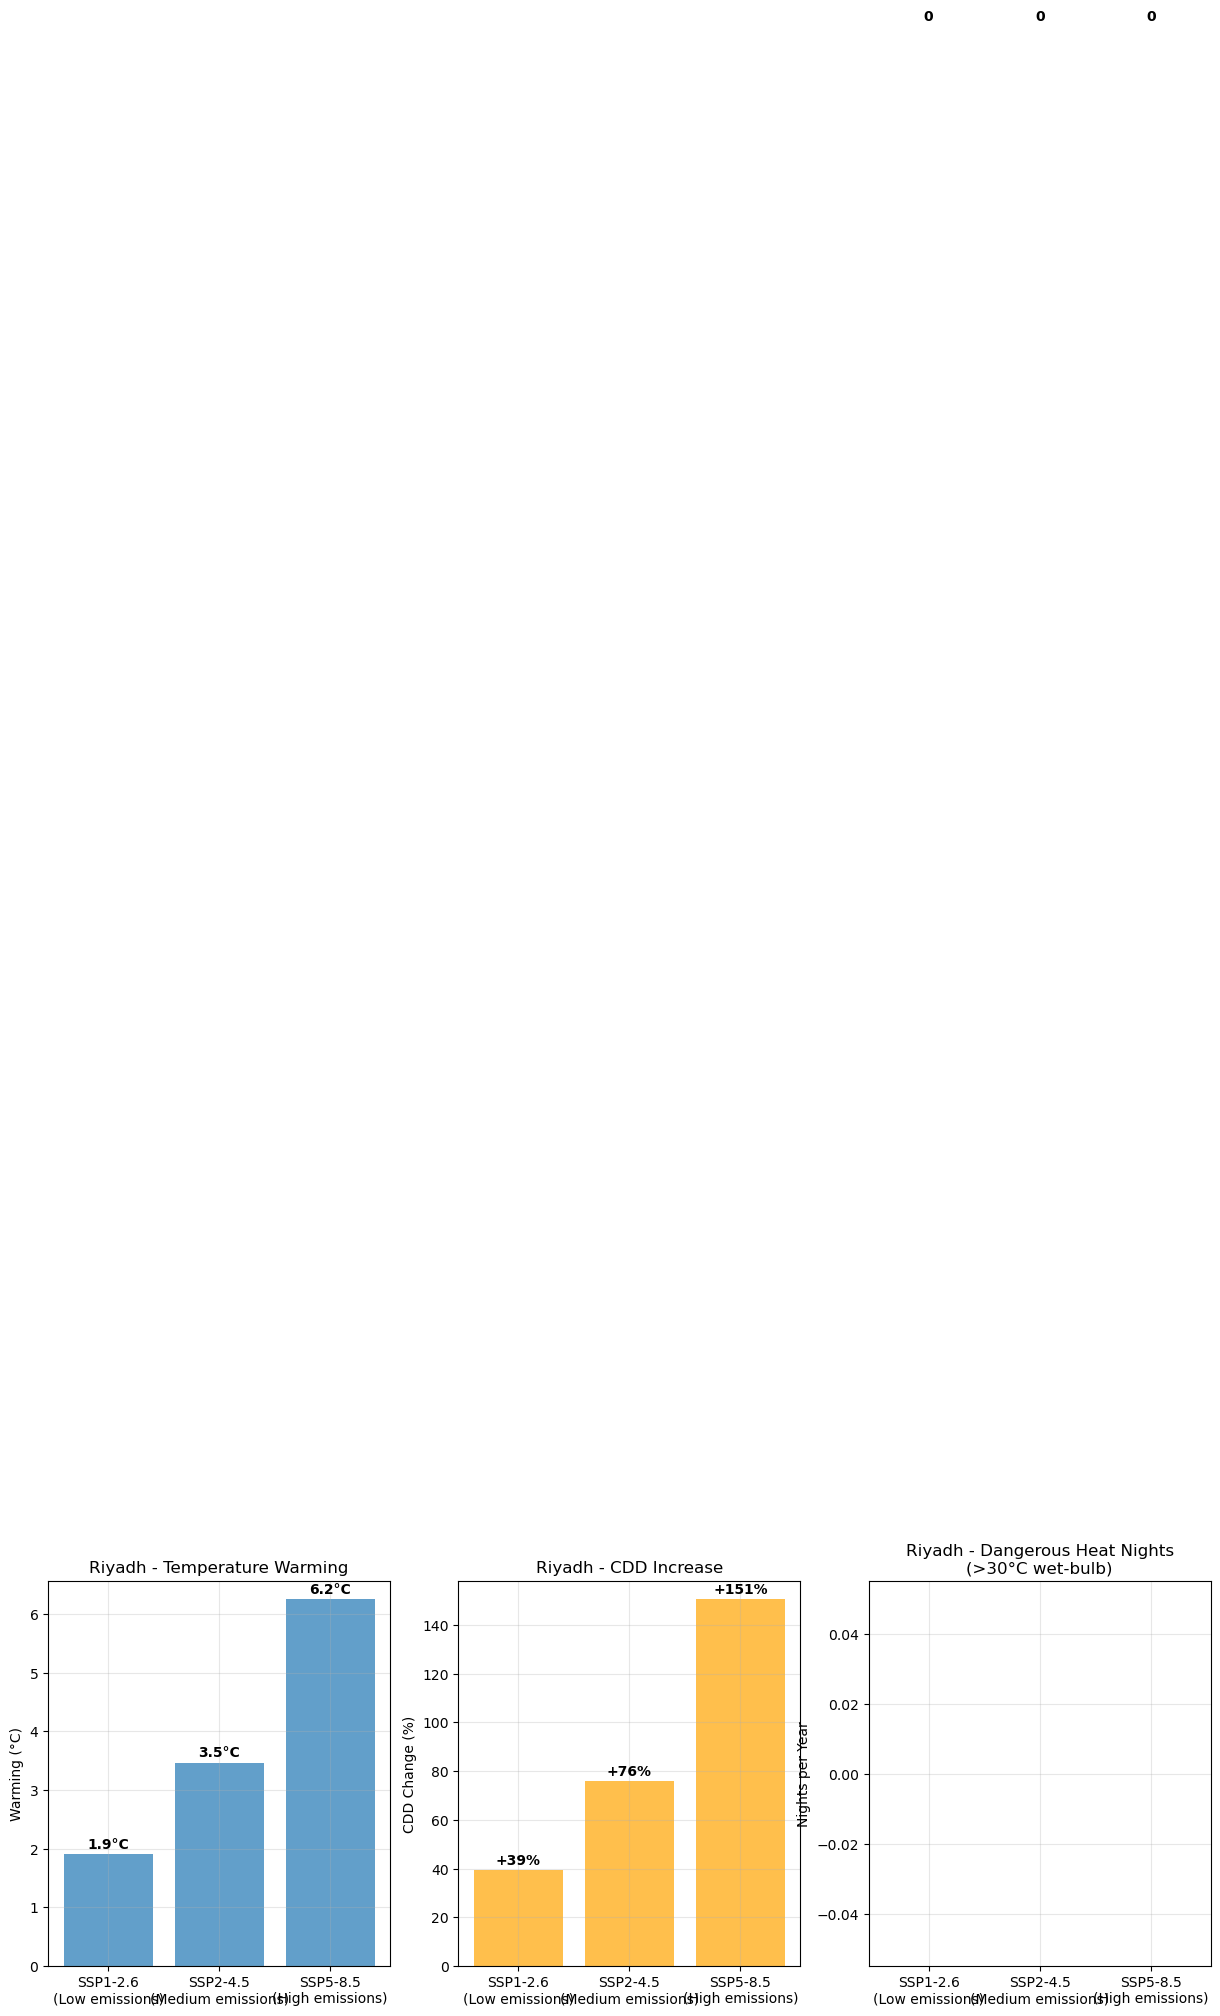

In [90]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xarray.coding.calendar_ops import convert_calendar

# Configuration
models = ['ACCESS-CM2', 'EC-Earth3', 'MPI-ESM1-2-HR']  # Back to ACCESS-CM2 with complete tasmin data
scenarios = ['ssp126', 'ssp245', 'ssp585']
cities = ['jeddah', 'riyadh']

def calculate_wet_bulb_stull(temp_c, rh_percent):
    """Calculate wet-bulb temperature using Stull (2011) approximation"""
    wb = temp_c * np.arctan(0.151977 * np.sqrt(rh_percent + 8.313659)) + \
         np.arctan(temp_c + rh_percent) - \
         np.arctan(rh_percent - 1.676331) + \
         0.00391838 * (rh_percent**1.5) * np.arctan(0.023101 * rh_percent) - \
         4.686035
    return wb

def calculate_cooling_degree_days_daily(temp_data, base_temp=18.3):
    """Calculate daily cooling degree days"""
    return np.maximum(0, temp_data - base_temp)

def load_historical_data(model, city):
    """Load historical model data (1985-2014)"""
    try:
        tasmin_file = f'cmip6_tasmin_cities/{model}_tasmin_historical_1985_2014_{city}.nc'
        hurs_file = f'cmip6_cities/{model}_hurs_historical_1985_2015_{city}.nc'
        
        tasmin_ds = xr.open_dataset(tasmin_file)
        hurs_ds = xr.open_dataset(hurs_file)
        
        # Align time periods (both to 1985-2014)
        hurs_aligned = hurs_ds.sel(time=hurs_ds.time.dt.year.isin(range(1985, 2015)))
        
        # Convert temperature to Celsius if needed
        temp = tasmin_ds.tasmin
        if temp.max() > 100:
            temp = temp - 273.15
        
        return temp, hurs_aligned.hurs
    except Exception as e:
        print(f"Error loading historical {model} data for {city}: {e}")
        return None, None

def load_future_data(model, scenario, city):
    """Load future scenario data (2070-2100) - using tasmin data for consistent comparison"""
    try:
        # Use tasmin data for consistent nighttime temperature comparison
        tasmin_file = f'cmip6_tasmin_cities/{model}_tasmin_{scenario}_2070_2100_{city}.nc'
        hurs_file = f'cmip6_cities/{model}_hurs_{scenario}_2070_2100_{city}.nc'
        
        tasmin_ds = xr.open_dataset(tasmin_file)
        hurs_ds = xr.open_dataset(hurs_file)
        
        # Convert temperature to Celsius if needed
        temp = tasmin_ds.tasmin  # Using tasmin (daily minimum) for future
        if temp.max() > 100:
            temp = temp - 273.15
        
        return temp, hurs_ds.hurs
    except Exception as e:
        print(f"  ⚠️  {model} {scenario} tasmin data not available for {city}")
        return None, None

def plot_temperature_warming(city):
    """Plot temperature changes: historical vs future"""
    
    plt.figure(figsize=(16, 10))
    
    # Scenario info for titles
    scenario_info = {
        'ssp126': 'SSP1-2.6 (Low emissions)',
        'ssp245': 'SSP2-4.5 (Medium emissions)', 
        'ssp585': 'SSP5-8.5 (High emissions)'
    }
    
    for i, scenario in enumerate(scenarios):
        plt.subplot(2, 3, i+1)
        
        warming_values = []
        model_names = []
        
        for model in models:
            # Load historical and future data
            hist_temp, _ = load_historical_data(model, city)
            fut_temp, _ = load_future_data(model, scenario, city)
            
            if hist_temp is not None and fut_temp is not None:
                # Calculate mean temperatures
                hist_mean = hist_temp.mean().values
                fut_mean = fut_temp.mean().values
                warming = fut_mean - hist_mean
                
                warming_values.append(warming)
                model_names.append(model)
        
        if warming_values:
            bars = plt.bar(model_names, warming_values, alpha=0.7)
            plt.title(f'{city.title()} - {scenario_info[scenario]}')
            plt.ylabel('Warming (°C)')
            plt.grid(True, alpha=0.3)
            
            # Add value labels on bars
            for bar, val in zip(bars, warming_values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                        f'{val:.1f}°C', ha='center', va='bottom', fontweight='bold')
    
    # Seasonal warming analysis
    plt.subplot(2, 3, 4)
    months = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
    
    for scenario in scenarios:
        seasonal_warming = []
        
        for month in range(1, 13):
            month_warming = []
            
            for model in models:
                hist_temp, _ = load_historical_data(model, city)
                fut_temp, _ = load_future_data(model, scenario, city)
                
                if hist_temp is not None and fut_temp is not None:
                    hist_month = hist_temp.groupby('time.month').mean().sel(month=month)
                    fut_month = fut_temp.groupby('time.month').mean().sel(month=month)
                    month_warming.append(fut_month.values - hist_month.values)
            
            if month_warming:
                seasonal_warming.append(np.mean(month_warming))
            else:
                seasonal_warming.append(np.nan)
        
        plt.plot(range(1, 13), seasonal_warming, 'o-', linewidth=2, 
                label=scenario_info[scenario])
    
    plt.title(f'{city.title()} - Seasonal Warming Patterns')
    plt.xlabel('Month')
    plt.ylabel('Warming (°C)')
    plt.xticks(range(1, 13), months)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_cdd_changes(city):
    """Plot CDD changes: historical vs future"""
    
    plt.figure(figsize=(16, 10))
    
    scenario_info = {
        'ssp126': 'SSP1-2.6', 'ssp245': 'SSP2-4.5', 'ssp585': 'SSP5-8.5'
    }
    
    # Historical CDD baseline
    plt.subplot(2, 2, 1)
    hist_cdd_models = []
    
    for model in models:
        hist_temp, _ = load_historical_data(model, city)
        if hist_temp is not None:
            hist_cdd = calculate_cooling_degree_days_daily(hist_temp)
            annual_cdd = hist_cdd.groupby('time.year').sum().mean()
            hist_cdd_models.append(annual_cdd.values)
    
    plt.bar(models, hist_cdd_models, alpha=0.7, color='gray')
    plt.title(f'{city.title()} - Historical CDD (1985-2014)')
    plt.ylabel('Annual CDD')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Future CDD by scenario
    for i, scenario in enumerate(scenarios):
        plt.subplot(2, 2, i+2)
        
        hist_values = []
        fut_values = []
        model_names = []
        
        for model in models:
            hist_temp, _ = load_historical_data(model, city)
            fut_temp, _ = load_future_data(model, scenario, city)
            
            if hist_temp is not None and fut_temp is not None:
                # Calculate CDDs
                hist_cdd = calculate_cooling_degree_days_daily(hist_temp)
                fut_cdd = calculate_cooling_degree_days_daily(fut_temp)
                
                hist_annual = hist_cdd.groupby('time.year').sum().mean().values
                fut_annual = fut_cdd.groupby('time.year').sum().mean().values
                
                hist_values.append(hist_annual)
                fut_values.append(fut_annual)
                model_names.append(model)
        
        if hist_values and fut_values:
            x = np.arange(len(model_names))
            width = 0.35
            
            plt.bar(x - width/2, hist_values, width, label='Historical', alpha=0.7)
            plt.bar(x + width/2, fut_values, width, label='Future', alpha=0.7)
            
            plt.title(f'{scenario_info[scenario]}')
            plt.ylabel('Annual CDD')
            plt.xticks(x, model_names, rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # Add change percentages
            for j, (hist, fut) in enumerate(zip(hist_values, fut_values)):
                change_pct = ((fut - hist) / hist) * 100
                plt.text(j, max(hist, fut) + 50, f'+{change_pct:.0f}%', 
                        ha='center', fontweight='bold', color='red')
    
    plt.tight_layout()
    plt.show()

def plot_wetbulb_changes(city):
    """Plot wet-bulb temperature changes and dangerous heat"""
    
    plt.figure(figsize=(15, 10))
    
    scenario_info = {
        'ssp126': 'SSP1-2.6', 'ssp245': 'SSP2-4.5', 'ssp585': 'SSP5-8.5'
    }
    
    # Monthly wet-bulb changes
    for i, scenario in enumerate(scenarios):
        plt.subplot(2, 3, i+1)
        
        months = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
        
        for model in models:
            hist_temp, hist_hurs = load_historical_data(model, city)
            fut_temp, fut_hurs = load_future_data(model, scenario, city)
            
            if hist_temp is not None and fut_temp is not None:
                # Calculate wet-bulb temperatures
                hist_wb = calculate_wet_bulb_stull(hist_temp, hist_hurs)
                fut_wb = calculate_wet_bulb_stull(fut_temp, fut_hurs)
                
                # Monthly means
                hist_monthly = hist_wb.groupby('time.month').mean()
                fut_monthly = fut_wb.groupby('time.month').mean()
                
                wb_change = fut_monthly - hist_monthly
                plt.plot(range(1, 13), wb_change, 'o-', linewidth=2, 
                        label=model, alpha=0.8)
        
        plt.title(f'{city.title()} - Wet-Bulb Change ({scenario_info[scenario]})')
        plt.xlabel('Month')
        plt.ylabel('Wet-Bulb Change (°C)')
        plt.xticks(range(1, 13), months)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Dangerous heat frequency
    plt.subplot(2, 3, 4)
    thresholds = [28, 30, 32]  # Different danger levels for nighttime
    
    scenario_colors = {'ssp126': 'blue', 'ssp245': 'orange', 'ssp585': 'red'}
    
    for threshold in thresholds:
        hist_dangerous = []
        fut_dangerous = {scenario: [] for scenario in scenarios}
        
        for model in models:
            # Historical dangerous nights
            hist_temp, hist_hurs = load_historical_data(model, city)
            if hist_temp is not None:
                hist_wb = calculate_wet_bulb_stull(hist_temp, hist_hurs)
                hist_danger = (hist_wb > threshold).groupby('time.year').sum().mean()
                hist_dangerous.append(hist_danger.values)
            
            # Future dangerous nights
            for scenario in scenarios:
                fut_temp, fut_hurs = load_future_data(model, scenario, city)
                if fut_temp is not None:
                    fut_wb = calculate_wet_bulb_stull(fut_temp, fut_hurs)
                    fut_danger = (fut_wb > threshold).groupby('time.year').sum().mean()
                    fut_dangerous[scenario].append(fut_danger.values)
        
        if hist_dangerous:
            x_pos = threshold - 27  # Offset for plotting
            
            # Plot historical baseline
            plt.bar(x_pos - 0.3, np.mean(hist_dangerous), 0.2, 
                   color='gray', alpha=0.7, label='Historical' if threshold == thresholds[0] else '')
            
            # Plot future scenarios
            for j, scenario in enumerate(scenarios):
                if fut_dangerous[scenario]:
                    plt.bar(x_pos + j*0.2 - 0.1, np.mean(fut_dangerous[scenario]), 0.2,
                           color=scenario_colors[scenario], alpha=0.7,
                           label=scenario_info[scenario] if threshold == thresholds[0] else '')
    
    plt.title(f'{city.title()} - Dangerous Heat Nights per Year')
    plt.xlabel('Wet-Bulb Threshold (°C)')
    plt.ylabel('Nights per Year')
    plt.xticks([1, 2, 3], ['28°C', '30°C', '32°C'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_era5_vs_future_comparison(city):
    """Compare ERA5 historical data vs future model projections"""
    
    # Load ERA5 data
    era5_file = f'era5_land_{city}_1985_2014_noleap.nc'
    try:
        ds_era5 = xr.open_dataset(era5_file)
        era5_temp = ds_era5['t2m'].mean(['latitude', 'longitude'])
        era5_rhum = ds_era5['rhum'].mean(['latitude', 'longitude'])
        print(f"✓ Loaded ERA5 data for {city}")
    except:
        print(f"✗ Could not load ERA5 data for {city}")
        return
    
    plt.figure(figsize=(15, 10))
    
    scenario_info = {
        'ssp126': 'SSP1-2.6 (Low)', 'ssp245': 'SSP2-4.5 (Medium)', 'ssp585': 'SSP5-8.5 (High)'
    }
    
    # Monthly temperature comparison
    plt.subplot(2, 3, 1)
    months = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
    
    # Plot ERA5 baseline
    era5_monthly = era5_temp.groupby('time.month').mean()
    plt.plot(range(1, 13), era5_monthly, 'ko-', linewidth=3, markersize=8, label='ERA5 (1985-2014)')
    
    # Plot future scenarios (model ensemble mean)
    colors = ['blue', 'orange', 'red']
    for i, scenario in enumerate(scenarios):
        scenario_monthly = []
        
        for month in range(1, 13):
            month_temps = []
            for model in models:
                fut_temp, _ = load_future_data(model, scenario, city)
                if fut_temp is not None:
                    month_temp = fut_temp.groupby('time.month').mean().sel(month=month)
                    month_temps.append(month_temp.values)
            
            if month_temps:
                scenario_monthly.append(np.mean(month_temps))
            else:
                scenario_monthly.append(np.nan)
        
        plt.plot(range(1, 13), scenario_monthly, 'o-', linewidth=2, 
                color=colors[i], label=f'{scenario_info[scenario]} (2070-2100)')
    
    plt.title(f'{city.title()} - Monthly Temperature: ERA5 vs Future')
    plt.xlabel('Month')
    plt.ylabel('Temperature (°C)')
    plt.xticks(range(1, 13), months)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Temperature warming from ERA5
    plt.subplot(2, 3, 2)
    era5_mean = era5_temp.mean().values
    
    warming_from_era5 = []
    scenario_labels = []
    
    for scenario in scenarios:
        scenario_temps = []
        for model in models:
            fut_temp, _ = load_future_data(model, scenario, city)
            if fut_temp is not None:
                scenario_temps.append(fut_temp.mean().values)
        
        if scenario_temps:
            fut_mean = np.mean(scenario_temps)
            warming = fut_mean - era5_mean
            warming_from_era5.append(warming)
            scenario_labels.append(scenario_info[scenario])
    
    bars = plt.bar(range(len(warming_from_era5)), warming_from_era5, 
                   color=['blue', 'orange', 'red'], alpha=0.7)
    plt.title(f'{city.title()} - Warming from ERA5 Baseline')
    plt.ylabel('Warming (°C)')
    plt.xticks(range(len(scenario_labels)), scenario_labels, rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars, warming_from_era5):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'+{val:.1f}°C', ha='center', va='bottom', fontweight='bold')
    
    # CDD comparison
    plt.subplot(2, 3, 3)
    
    # ERA5 CDD
    era5_cdd = calculate_cooling_degree_days_daily(era5_temp)
    era5_annual_cdd = era5_cdd.groupby('time.year').sum().mean().values
    
    cdd_values = [era5_annual_cdd]
    cdd_labels = ['ERA5']
    
    for scenario in scenarios:
        scenario_cdd = []
        for model in models:
            fut_temp, _ = load_future_data(model, scenario, city)
            if fut_temp is not None:
                fut_cdd = calculate_cooling_degree_days_daily(fut_temp)
                annual_cdd = fut_cdd.groupby('time.year').sum().mean().values
                scenario_cdd.append(annual_cdd)
        
        if scenario_cdd:
            cdd_values.append(np.mean(scenario_cdd))
            cdd_labels.append(scenario_info[scenario])
    
    colors_cdd = ['gray', 'blue', 'orange', 'red']
    bars = plt.bar(range(len(cdd_values)), cdd_values, color=colors_cdd, alpha=0.7)
    plt.title(f'{city.title()} - Annual CDD: ERA5 vs Future')
    plt.ylabel('Annual CDD')
    plt.xticks(range(len(cdd_labels)), cdd_labels, rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add percentage change labels
    for i, (bar, val) in enumerate(zip(bars[1:], cdd_values[1:]), 1):
        change_pct = ((val - era5_annual_cdd) / era5_annual_cdd) * 100
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                f'+{change_pct:.0f}%', ha='center', va='bottom', fontweight='bold')
    
    # Wet-bulb comparison
    plt.subplot(2, 3, 4)
    
    # ERA5 wet-bulb
    era5_wb = calculate_wet_bulb_stull(era5_temp, era5_rhum)
    era5_monthly_wb = era5_wb.groupby('time.month').mean()
    
    plt.plot(range(1, 13), era5_monthly_wb, 'ko-', linewidth=3, markersize=8, label='ERA5')
    
    for i, scenario in enumerate(scenarios):
        scenario_wb_monthly = []
        
        for month in range(1, 13):
            month_wb = []
            for model in models:
                fut_temp, fut_hurs = load_future_data(model, scenario, city)
                if fut_temp is not None:
                    fut_wb = calculate_wet_bulb_stull(fut_temp, fut_hurs)
                    month_wb_val = fut_wb.groupby('time.month').mean().sel(month=month)
                    month_wb.append(month_wb_val.values)
            
            if month_wb:
                scenario_wb_monthly.append(np.mean(month_wb))
            else:
                scenario_wb_monthly.append(np.nan)
        
        plt.plot(range(1, 13), scenario_wb_monthly, 'o-', linewidth=2, 
                color=colors[i], label=scenario_info[scenario])
    
    plt.title(f'{city.title()} - Monthly Wet-Bulb: ERA5 vs Future')
    plt.xlabel('Month')
    plt.ylabel('Wet-Bulb Temperature (°C)')
    plt.xticks(range(1, 13), months)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Dangerous heat nights comparison
    plt.subplot(2, 3, 5)
    
    # ERA5 dangerous nights
    era5_dangerous = (era5_wb > 30).groupby('time.year').sum().mean().values
    
    danger_values = [era5_dangerous]
    danger_labels = ['ERA5']
    
    for scenario in scenarios:
        scenario_danger = []
        for model in models:
            fut_temp, fut_hurs = load_future_data(model, scenario, city)
            if fut_temp is not None:
                fut_wb = calculate_wet_bulb_stull(fut_temp, fut_hurs)
                danger_nights = (fut_wb > 30).groupby('time.year').sum().mean().values
                scenario_danger.append(danger_nights)
        
        if scenario_danger:
            danger_values.append(np.mean(scenario_danger))
            danger_labels.append(scenario_info[scenario])
    
    bars = plt.bar(range(len(danger_values)), danger_values, color=colors_cdd, alpha=0.7)
    plt.title(f'{city.title()} - Dangerous Heat Nights\n(>30°C wet-bulb)')
    plt.ylabel('Nights per Year')
    plt.xticks(range(len(danger_labels)), danger_labels, rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars, danger_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{city.title()} - ERA5 vs Future Summary:")
    print(f"ERA5 baseline (1985-2014): {era5_mean:.1f}°C")
    for i, scenario in enumerate(scenarios):
        if i < len(warming_from_era5):
            print(f"{scenario_info[scenario]}: +{warming_from_era5[i]:.1f}°C warming")
    print(f"ERA5 dangerous nights: {era5_dangerous:.0f} per year")
    for i, scenario in enumerate(scenarios):
        if i+1 < len(danger_values):
            print(f"{scenario_info[scenario]} dangerous nights: {danger_values[i+1]:.0f} per year")
    """Compare all scenarios side by side"""
    
    plt.figure(figsize=(15, 5))
    
    scenario_info = {
        'ssp126': 'SSP1-2.6\n(Low emissions)', 
        'ssp245': 'SSP2-4.5\n(Medium emissions)', 
        'ssp585': 'SSP5-8.5\n(High emissions)'
    }
    
    # Temperature warming
    plt.subplot(1, 3, 1)
    scenario_warming = []
    
    for scenario in scenarios:
        warming_values = []
        for model in models:
            hist_temp, _ = load_historical_data(model, city)
            fut_temp, _ = load_future_data(model, scenario, city)
            
            if hist_temp is not None and fut_temp is not None:
                warming = fut_temp.mean().values - hist_temp.mean().values
                warming_values.append(warming)
        
        if warming_values:
            scenario_warming.append(np.mean(warming_values))
    
    bars1 = plt.bar(range(len(scenarios)), scenario_warming, alpha=0.7)
    plt.title(f'{city.title()} - Temperature Warming')
    plt.ylabel('Warming (°C)')
    plt.xticks(range(len(scenarios)), [scenario_info[s] for s in scenarios])
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars1, scenario_warming):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                f'{val:.1f}°C', ha='center', va='bottom', fontweight='bold')
    
    # CDD changes
    plt.subplot(1, 3, 2)
    scenario_cdd_change = []
    
    for scenario in scenarios:
        cdd_changes = []
        for model in models:
            hist_temp, _ = load_historical_data(model, city)
            fut_temp, _ = load_future_data(model, scenario, city)
            
            if hist_temp is not None and fut_temp is not None:
                hist_cdd = calculate_cooling_degree_days_daily(hist_temp).groupby('time.year').sum().mean()
                fut_cdd = calculate_cooling_degree_days_daily(fut_temp).groupby('time.year').sum().mean()
                change_pct = ((fut_cdd - hist_cdd) / hist_cdd * 100).values
                cdd_changes.append(change_pct)
        
        if cdd_changes:
            scenario_cdd_change.append(np.mean(cdd_changes))
    
    bars2 = plt.bar(range(len(scenarios)), scenario_cdd_change, alpha=0.7, color='orange')
    plt.title(f'{city.title()} - CDD Increase')
    plt.ylabel('CDD Change (%)')
    plt.xticks(range(len(scenarios)), [scenario_info[s] for s in scenarios])
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars2, scenario_cdd_change):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'+{val:.0f}%', ha='center', va='bottom', fontweight='bold')
    
    # Dangerous heat nights
    plt.subplot(1, 3, 3)
    scenario_danger = []
    
    for scenario in scenarios:
        danger_nights = []
        for model in models:
            hist_temp, hist_hurs = load_historical_data(model, city)
            fut_temp, fut_hurs = load_future_data(model, scenario, city)
            
            if hist_temp is not None and fut_temp is not None:
                fut_wb = calculate_wet_bulb_stull(fut_temp, fut_hurs)
                danger = (fut_wb > 30).groupby('time.year').sum().mean().values
                danger_nights.append(danger)
        
        if danger_nights:
            scenario_danger.append(np.mean(danger_nights))
    
    bars3 = plt.bar(range(len(scenarios)), scenario_danger, alpha=0.7, color='red')
    plt.title(f'{city.title()} - Dangerous Heat Nights\n(>30°C wet-bulb)')
    plt.ylabel('Nights per Year')
    plt.xticks(range(len(scenarios)), [scenario_info[s] for s in scenarios])
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars3, scenario_danger):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def run_future_analysis():
    """Run complete future climate analysis"""
    
    print("=== Historical vs Future Climate Analysis ===\n")
    
    for city in cities:
        print(f"\n{'='*60}")
        print(f"FUTURE CLIMATE ANALYSIS FOR {city.upper()}")
        print(f"{'='*60}")
        
        print("\n1. Temperature Warming Analysis")
        plot_temperature_warming(city)
        
        print("\n2. Cooling Degree Days Changes")
        plot_cdd_changes(city)
        
        print("\n3. Wet-Bulb Temperature Projections")
        plot_wetbulb_changes(city)
        
        print("\n4. ERA5 vs Future Projections")
        plot_era5_vs_future_comparison(city)
        
        print("\n5. Scenario Comparison Summary")
        plot_scenario_comparison(city)

if __name__ == "__main__":
    run_future_analysis()

=== CLEAN FUTURE CLIMATE ANALYSIS WITH LARGE, READABLE PLOTS ===
Each plot is now large, clear, and properly spaced for presentations!

CLEAN CLIMATE ANALYSIS FOR JEDDAH

📊 Plot 1: Monthly Temperature Comparison
✓ Loaded ERA5 data for jeddah


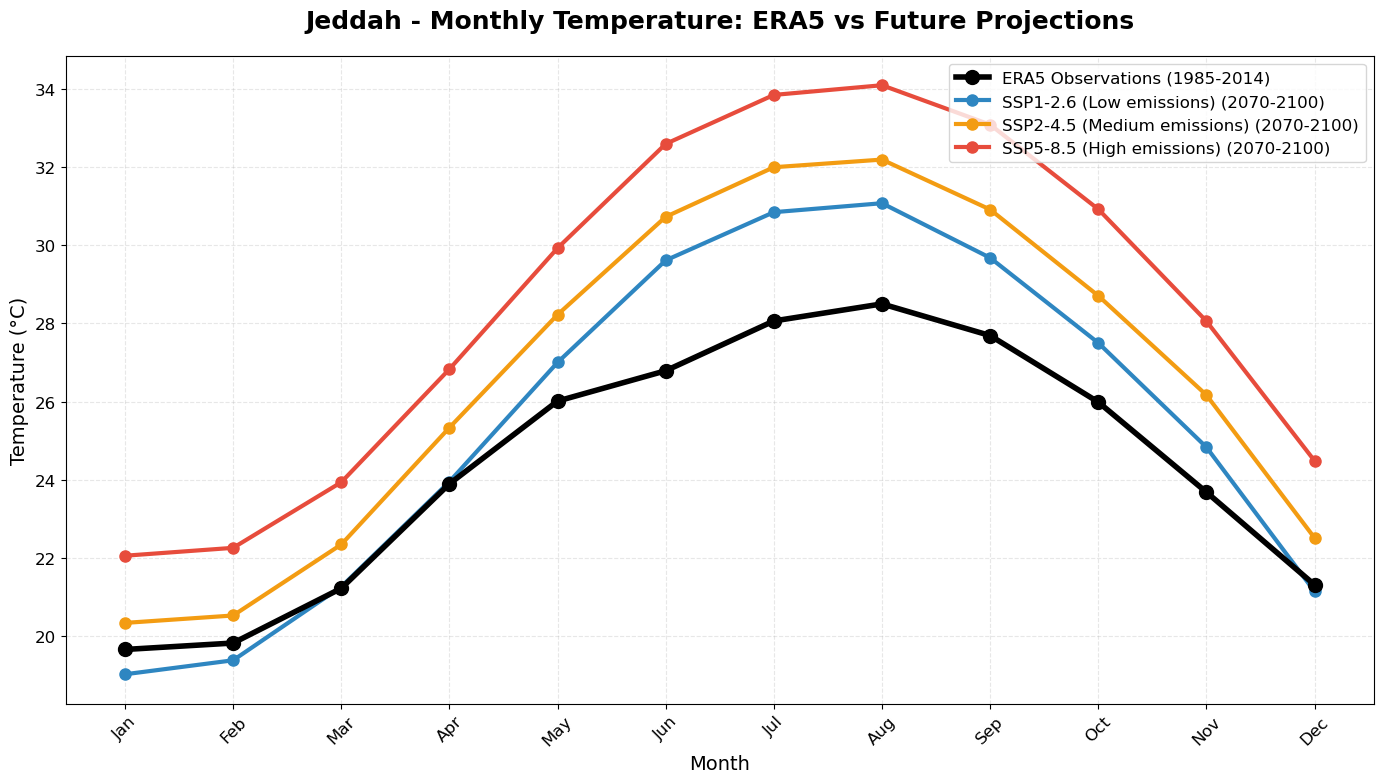


📊 Plot 2: Temperature Warming from ERA5
✓ Loaded ERA5 data for jeddah


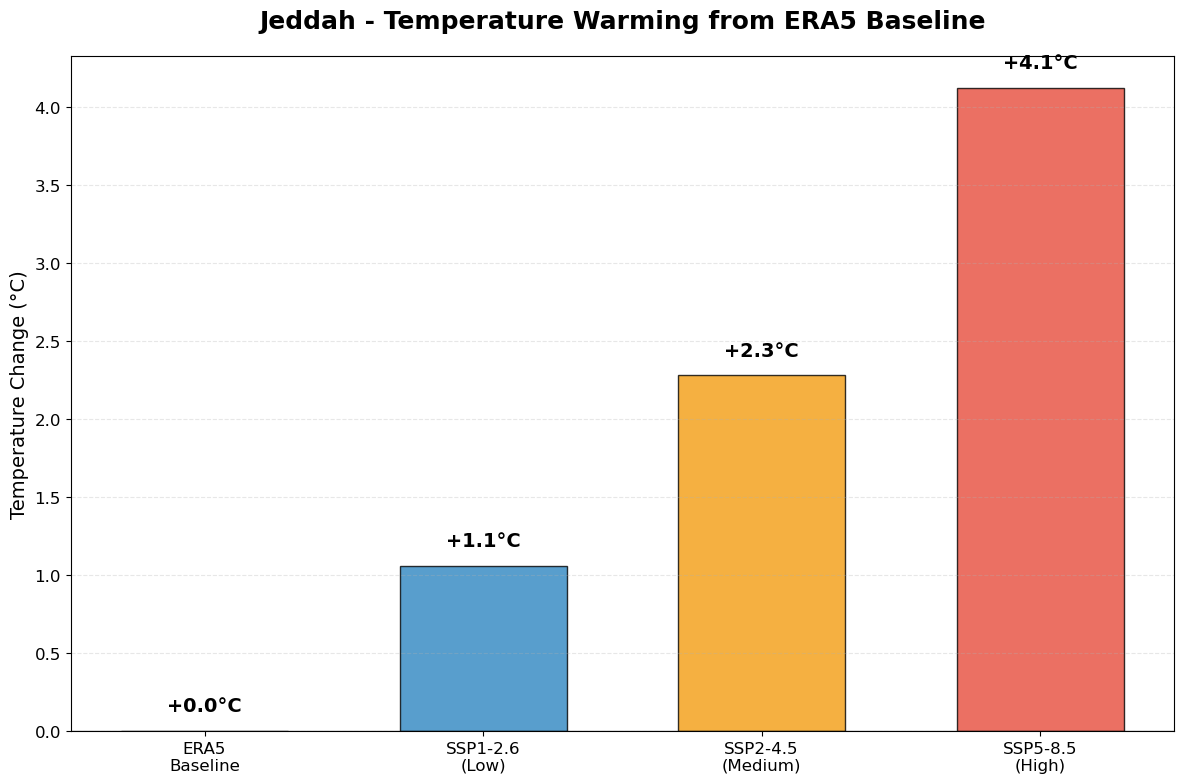


📊 Plot 3: Cooling Degree Days
✓ Loaded ERA5 data for jeddah


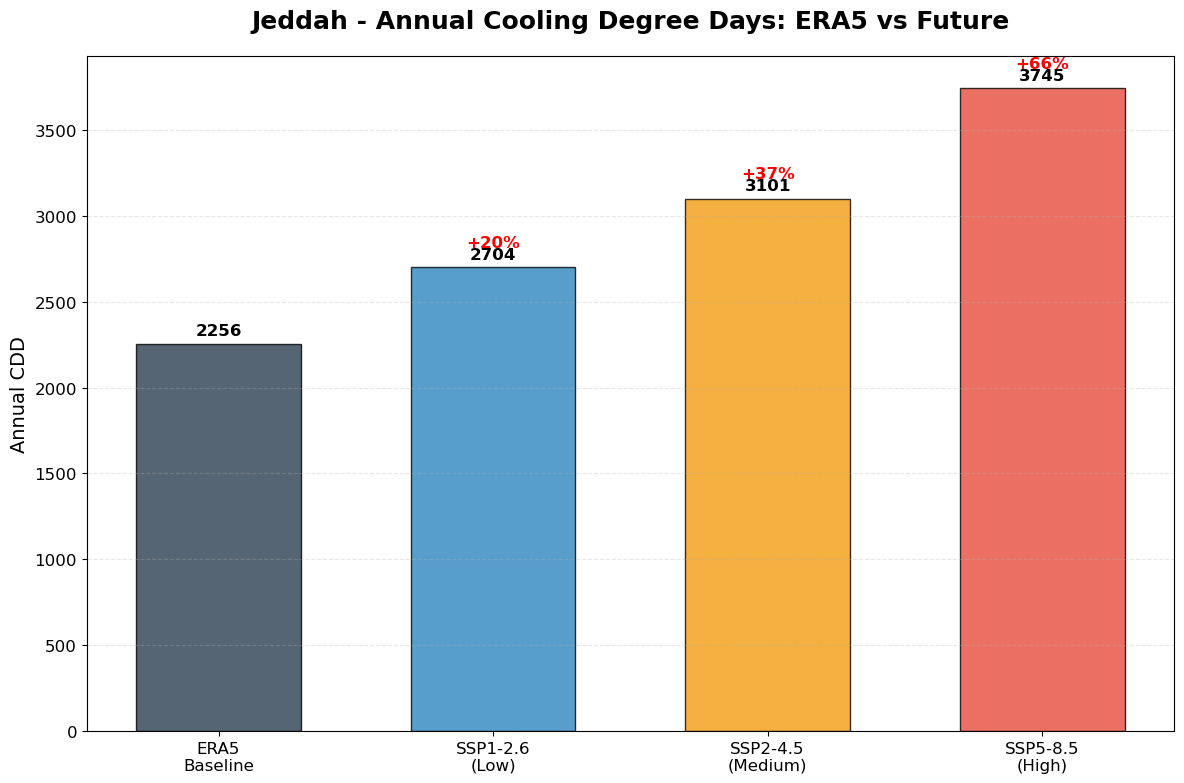


📊 Plot 4: Dangerous Heat Nights
✓ Loaded ERA5 data for jeddah


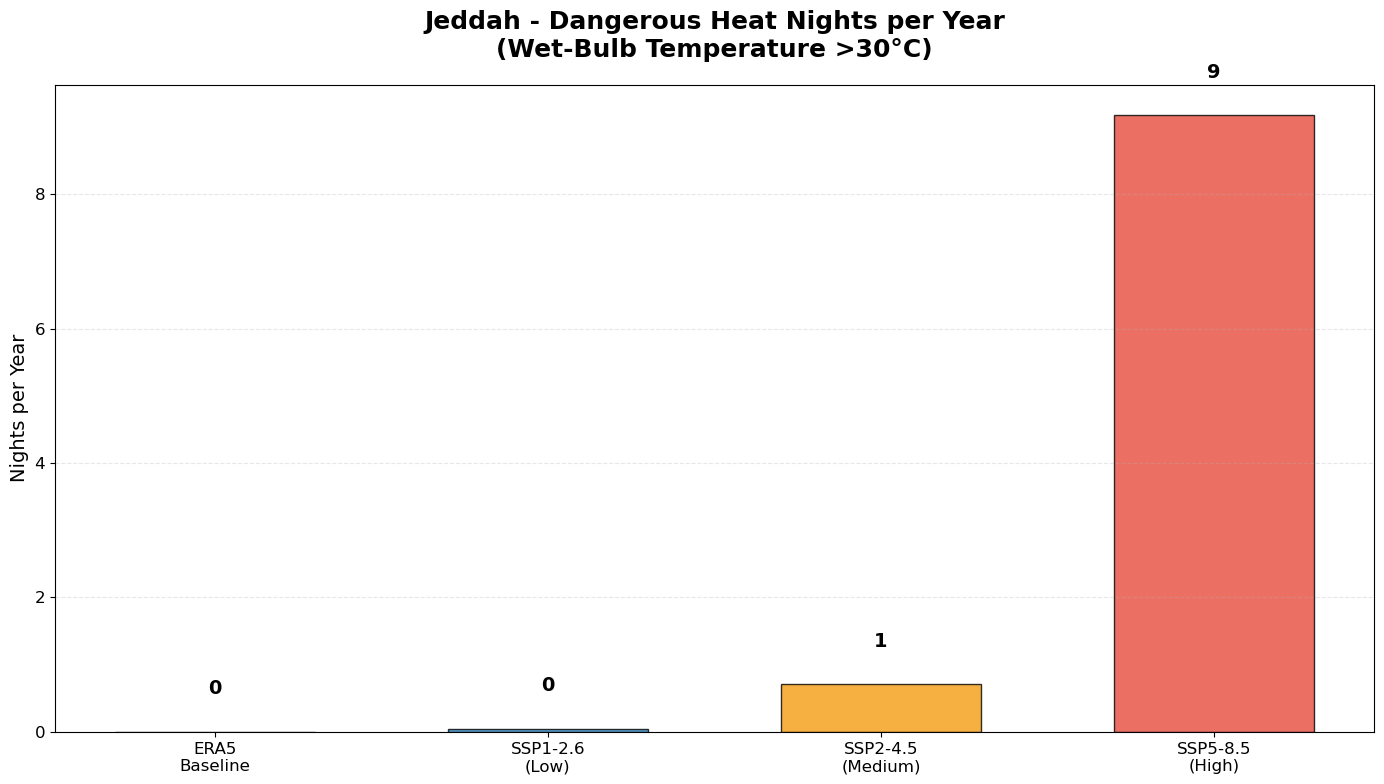


📊 Plot 5: Monthly Wet-Bulb Temperature
✓ Loaded ERA5 data for jeddah


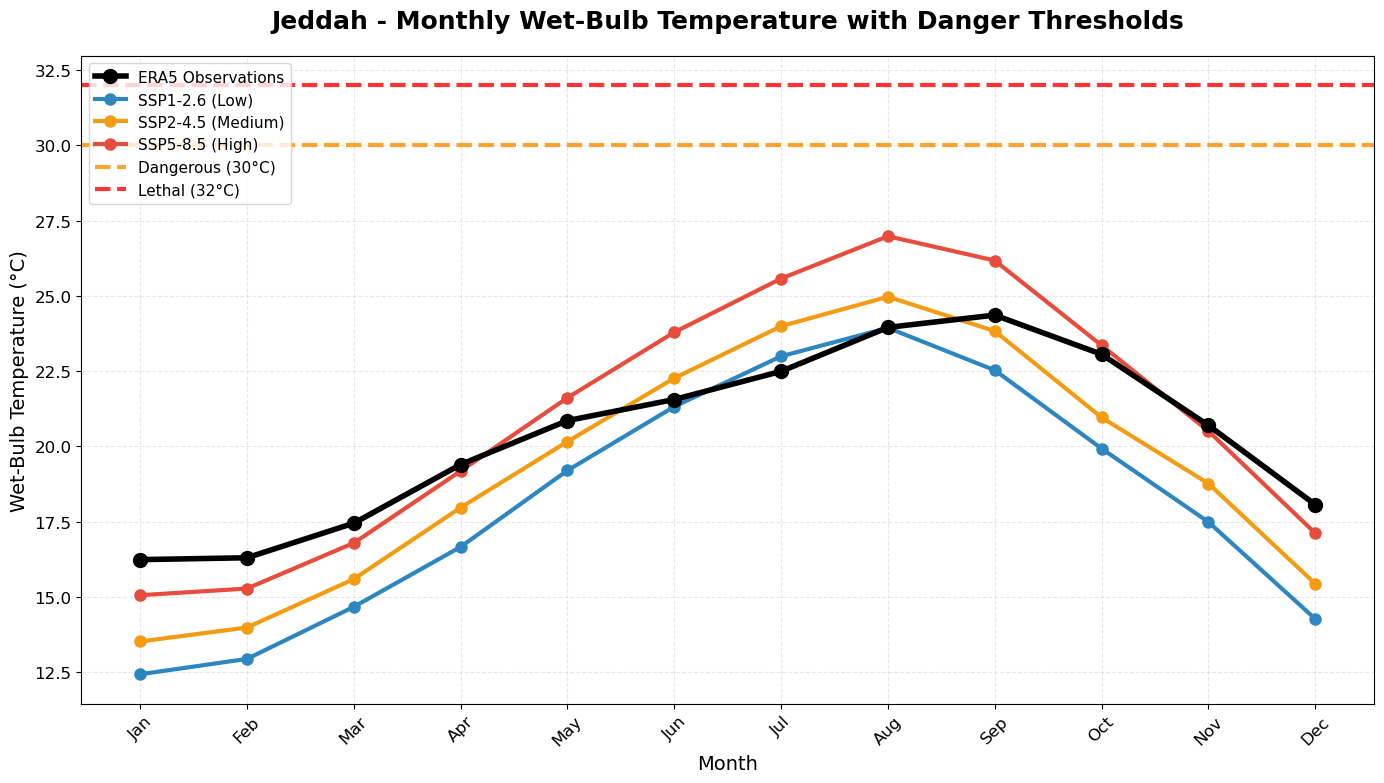


📊 Plot 6: Heat Stress Thresholds
✓ Loaded ERA5 data for jeddah


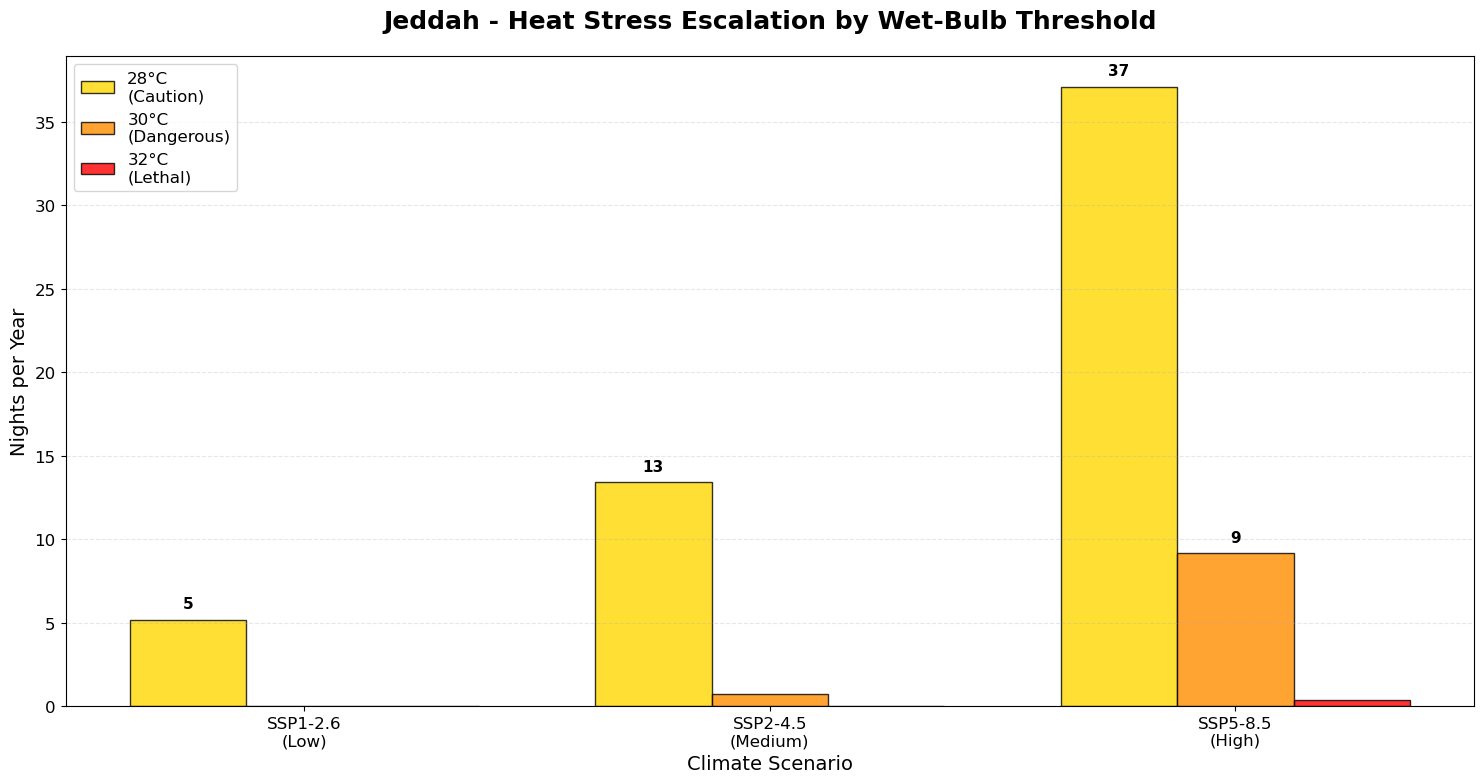

✓ Loaded ERA5 data for jeddah

📋 SUMMARY FOR JEDDAH:
   ERA5 baseline temperature: 24.4°C
   ERA5 dangerous nights (>30°C wet-bulb): 0 per year
   SSP126: +1.1°C warming, 0 dangerous nights
   SSP245: +2.3°C warming, 1 dangerous nights
   SSP585: +4.1°C warming, 9 dangerous nights

✅ Completed analysis for jeddah

CLEAN CLIMATE ANALYSIS FOR RIYADH

📊 Plot 1: Monthly Temperature Comparison
✓ Loaded ERA5 data for riyadh


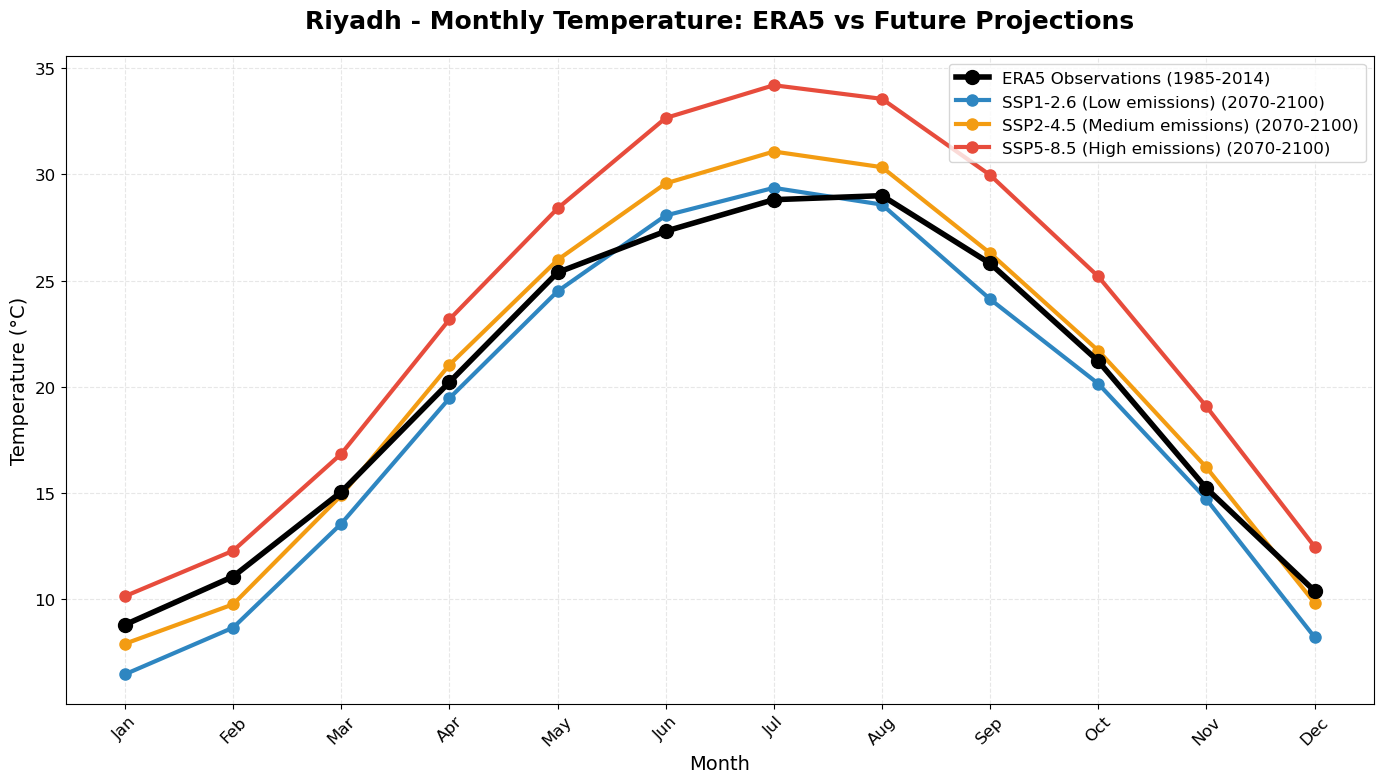


📊 Plot 2: Temperature Warming from ERA5
✓ Loaded ERA5 data for riyadh


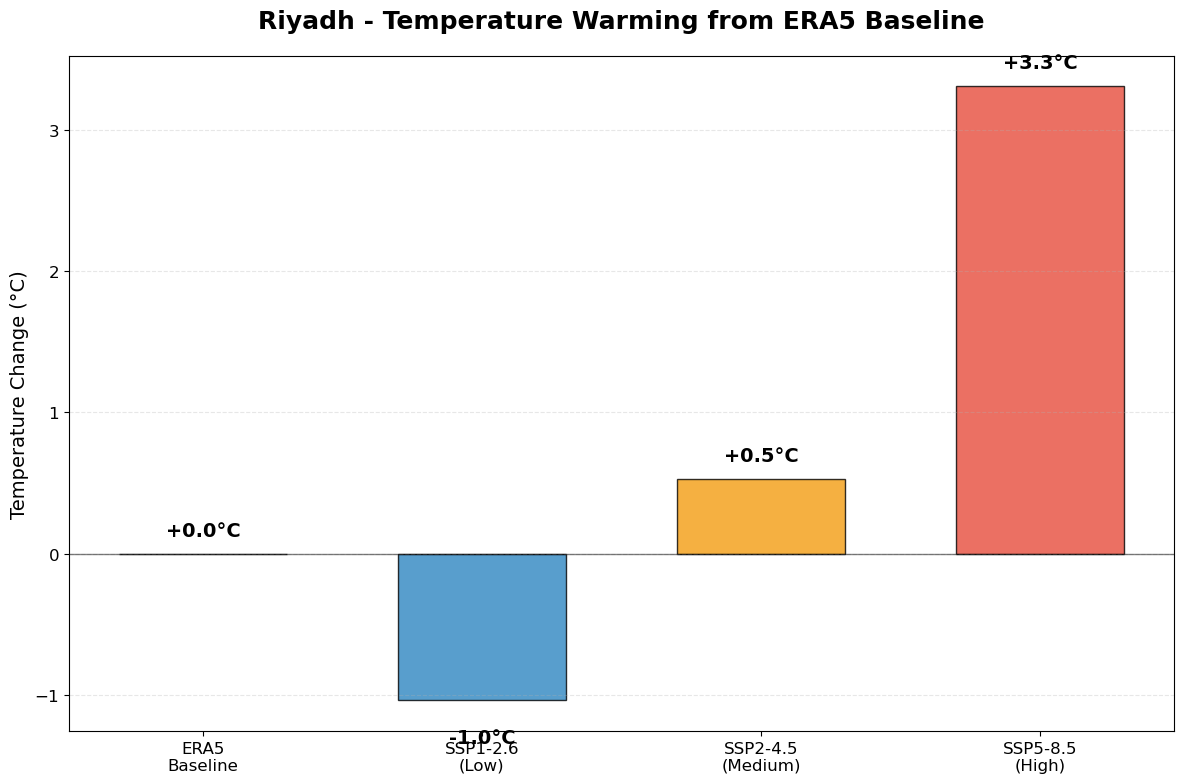


📊 Plot 3: Cooling Degree Days
✓ Loaded ERA5 data for riyadh


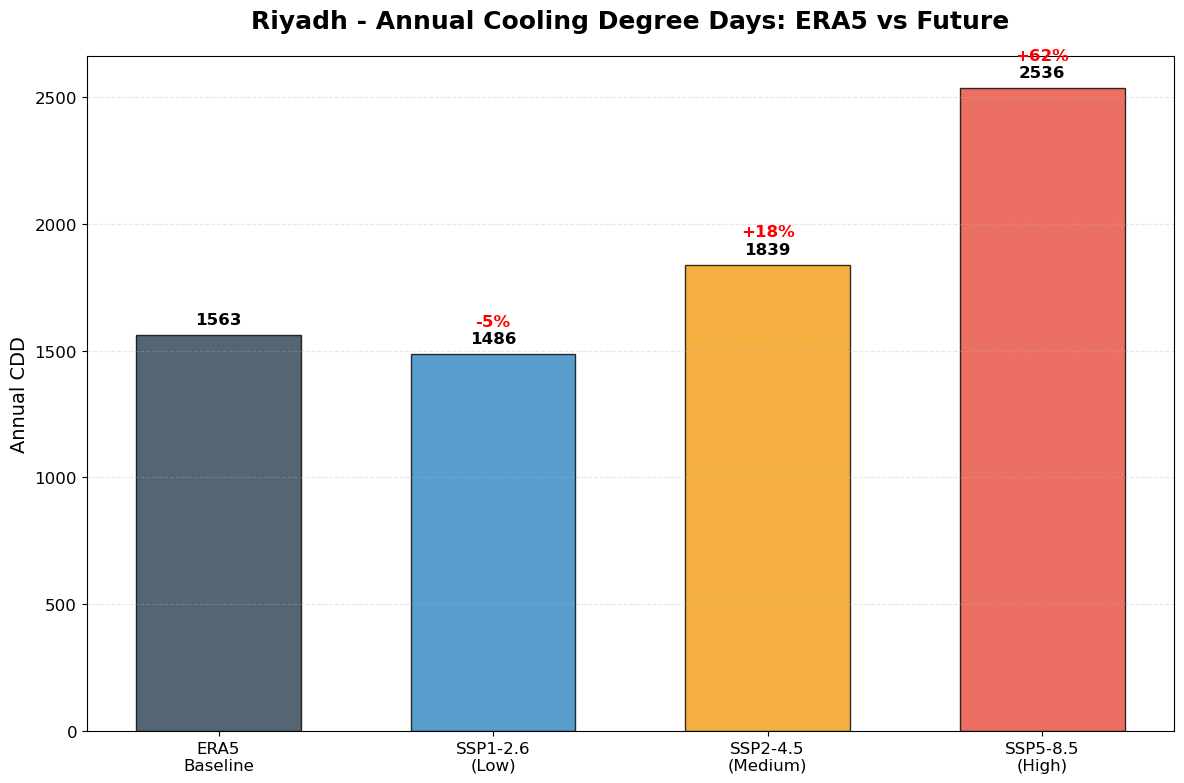


📊 Plot 4: Dangerous Heat Nights
✓ Loaded ERA5 data for riyadh


/tmp/ipykernel_23142/1797295209.py:339: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


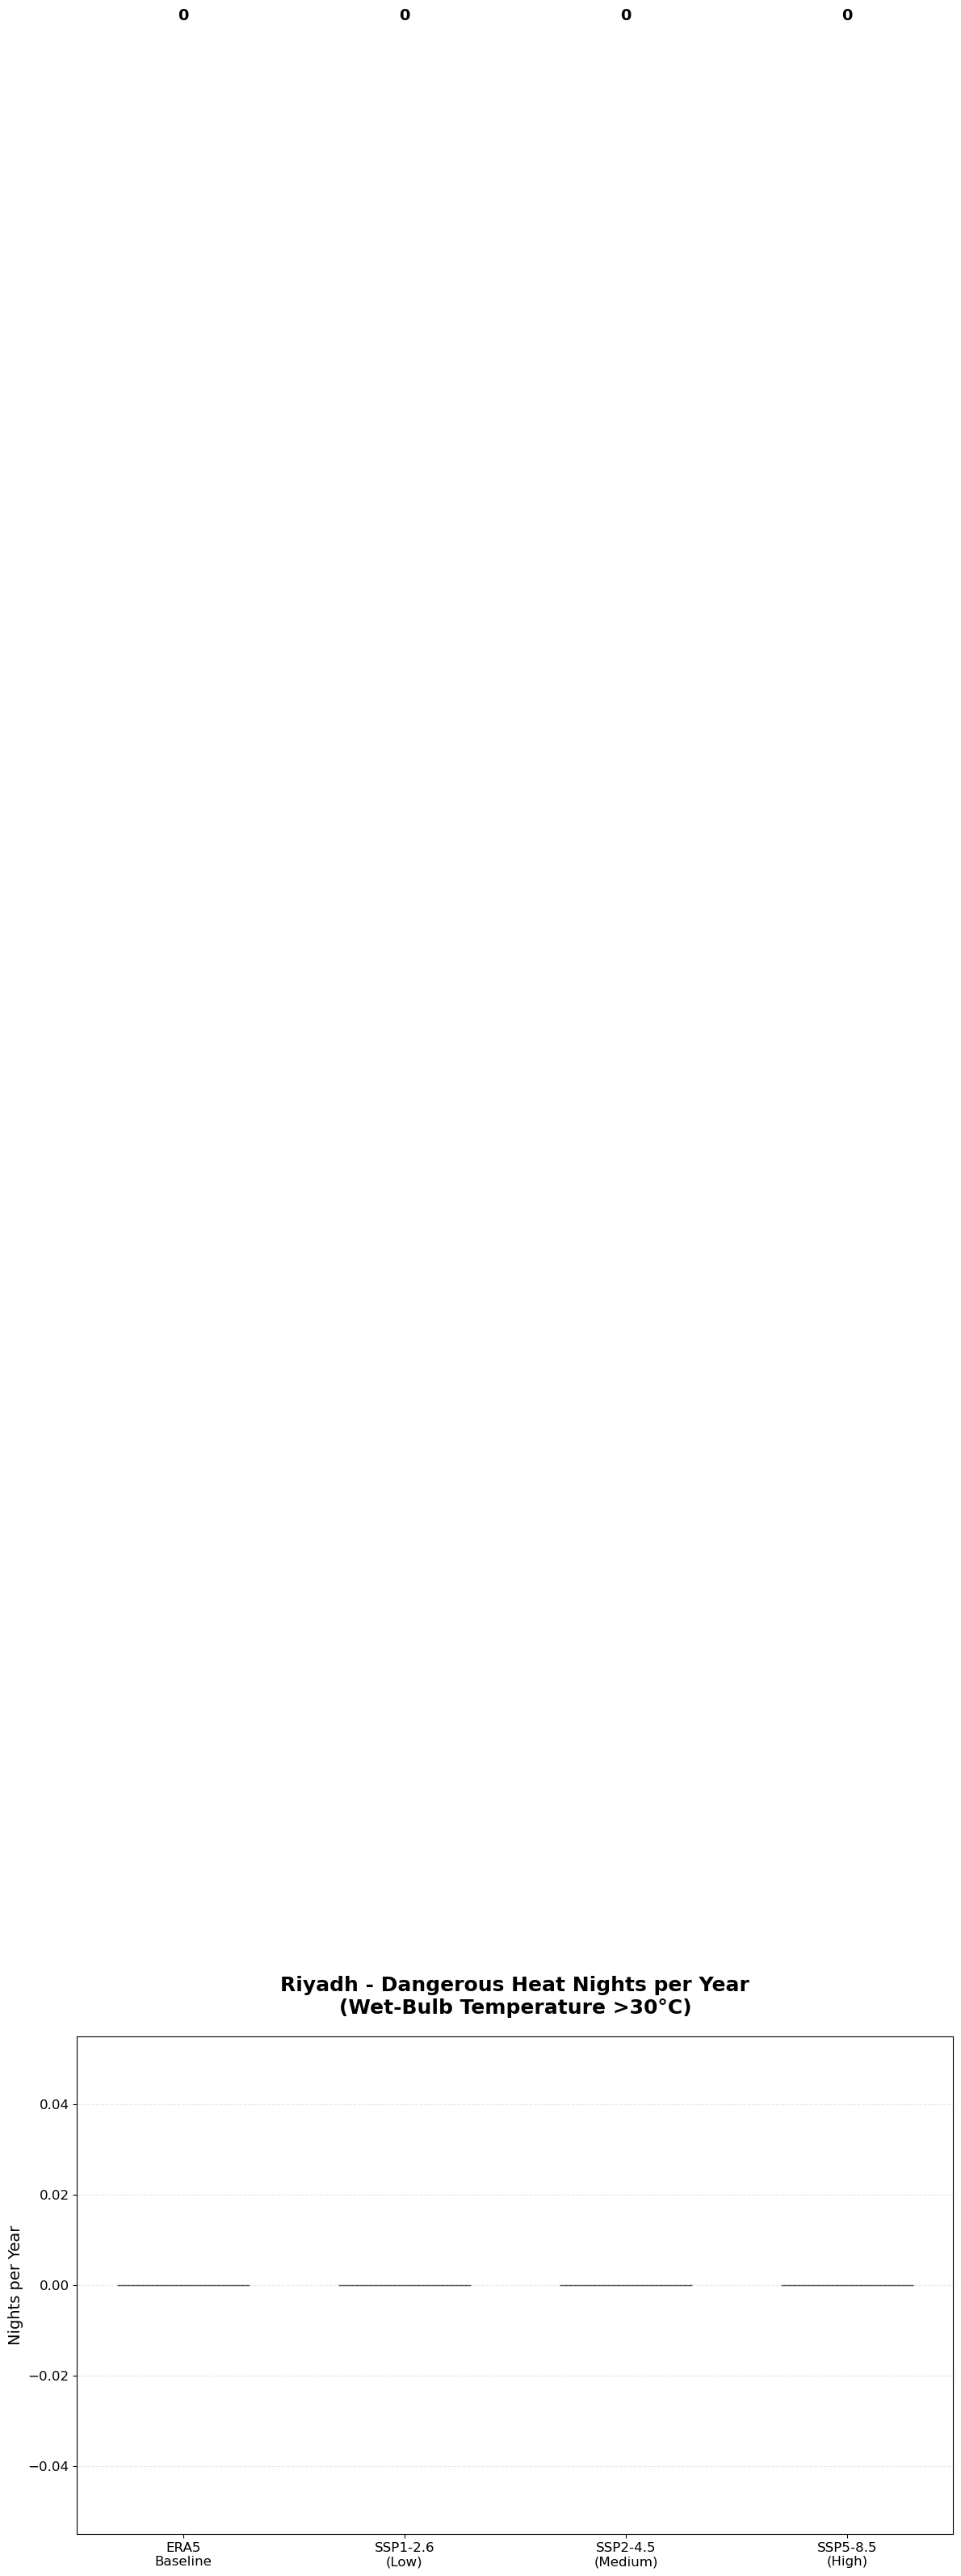


📊 Plot 5: Monthly Wet-Bulb Temperature
✓ Loaded ERA5 data for riyadh


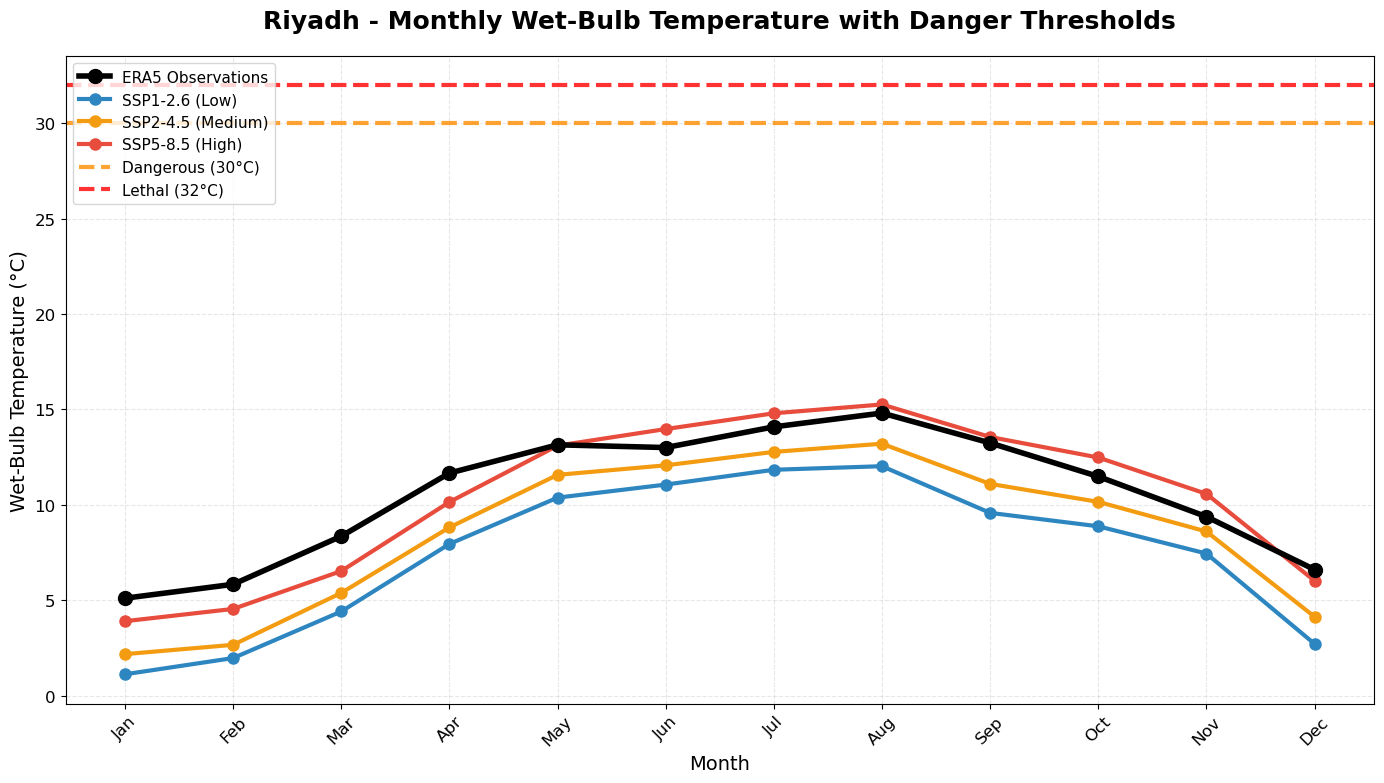


📊 Plot 6: Heat Stress Thresholds
✓ Loaded ERA5 data for riyadh


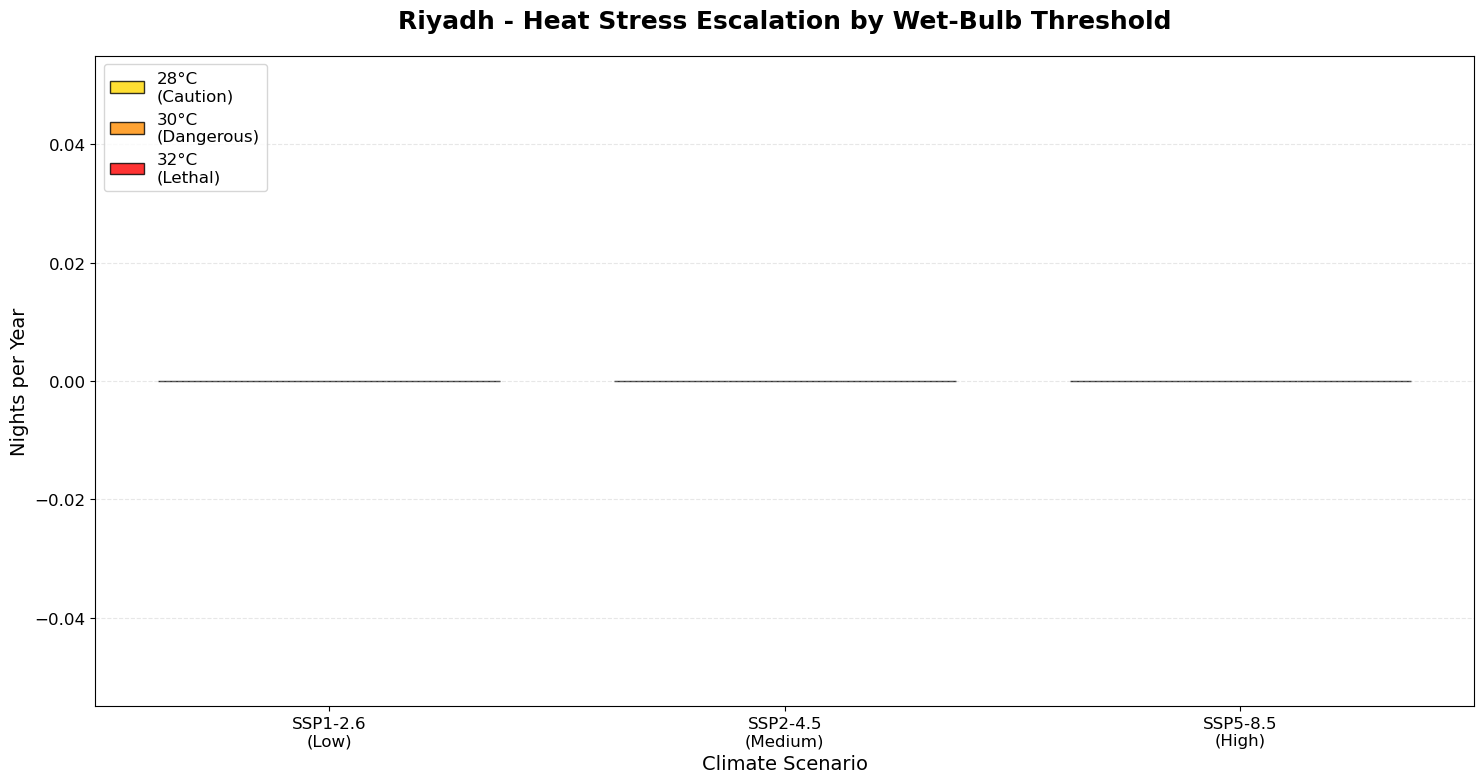

✓ Loaded ERA5 data for riyadh

📋 SUMMARY FOR RIYADH:
   ERA5 baseline temperature: 19.9°C
   ERA5 dangerous nights (>30°C wet-bulb): 0 per year
   SSP126: -1.0°C warming, 0 dangerous nights
   SSP245: +0.5°C warming, 0 dangerous nights
   SSP585: +3.3°C warming, 0 dangerous nights

✅ Completed analysis for riyadh


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xarray.coding.calendar_ops import convert_calendar

# Set matplotlib parameters for better plots
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 18,
    'figure.dpi': 100
})

# Configuration
models = ['ACCESS-CM2', 'EC-Earth3', 'MPI-ESM1-2-HR']
scenarios = ['ssp126', 'ssp245', 'ssp585']
cities = ['jeddah', 'riyadh']

def calculate_wet_bulb_stull(temp_c, rh_percent):
    """Calculate wet-bulb temperature using Stull (2011) approximation"""
    wb = temp_c * np.arctan(0.151977 * np.sqrt(rh_percent + 8.313659)) + \
         np.arctan(temp_c + rh_percent) - \
         np.arctan(rh_percent - 1.676331) + \
         0.00391838 * (rh_percent**1.5) * np.arctan(0.023101 * rh_percent) - \
         4.686035
    return wb

def calculate_cooling_degree_days_daily(temp_data, base_temp=18.3):
    """Calculate daily cooling degree days"""
    return np.maximum(0, temp_data - base_temp)

def load_era5_data(city):
    """Load ERA5 observational data (1985-2014)"""
    try:
        era5_file = f'era5_land_{city}_1985_2014_noleap.nc'
        ds_era5 = xr.open_dataset(era5_file)
        era5_temp = ds_era5['t2m'].mean(['latitude', 'longitude'])
        era5_rhum = ds_era5['rhum'].mean(['latitude', 'longitude'])
        print(f"✓ Loaded ERA5 data for {city}")
        return era5_temp, era5_rhum
    except Exception as e:
        print(f"✗ Could not load ERA5 data for {city}: {e}")
        return None, None

def load_historical_data(model, city):
    """Load historical model data (1985-2014)"""
    try:
        tasmin_file = f'cmip6_tasmin_cities/{model}_tasmin_historical_1985_2014_{city}.nc'
        hurs_file = f'cmip6_cities/{model}_hurs_historical_1985_2015_{city}.nc'
        
        tasmin_ds = xr.open_dataset(tasmin_file)
        hurs_ds = xr.open_dataset(hurs_file)
        
        hurs_aligned = hurs_ds.sel(time=hurs_ds.time.dt.year.isin(range(1985, 2015)))
        
        temp = tasmin_ds.tasmin
        if temp.max() > 100:
            temp = temp - 273.15
        
        return temp, hurs_aligned.hurs
    except Exception as e:
        print(f"Error loading historical {model} data for {city}: {e}")
        return None, None

def load_future_data(model, scenario, city):
    """Load future scenario data (2070-2100)"""
    try:
        tasmin_file = f'cmip6_tasmin_cities/{model}_tasmin_{scenario}_2070_2100_{city}.nc'
        hurs_file = f'cmip6_cities/{model}_hurs_{scenario}_2070_2100_{city}.nc'
        
        tasmin_ds = xr.open_dataset(tasmin_file)
        hurs_ds = xr.open_dataset(hurs_file)
        
        temp = tasmin_ds.tasmin
        if temp.max() > 100:
            temp = temp - 273.15
        
        return temp, hurs_ds.hurs
    except Exception as e:
        print(f"  ⚠️  {model} {scenario} data not available for {city}")
        return None, None

def plot_temperature_comparison(city):
    """Plot 1: Monthly Temperature - ERA5 vs Future (LARGE & CLEAR)"""
    
    # Load ERA5 data
    era5_temp, era5_rhum = load_era5_data(city)
    if era5_temp is None:
        return
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # ERA5 baseline (thick black line)
    era5_monthly = era5_temp.groupby('time.month').mean()
    ax.plot(range(1, 13), era5_monthly, 'ko-', linewidth=4, markersize=10, 
            label='ERA5 Observations (1985-2014)', zorder=10)
    
    # Future scenarios
    scenario_info = {
        'ssp126': 'SSP1-2.6 (Low emissions)',
        'ssp245': 'SSP2-4.5 (Medium emissions)', 
        'ssp585': 'SSP5-8.5 (High emissions)'
    }
    colors = ['#2E86C1', '#F39C12', '#E74C3C']  # Blue, Orange, Red
    
    for i, scenario in enumerate(scenarios):
        scenario_monthly = []
        
        for month in range(1, 13):
            month_temps = []
            for model in models:
                fut_temp, _ = load_future_data(model, scenario, city)
                if fut_temp is not None:
                    month_temp = fut_temp.groupby('time.month').mean().sel(month=month)
                    month_temps.append(month_temp.values)
            
            if month_temps:
                scenario_monthly.append(np.mean(month_temps))
            else:
                scenario_monthly.append(np.nan)
        
        ax.plot(range(1, 13), scenario_monthly, 'o-', linewidth=3, markersize=8,
                color=colors[i], label=f'{scenario_info[scenario]} (2070-2100)')
    
    ax.set_title(f'{city.title()} - Monthly Temperature: ERA5 vs Future Projections', 
                fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('Temperature (°C)', fontsize=14)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(months, rotation=45)
    ax.legend(fontsize=12, loc='upper right')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

def plot_warming_from_era5(city):
    """Plot 2: Temperature Warming from ERA5 Baseline (LARGE & CLEAR)"""
    
    # Load ERA5 data
    era5_temp, era5_rhum = load_era5_data(city)
    if era5_temp is None:
        return
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    era5_mean = era5_temp.mean().values
    
    # Calculate warming for each scenario
    scenario_info = {
        'ssp126': 'SSP1-2.6\n(Low)',
        'ssp245': 'SSP2-4.5\n(Medium)', 
        'ssp585': 'SSP5-8.5\n(High)'
    }
    
    warming_values = []
    labels = ['ERA5\nBaseline']
    colors_plot = ['#2C3E50']  # Dark gray for baseline
    warming_values.append(0)  # ERA5 baseline = 0
    
    # Future scenarios
    scenario_colors = ['#2E86C1', '#F39C12', '#E74C3C']
    
    for i, scenario in enumerate(scenarios):
        scenario_temps = []
        for model in models:
            fut_temp, _ = load_future_data(model, scenario, city)
            if fut_temp is not None:
                scenario_temps.append(fut_temp.mean().values)
        
        if scenario_temps:
            fut_mean = np.mean(scenario_temps)
            warming = fut_mean - era5_mean
            warming_values.append(warming)
            labels.append(scenario_info[scenario])
            colors_plot.append(scenario_colors[i])
    
    bars = ax.bar(range(len(warming_values)), warming_values, 
                  color=colors_plot, alpha=0.8, width=0.6, edgecolor='black', linewidth=1)
    
    ax.set_title(f'{city.title()} - Temperature Warming from ERA5 Baseline', 
                fontsize=18, fontweight='bold', pad=20)
    ax.set_ylabel('Temperature Change (°C)', fontsize=14)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    
    # Add value labels on bars
    for bar, val in zip(bars, warming_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, 
                height + (0.1 if height >= 0 else -0.2), 
                f'{val:+.1f}°C', ha='center', va='bottom' if height >= 0 else 'top', 
                fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.show()

def plot_cooling_degree_days(city):
    """Plot 3: Cooling Degree Days Comparison (LARGE & CLEAR)"""
    
    # Load ERA5 data
    era5_temp, era5_rhum = load_era5_data(city)
    if era5_temp is None:
        return
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # ERA5 CDD baseline
    era5_cdd = calculate_cooling_degree_days_daily(era5_temp)
    era5_annual_cdd = era5_cdd.groupby('time.year').sum().mean().values
    
    cdd_values = [era5_annual_cdd]
    labels = ['ERA5\nBaseline']
    colors_plot = ['#2C3E50']
    
    # Future scenarios CDD
    scenario_info = {
        'ssp126': 'SSP1-2.6\n(Low)',
        'ssp245': 'SSP2-4.5\n(Medium)', 
        'ssp585': 'SSP5-8.5\n(High)'
    }
    scenario_colors = ['#2E86C1', '#F39C12', '#E74C3C']
    
    for i, scenario in enumerate(scenarios):
        scenario_cdd = []
        for model in models:
            fut_temp, _ = load_future_data(model, scenario, city)
            if fut_temp is not None:
                fut_cdd = calculate_cooling_degree_days_daily(fut_temp)
                annual_cdd = fut_cdd.groupby('time.year').sum().mean().values
                scenario_cdd.append(annual_cdd)
        
        if scenario_cdd:
            fut_mean_cdd = np.mean(scenario_cdd)
            cdd_values.append(fut_mean_cdd)
            labels.append(scenario_info[scenario])
            colors_plot.append(scenario_colors[i])
    
    bars = ax.bar(range(len(cdd_values)), cdd_values, 
                  color=colors_plot, alpha=0.8, width=0.6, edgecolor='black', linewidth=1)
    
    ax.set_title(f'{city.title()} - Annual Cooling Degree Days: ERA5 vs Future', 
                fontsize=18, fontweight='bold', pad=20)
    ax.set_ylabel('Annual CDD', fontsize=14)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    # Add value labels and percentage changes
    for i, (bar, val) in enumerate(zip(bars, cdd_values)):
        # Value label
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30, 
                f'{val:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
        
        # Percentage change (except for baseline)
        if i > 0:
            change_pct = ((val - era5_annual_cdd) / era5_annual_cdd) * 100
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                    f'{change_pct:+.0f}%', ha='center', va='bottom', 
                    fontweight='bold', fontsize=12, color='red')
    
    plt.tight_layout()
    plt.show()

def plot_dangerous_heat_nights(city):
    """Plot 4: Dangerous Heat Nights - CLEAN ALIGNMENT (LARGE & CLEAR)"""
    
    # Load ERA5 data
    era5_temp, era5_rhum = load_era5_data(city)
    if era5_temp is None:
        return
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Calculate dangerous nights (>30°C wet-bulb)
    era5_wb = calculate_wet_bulb_stull(era5_temp, era5_rhum)
    era5_dangerous = (era5_wb > 30).groupby('time.year').sum().mean().values
    
    danger_values = [era5_dangerous]
    labels = ['ERA5\nBaseline']
    colors_plot = ['#2C3E50']
    
    # Future scenarios dangerous nights
    scenario_info = {
        'ssp126': 'SSP1-2.6\n(Low)',
        'ssp245': 'SSP2-4.5\n(Medium)', 
        'ssp585': 'SSP5-8.5\n(High)'
    }
    scenario_colors = ['#2E86C1', '#F39C12', '#E74C3C']
    
    for i, scenario in enumerate(scenarios):
        scenario_danger = []
        for model in models:
            fut_temp, fut_hurs = load_future_data(model, scenario, city)
            if fut_temp is not None:
                fut_wb = calculate_wet_bulb_stull(fut_temp, fut_hurs)
                danger = (fut_wb > 30).groupby('time.year').sum().mean().values
                scenario_danger.append(danger)
        
        if scenario_danger:
            fut_mean_danger = np.mean(scenario_danger)
            danger_values.append(fut_mean_danger)
            labels.append(scenario_info[scenario])
            colors_plot.append(scenario_colors[i])
    
    bars = ax.bar(range(len(danger_values)), danger_values, 
                  color=colors_plot, alpha=0.8, width=0.6, edgecolor='black', linewidth=1)
    
    ax.set_title(f'{city.title()} - Dangerous Heat Nights per Year\n(Wet-Bulb Temperature >30°C)', 
                fontsize=18, fontweight='bold', pad=20)
    ax.set_ylabel('Nights per Year', fontsize=14)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=12)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    # Add value labels and multiplier
    for i, (bar, val) in enumerate(zip(bars, danger_values)):
        # Value label
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=14)
        
        # Multiplier (except for baseline)
        if i > 0 and era5_dangerous > 0:
            multiplier = val / era5_dangerous
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                    f'{multiplier:.1f}x', ha='center', va='bottom', 
                    fontweight='bold', fontsize=12, color='red')
    
    plt.tight_layout()
    plt.show()

def plot_wetbulb_monthly(city):
    """Plot 5: Monthly Wet-Bulb Temperature with Danger Thresholds (LARGE & CLEAR)"""
    
    # Load ERA5 data
    era5_temp, era5_rhum = load_era5_data(city)
    if era5_temp is None:
        return
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # ERA5 monthly wet-bulb
    era5_wb = calculate_wet_bulb_stull(era5_temp, era5_rhum)
    era5_wb_monthly = era5_wb.groupby('time.month').mean()
    
    ax.plot(range(1, 13), era5_wb_monthly, 'ko-', linewidth=4, markersize=10, 
            label='ERA5 Observations', zorder=10)
    
    # Future scenarios
    scenario_info = {
        'ssp126': 'SSP1-2.6 (Low)',
        'ssp245': 'SSP2-4.5 (Medium)', 
        'ssp585': 'SSP5-8.5 (High)'
    }
    colors = ['#2E86C1', '#F39C12', '#E74C3C']
    
    for i, scenario in enumerate(scenarios):
        scenario_wb_monthly = []
        
        for month in range(1, 13):
            month_wb = []
            for model in models:
                fut_temp, fut_hurs = load_future_data(model, scenario, city)
                if fut_temp is not None:
                    fut_wb = calculate_wet_bulb_stull(fut_temp, fut_hurs)
                    month_wb_val = fut_wb.groupby('time.month').mean().sel(month=month)
                    month_wb.append(month_wb_val.values)
            
            if month_wb:
                scenario_wb_monthly.append(np.mean(month_wb))
            else:
                scenario_wb_monthly.append(np.nan)
        
        ax.plot(range(1, 13), scenario_wb_monthly, 'o-', linewidth=3, markersize=8,
                color=colors[i], label=f'{scenario_info[scenario]}')
    
    # Danger threshold lines
    ax.axhline(y=30, color='#FF8C00', linestyle='--', alpha=0.8, linewidth=3, 
               label='Dangerous (30°C)')
    ax.axhline(y=32, color='#FF0000', linestyle='--', alpha=0.8, linewidth=3, 
               label='Lethal (32°C)')
    
    ax.set_title(f'{city.title()} - Monthly Wet-Bulb Temperature with Danger Thresholds', 
                fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('Wet-Bulb Temperature (°C)', fontsize=14)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(months, rotation=45)
    ax.legend(fontsize=11, loc='upper left')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

def plot_heat_stress_thresholds(city):
    """Plot 6: Heat Stress by Multiple Thresholds (LARGE & CLEAR)"""
    
    # Load ERA5 data
    era5_temp, era5_rhum = load_era5_data(city)
    if era5_temp is None:
        return
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    thresholds = [28, 30, 32]
    threshold_labels = ['28°C\n(Caution)', '30°C\n(Dangerous)', '32°C\n(Lethal)']
    threshold_colors = ['#FFD700', '#FF8C00', '#FF0000']  # Yellow, Orange, Red
    
    x_pos = np.arange(len(scenarios))
    bar_width = 0.25
    
    # Calculate nights for each threshold and scenario
    for t, threshold in enumerate(thresholds):
        scenario_values = []
        
        for scenario in scenarios:
            threshold_nights = []
            for model in models:
                fut_temp, fut_hurs = load_future_data(model, scenario, city)
                if fut_temp is not None:
                    fut_wb = calculate_wet_bulb_stull(fut_temp, fut_hurs)
                    nights = (fut_wb > threshold).groupby('time.year').sum().mean().values
                    threshold_nights.append(nights)
            
            if threshold_nights:
                scenario_values.append(np.mean(threshold_nights))
            else:
                scenario_values.append(0)
        
        bars = ax.bar(x_pos + t*bar_width - bar_width, scenario_values, 
                      bar_width, label=threshold_labels[t], color=threshold_colors[t], 
                      alpha=0.8, edgecolor='black', linewidth=1)
        
        # Add value labels
        for bar, val in zip(bars, scenario_values):
            if val > 1:  # Only label significant values
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                        f'{val:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax.set_title(f'{city.title()} - Heat Stress Escalation by Wet-Bulb Threshold', 
                fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Climate Scenario', fontsize=14)
    ax.set_ylabel('Nights per Year', fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['SSP1-2.6\n(Low)', 'SSP2-4.5\n(Medium)', 'SSP5-8.5\n(High)'], fontsize=12)
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    plt.tight_layout()
    plt.show()

def run_clean_analysis_for_city(city):
    """Run all clean analyses for a single city with proper spacing"""
    
    print(f"\n{'='*70}")
    print(f"CLEAN CLIMATE ANALYSIS FOR {city.upper()}")
    print(f"{'='*70}")
    
    print("\n📊 Plot 1: Monthly Temperature Comparison")
    plot_temperature_comparison(city)
    
    print("\n📊 Plot 2: Temperature Warming from ERA5")
    plot_warming_from_era5(city)
    
    print("\n📊 Plot 3: Cooling Degree Days")
    plot_cooling_degree_days(city)
    
    print("\n📊 Plot 4: Dangerous Heat Nights")
    plot_dangerous_heat_nights(city)
    
    print("\n📊 Plot 5: Monthly Wet-Bulb Temperature")
    plot_wetbulb_monthly(city)
    
    print("\n📊 Plot 6: Heat Stress Thresholds")
    plot_heat_stress_thresholds(city)
    
    # Print summary
    era5_temp, era5_rhum = load_era5_data(city)
    if era5_temp is not None:
        era5_mean = era5_temp.mean().values
        era5_wb = calculate_wet_bulb_stull(era5_temp, era5_rhum)
        era5_dangerous = (era5_wb > 30).groupby('time.year').sum().mean().values
        
        print(f"\n📋 SUMMARY FOR {city.upper()}:")
        print(f"   ERA5 baseline temperature: {era5_mean:.1f}°C")
        print(f"   ERA5 dangerous nights (>30°C wet-bulb): {era5_dangerous:.0f} per year")
        
        for scenario in scenarios:
            scenario_temps = []
            scenario_danger = []
            
            for model in models:
                fut_temp, fut_hurs = load_future_data(model, scenario, city)
                if fut_temp is not None:
                    scenario_temps.append(fut_temp.mean().values)
                    fut_wb = calculate_wet_bulb_stull(fut_temp, fut_hurs)
                    danger = (fut_wb > 30).groupby('time.year').sum().mean().values
                    scenario_danger.append(danger)
            
            if scenario_temps:
                fut_mean = np.mean(scenario_temps)
                warming = fut_mean - era5_mean
                avg_danger = np.mean(scenario_danger) if scenario_danger else 0
                print(f"   {scenario.upper()}: {warming:+.1f}°C warming, {avg_danger:.0f} dangerous nights")

def run_clean_future_analysis():
    """Run clean analysis for all cities"""
    
    print("=== CLEAN FUTURE CLIMATE ANALYSIS WITH LARGE, READABLE PLOTS ===")
    print("Each plot is now large, clear, and properly spaced for presentations!")
    
    for city in cities:
        run_clean_analysis_for_city(city)
        print(f"\n✅ Completed analysis for {city}")

if __name__ == "__main__":
    run_clean_future_analysis()